In [ ]:
# assign directory
import git
from pathlib import Path
import os
import cv2
from glob import glob
import numpy as np
ROOT_DIR = Path(git.Repo('.', search_parent_directories=True).working_tree_dir)
os.chdir(os.path.join(ROOT_DIR, "utilities"))
from transform import *
from plotting import *
os.chdir(os.path.join(ROOT_DIR, "dataset-preparation"))

data_dir = data_dir = os.path.join(ROOT_DIR, 'raw-data','cleaned_npz')
# iterate over files in that directory
file_list = [os.path.join(data_dir, filename) for filename in os.listdir(data_dir) if filename != ".DS_Store"]
file_names = os.listdir(data_dir)

In [ ]:
file_list = [
    os.path.join(data_dir, fn) 
    for fn in os.listdir(data_dir) 
    if fn.lower().endswith(('.png','jpg','jpeg','tif','tiff','bmp'))
]

def get_batches(file_list):
    batches = {}
    for p in file_list:
        bid = Path(p).stem.split('_')[6]
        batches.setdefault(bid, []).append(p)
    return batches

batches = get_batches(file_list)


def compute_batch_stats(batches):
    stats = {}
    for bid, paths in batches.items():
        chan_means = []
        for p in paths:
            img = cv2.imread(p, cv2.IMREAD_COLOR).astype(np.float32)  # BGR
            # mean over H,W for each of the 3 channels
            chan_means.append(img.mean(axis=(0,1)))
        M = np.stack(chan_means).mean(axis=0)
        S = np.stack(chan_means).std(axis=0)
        S[S == 0] = 1.0
        stats[bid] = (M, S)
    return stats

batch_stats = compute_batch_stats(batches)

np.random.seed(42)
def batch_image_opener(path):
    img = cv2.imread(path, cv2.IMREAD_COLOR).astype(np.float32)
    if img is None:
        raise ValueError(f"Could not read image {path!r}")
    # add uniform jitter in (-0.5, 0.5)
    img += np.random.uniform(-0.5, 0.5, size=img.shape).astype(np.float32)

    # lookup this image’s batch stats
    bid = Path(path).stem.split('_')[6]
    M, S = batch_stats[bid]

    # normalize each channel
    for c in range(3):
        img[..., c] = (img[..., c] - M[c]) / S[c]

    return img

array([[[-0.6244557 , -0.8633704 , -0.8232738 ],
        [-0.8534092 , -1.1257774 , -0.9732074 ],
        [-0.5099789 , -0.732167  , -0.72331804],
        ...,
        [-3.7153282 , -4.0778546 , -3.172234  ],
        [-3.9442818 , -4.1434565 , -3.3721457 ],
        [-3.1429443 , -3.4874392 , -2.822389  ]],

       [[-1.2540778 , -1.5849893 , -1.3730304 ],
        [-1.425793  , -1.7817945 , -1.5229641 ],
        [-0.8534092 , -1.1257774 , -0.9732074 ],
        ...,
        [-3.5436132 , -4.012253  , -3.1222563 ],
        [-4.0587587 , -4.3402615 , -3.4721014 ],
        [-4.34495   , -5.0618806 , -3.9718802 ]],

       [[-1.2540778 , -1.5849893 , -1.3730304 ],
        [-1.1968395 , -1.5849893 , -1.3230525 ],
        [-0.8534092 , -1.1257774 , -0.9732074 ],
        ...,
        [-3.9442818 , -4.27466   , -3.3721457 ],
        [-3.5436132 , -3.9466512 , -3.1222563 ],
        [-2.3988454 , -2.7002187 , -2.2226543 ]],

       ...,

       [[-2.913991  , -3.6186428 , -2.9723227 ],
        [-2

In [3]:
def ksCombinations(samps, samp_names, layer):
    df = pd.DataFrame(columns = ["Layer", "First", "Second", "KS_Stat", "Pvalue"])
    for i in range(len(samps)):
        for j in range(i+1, len(samps)):
            ksres = stats.ks_2samp(samps[i], samps[j])
            df.loc[len(df)] = [layer, samp_names[i], samp_names[j], ksres.statistic, ksres.pvalue]
    return df
            



# Red Wavelet

In [ ]:
red_wv = convert_to_wavelet_basis(data_dir, "red", debug=True, image_opener = batch_image_opener)
red_wv.head()

9 layers being used


100%|██████████| 3401/3401 [00:12<00:00, 262.73it/s]


channel  layer orientation  \
0     red      1          L1   
1     red      2           D   
2     red      2           H   
3     red      2           V   
4     red      3           D   

                                                data  
0  [-349.47476, -412.14917, -153.14236, -178.6802...  
1  [-9.341484, -2.1819932, 15.110478, -0.8711044,...  
2  [-6.1401644, -7.2976527, 37.479935, -29.744272...  
3  [3.1901436, 6.843771, -76.04518, 4.8312945, -2...  
4  [5.2672715, 2.4196658, -4.4623547, -2.31733e-0...

In [5]:
red_df = pd.DataFrame(columns = ["Layer", "First", "Second", "KS_Stat", "Pvalue"])
for i in range(2, 11):
    layer_df = red_wv[red_wv["layer"] == i]
    data = layer_df["data"].to_list()
    names = layer_df["orientation"].to_list()
    ks_df = ksCombinations(data, layer_df["orientation"].to_list(), i).sort_values(["Layer", "KS_Stat"])
    red_df = pd.concat([red_df, ks_df], axis = 0)
red_df

/var/folders/cg/nwm9l18x22zc8_fj15gvgg2h0000gp/T/ipykernel_75210/1513324452.py:7: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  red_df = pd.concat([red_df, ks_df], axis = 0)
/var/folders/cg/nwm9l18x22zc8_fj15gvgg2h0000gp/T/ipykernel_75210/1513324452.py:7: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  red_df = pd.concat([red_df, ks_df], axis = 0)


Layer First Second   KS_Stat         Pvalue
2     2     H      V  0.034916   1.219947e-07
1     2     D      V  0.068803   1.923027e-28
0     2     D      H  0.071744   6.859276e-31
2     3     H      V  0.010677   4.016203e-03
0     3     D      H  0.104087  4.121116e-257
1     3     D      V  0.108939  1.162169e-281
2     4     H      V  0.016742   1.021866e-20
1     4     D      V  0.073640   0.000000e+00
0     4     D      H  0.081729   0.000000e+00
2     5     H      V  0.018665   2.124778e-87
1     5     D      V  0.063558   0.000000e+00
0     5     D      H  0.080185   0.000000e+00
2     6     H      V  0.021422   0.000000e+00
1     6     D      V  0.057579   0.000000e+00
0     6     D      H  0.078966   0.000000e+00
2     7     H      V  0.021517   0.000000e+00
1     7     D      V  0.053816   0.000000e+00
0     7     D      H  0.074957   0.000000e+00
2     8     H      V  0.013944   0.000000e+00
1     8     D      V  0.047027   0.000000e+00
0     8     D      H  0.060927   0.000000e+00
2     9     H      V  0.011708   0.000000e+00
1     9     D      V  0.043669   0.000000e+00
0     9     D      H  0.051600   0.000000e+00

/opt/anaconda3/envs/hbmv/lib/python3.11/site-packages/IPython/core/events.py:82: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)


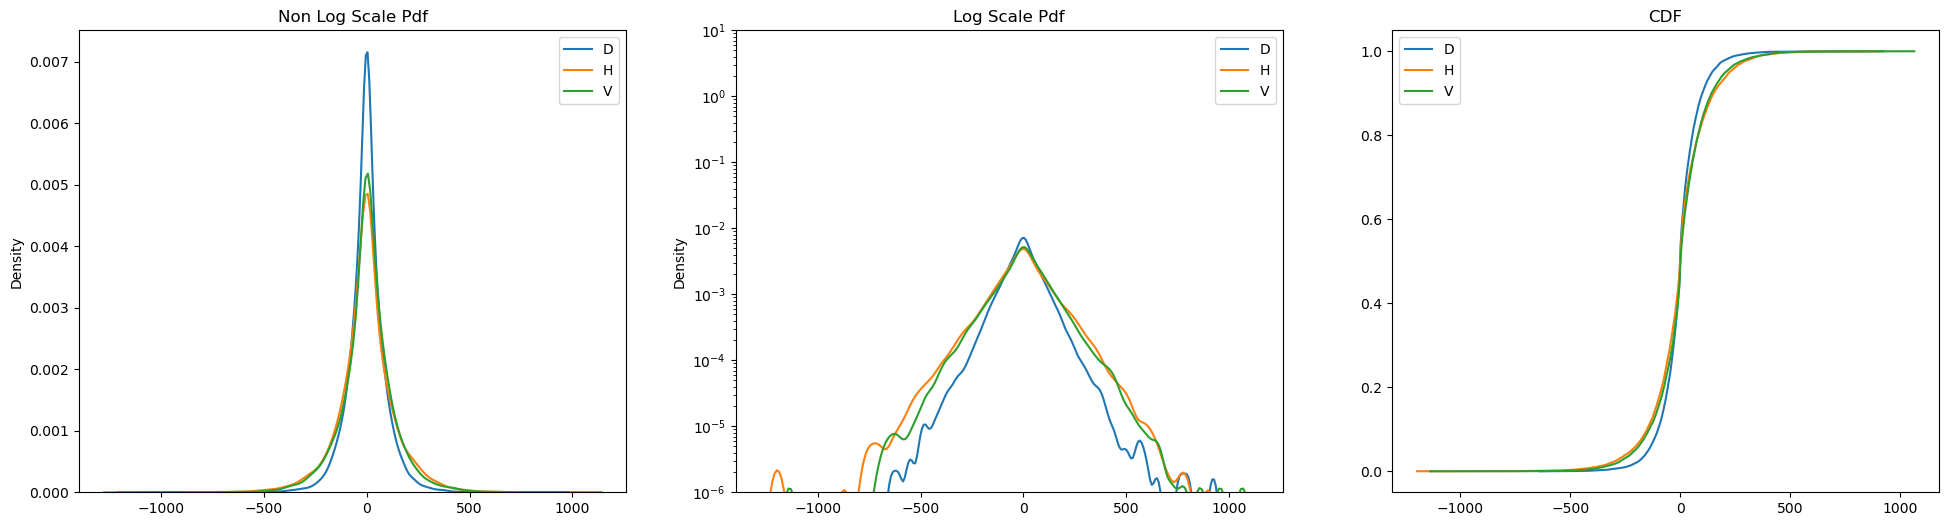

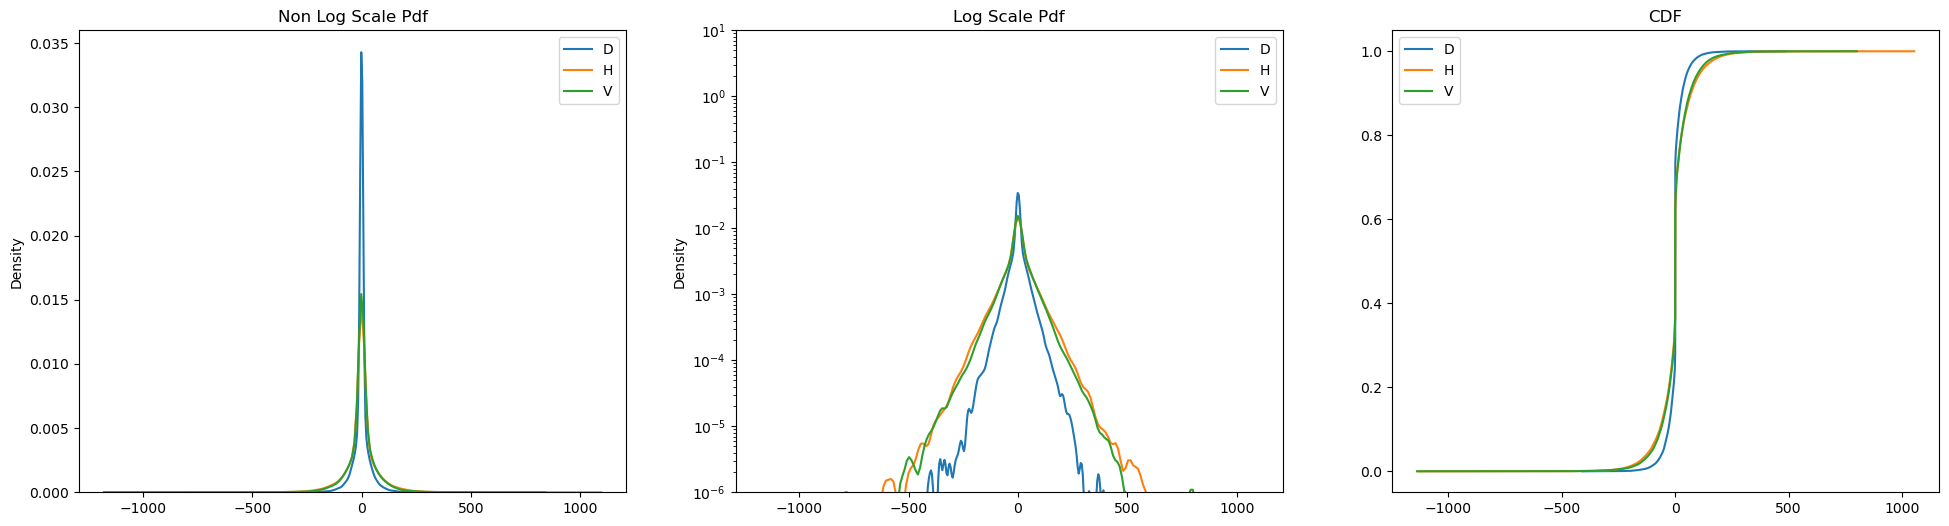

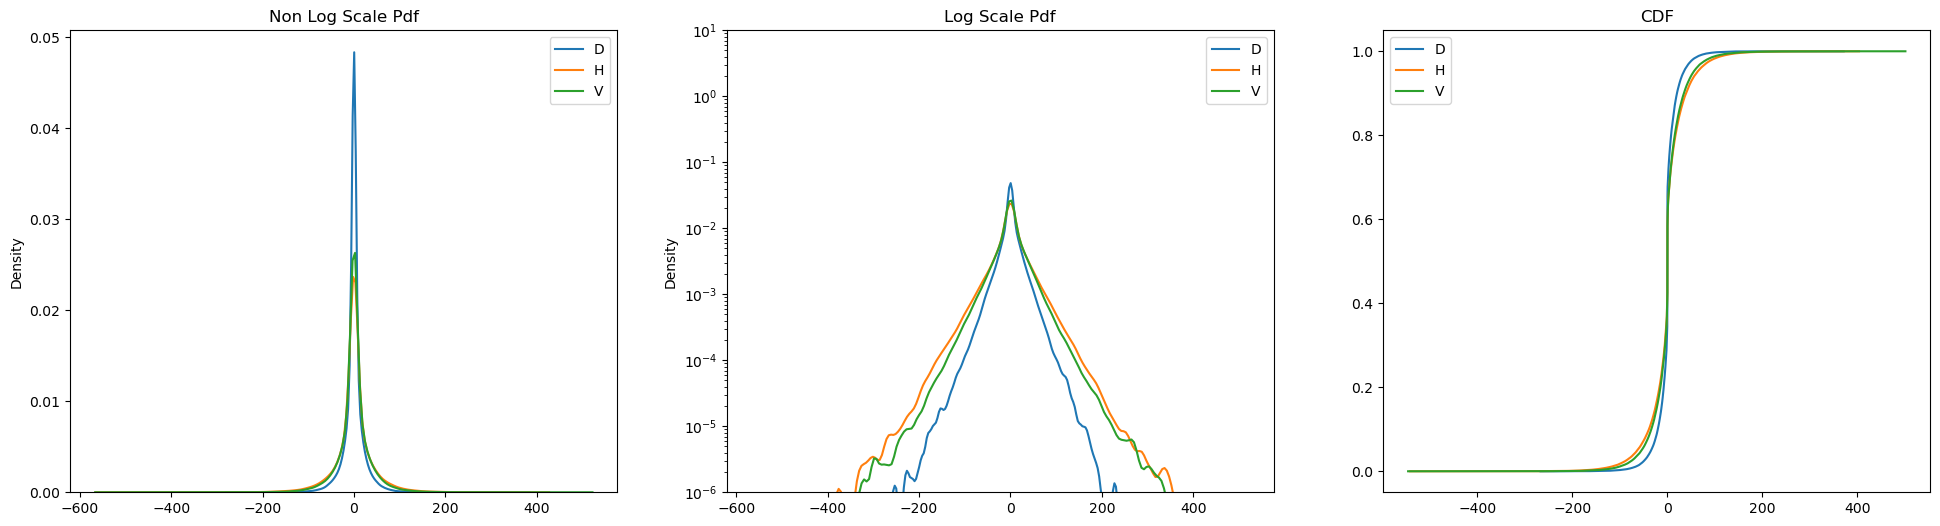

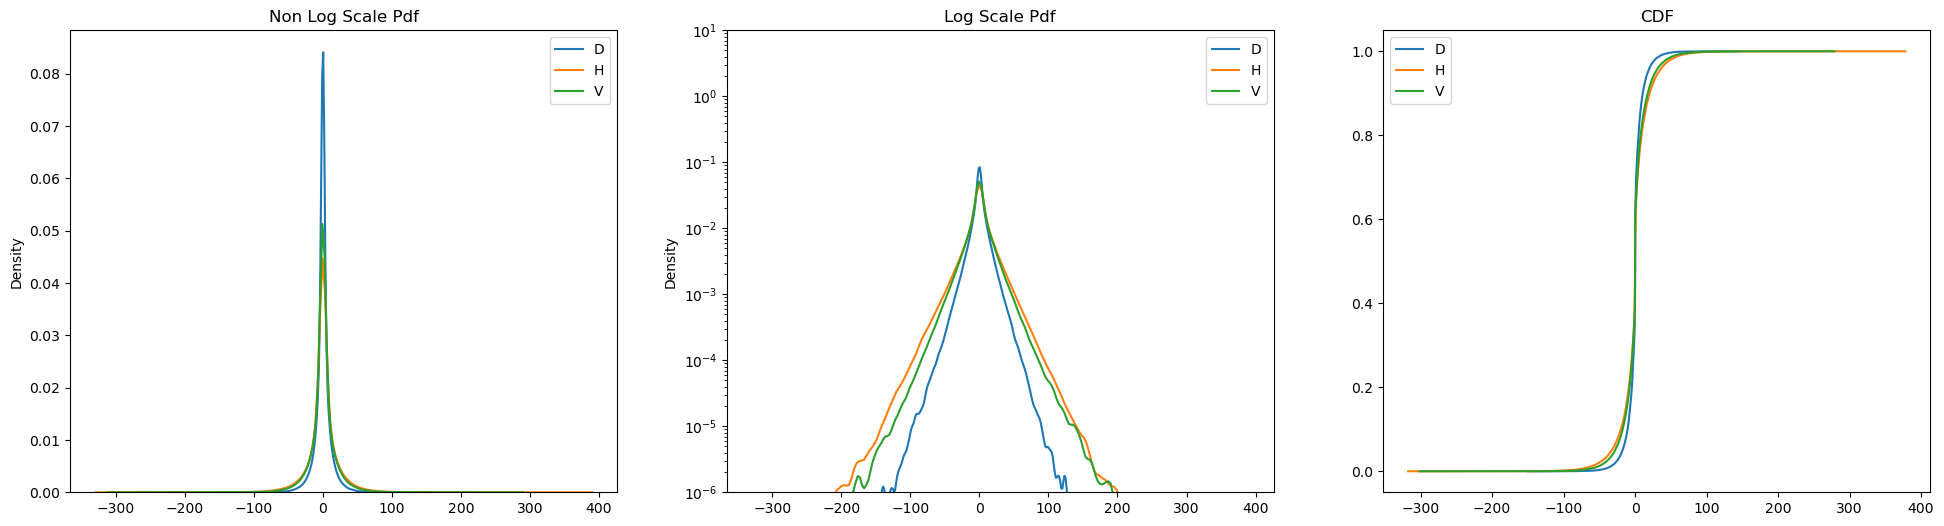

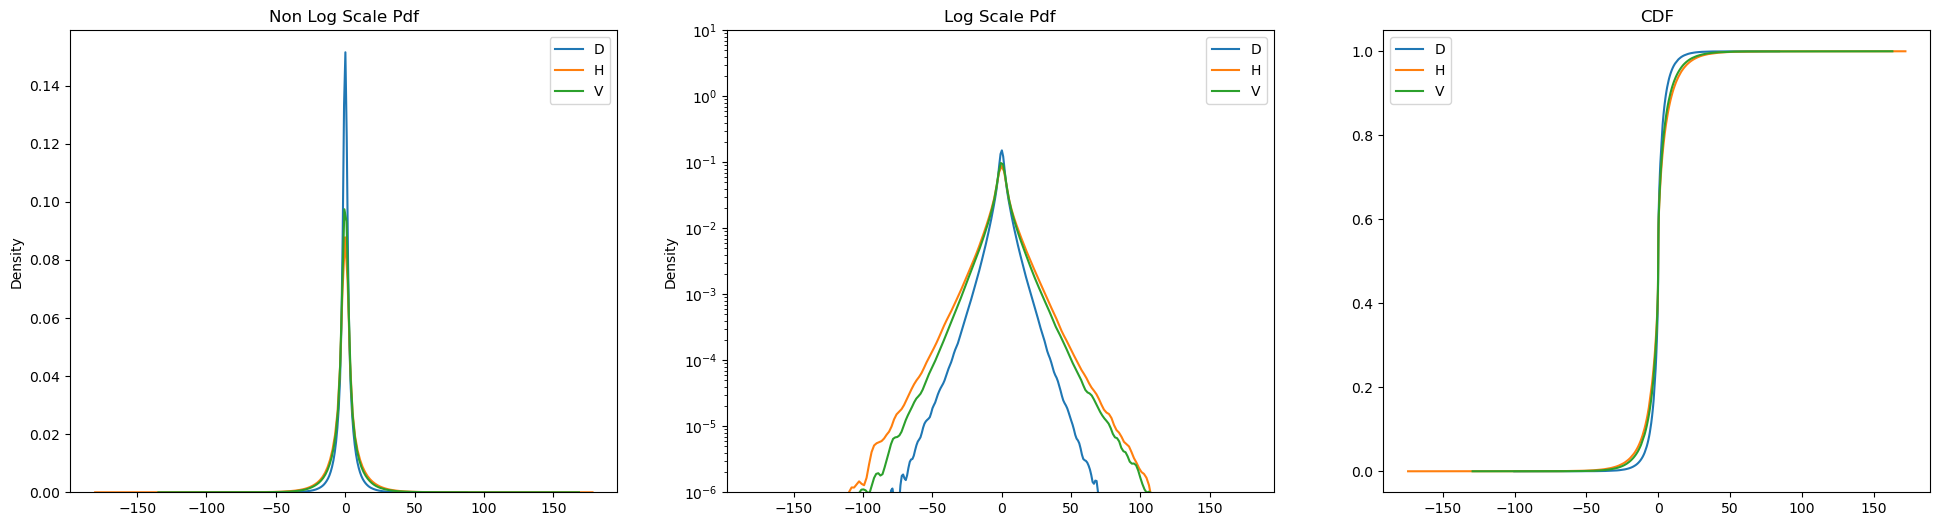

/opt/anaconda3/envs/hbmv/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


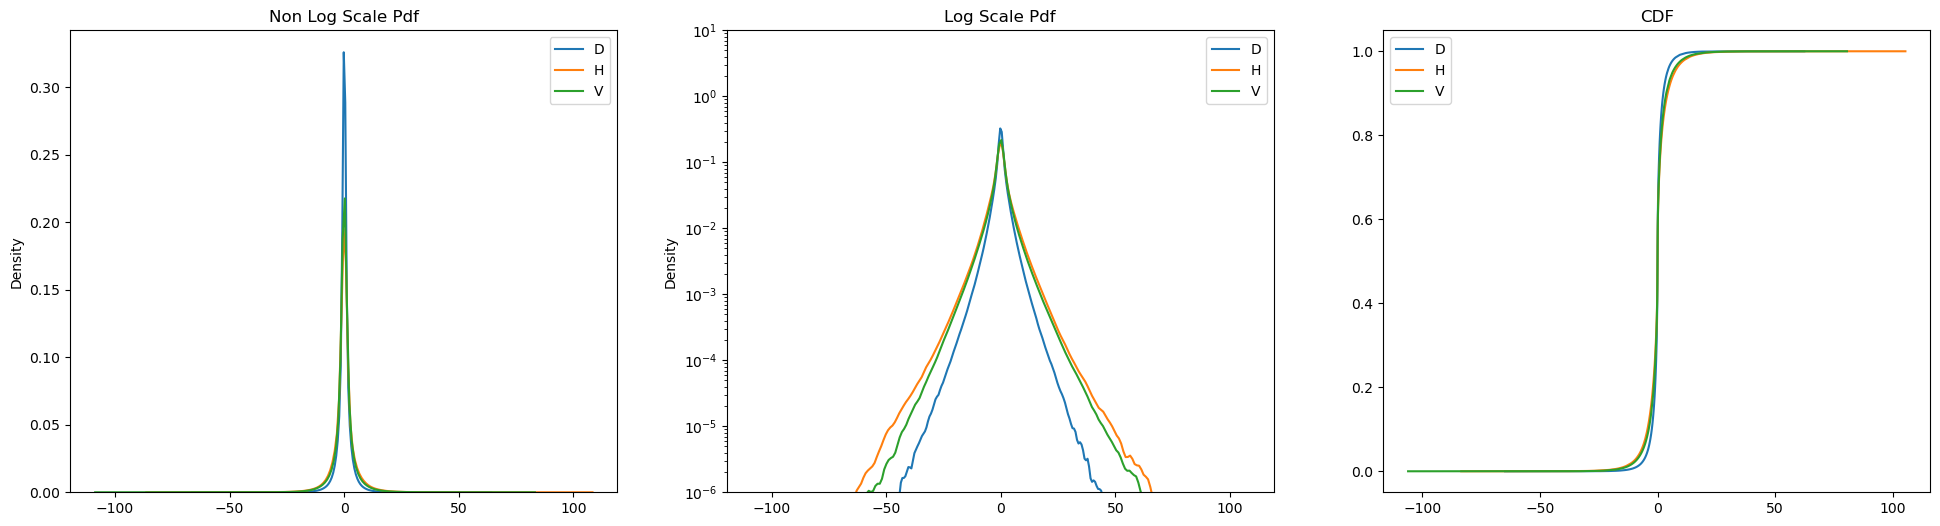

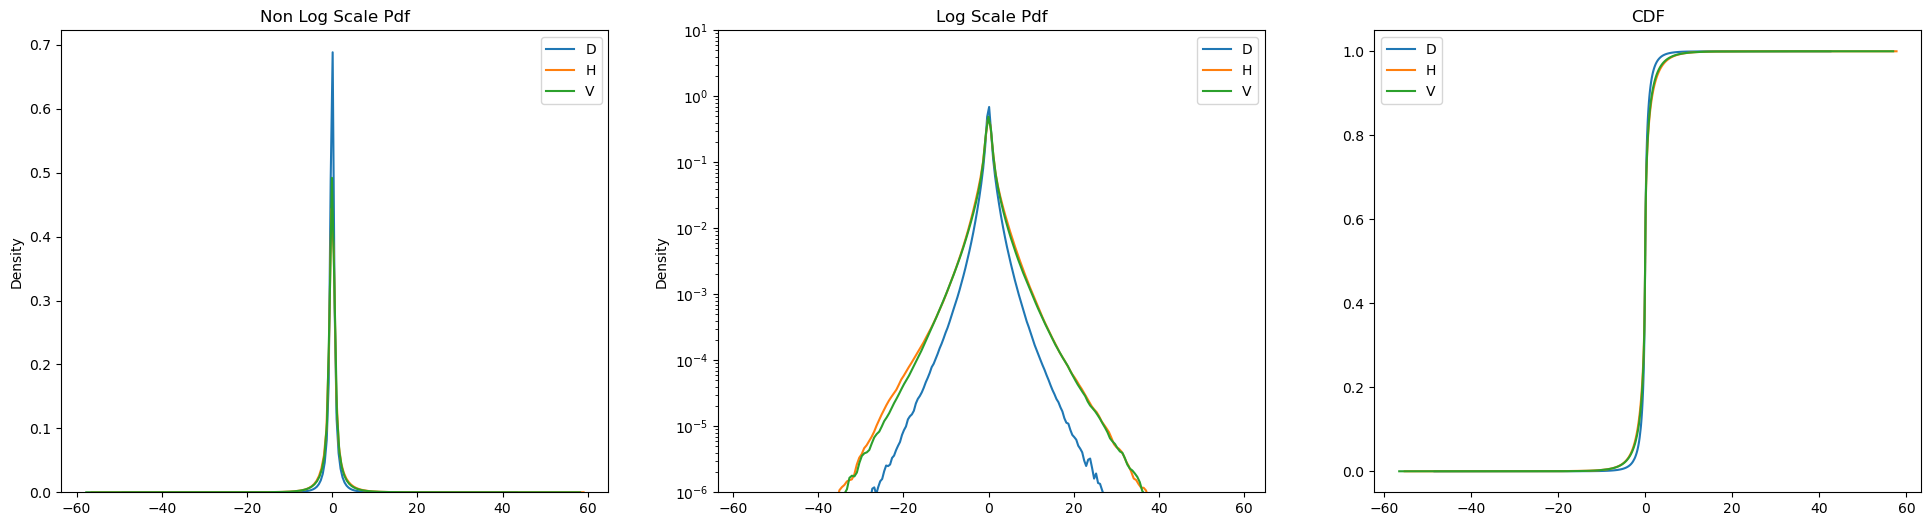

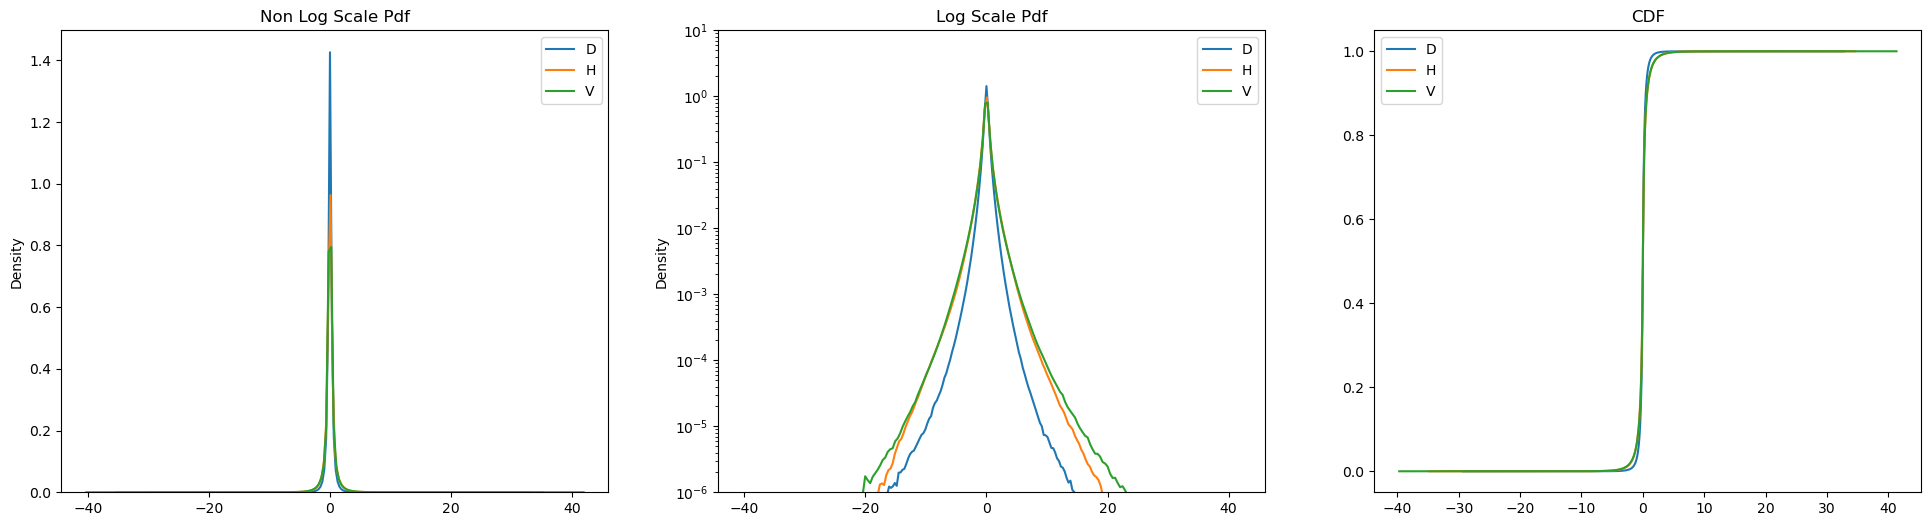

In [9]:
for i in range(2, 10):
    layer_df = red_wv[red_wv["layer"] == i]
    data = layer_df["data"].to_list()
    multiSampleComparisonPlots(data,  layer_df["orientation"].to_list(), bw =0.2)


/opt/anaconda3/envs/hbmv/lib/python3.11/site-packages/IPython/core/events.py:82: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)


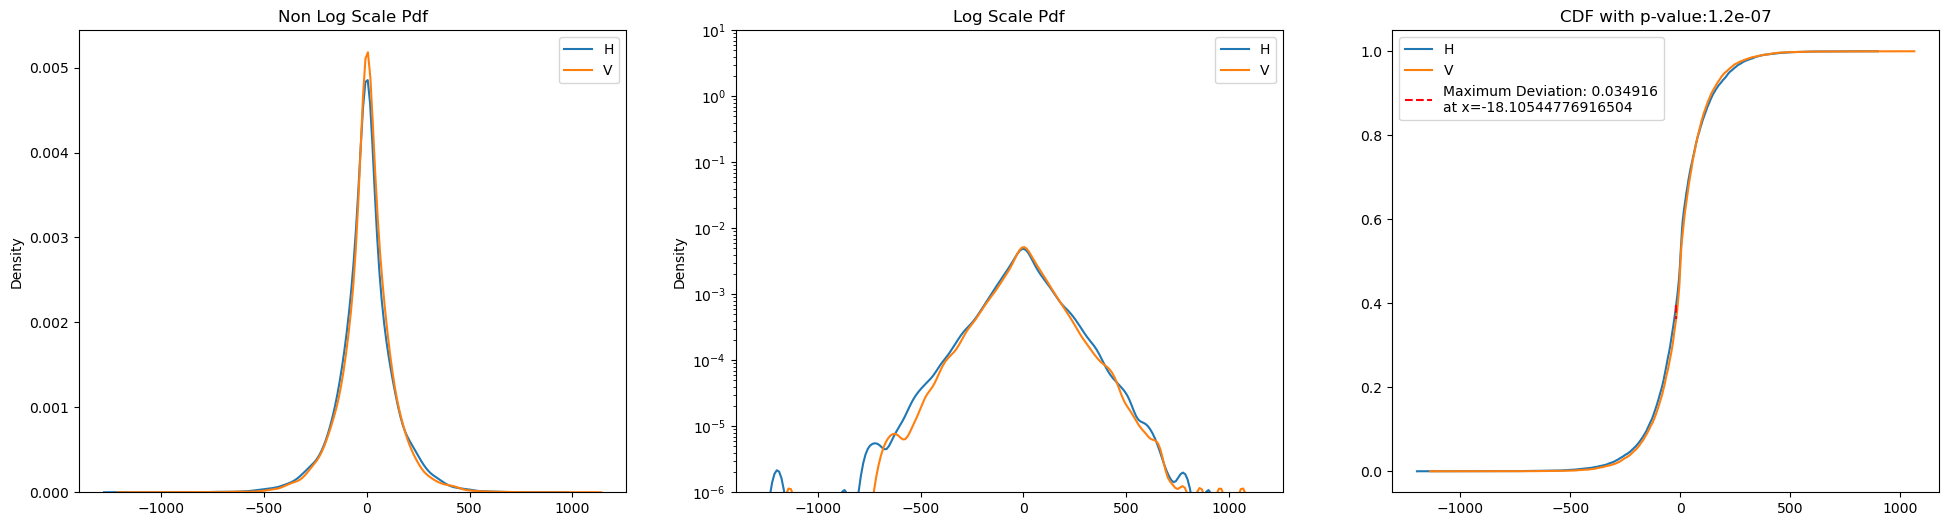

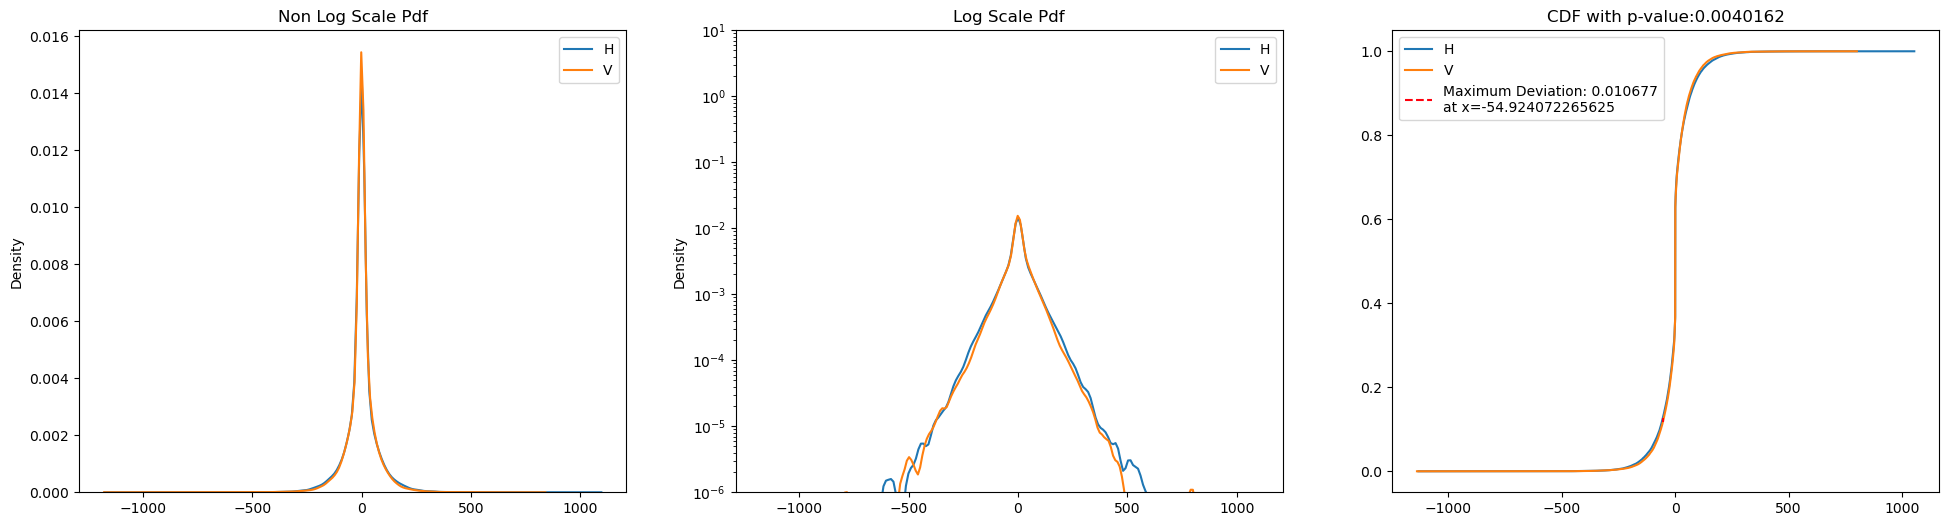

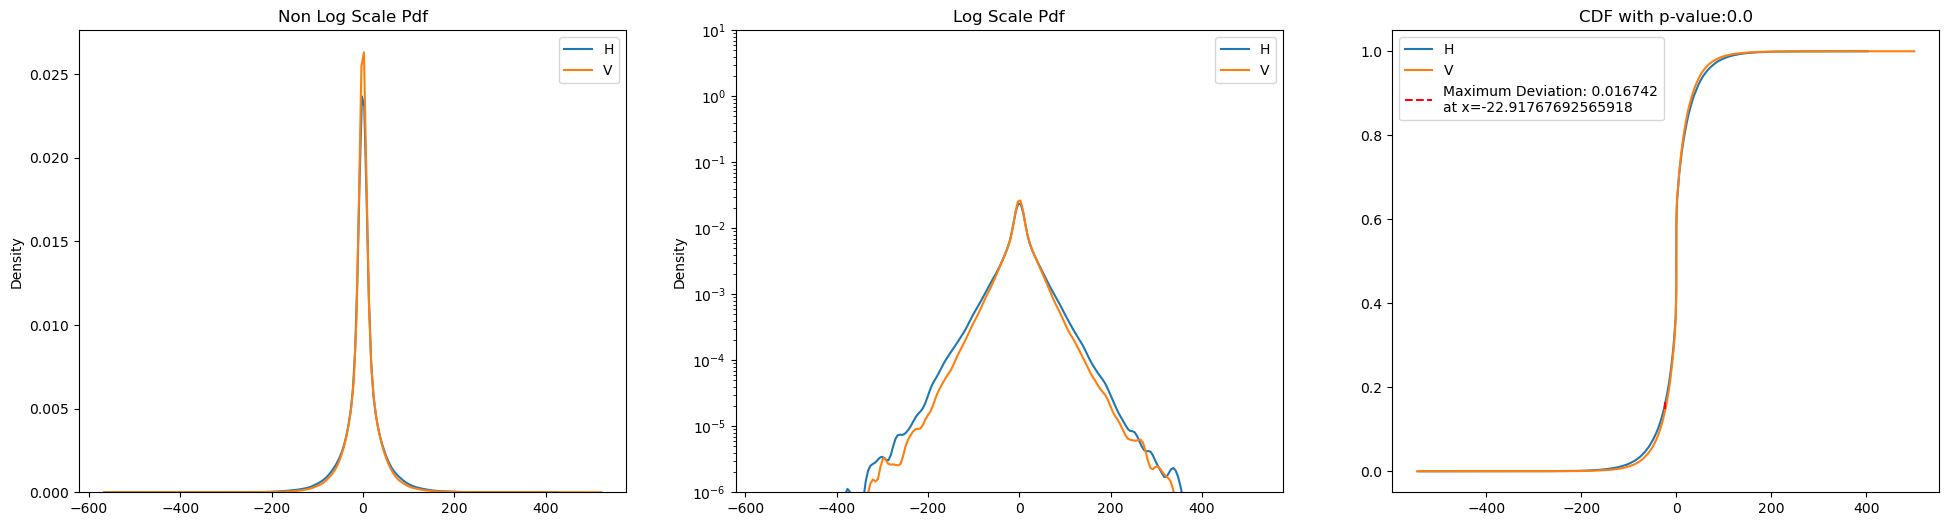

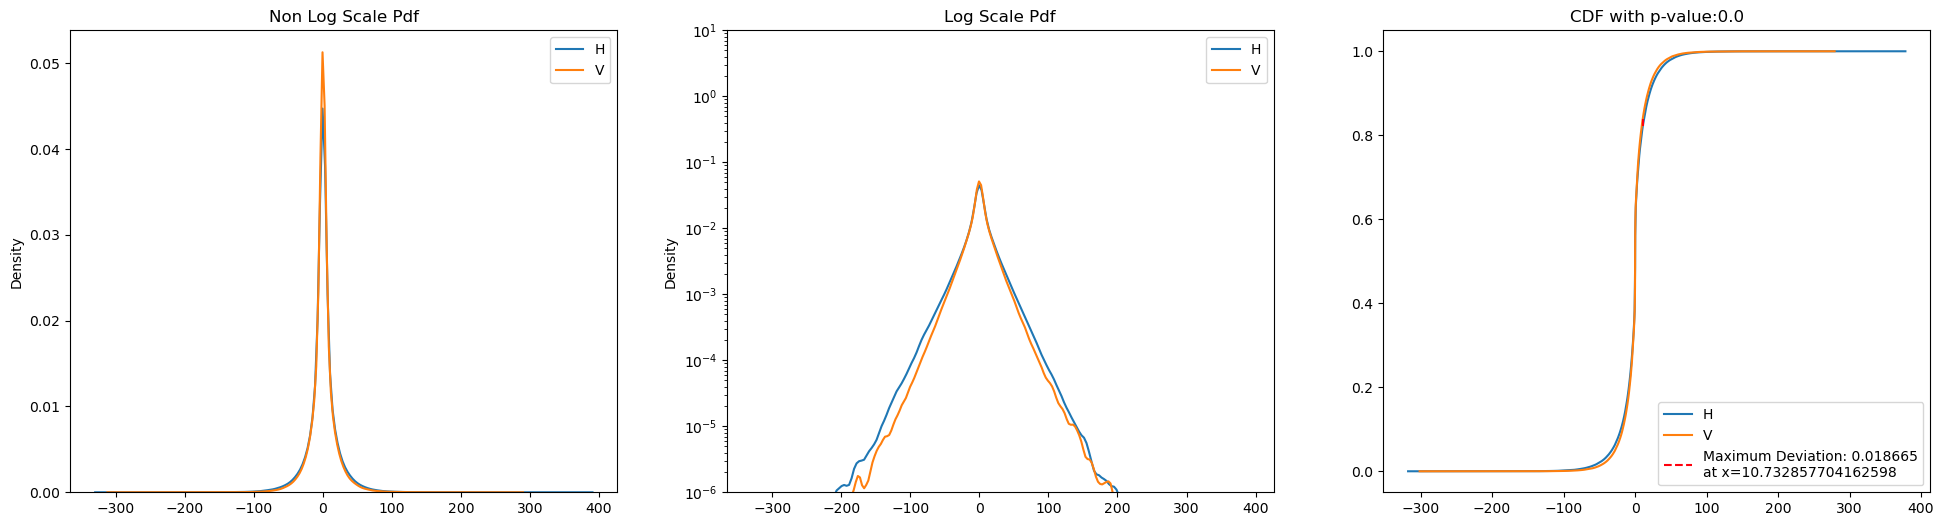

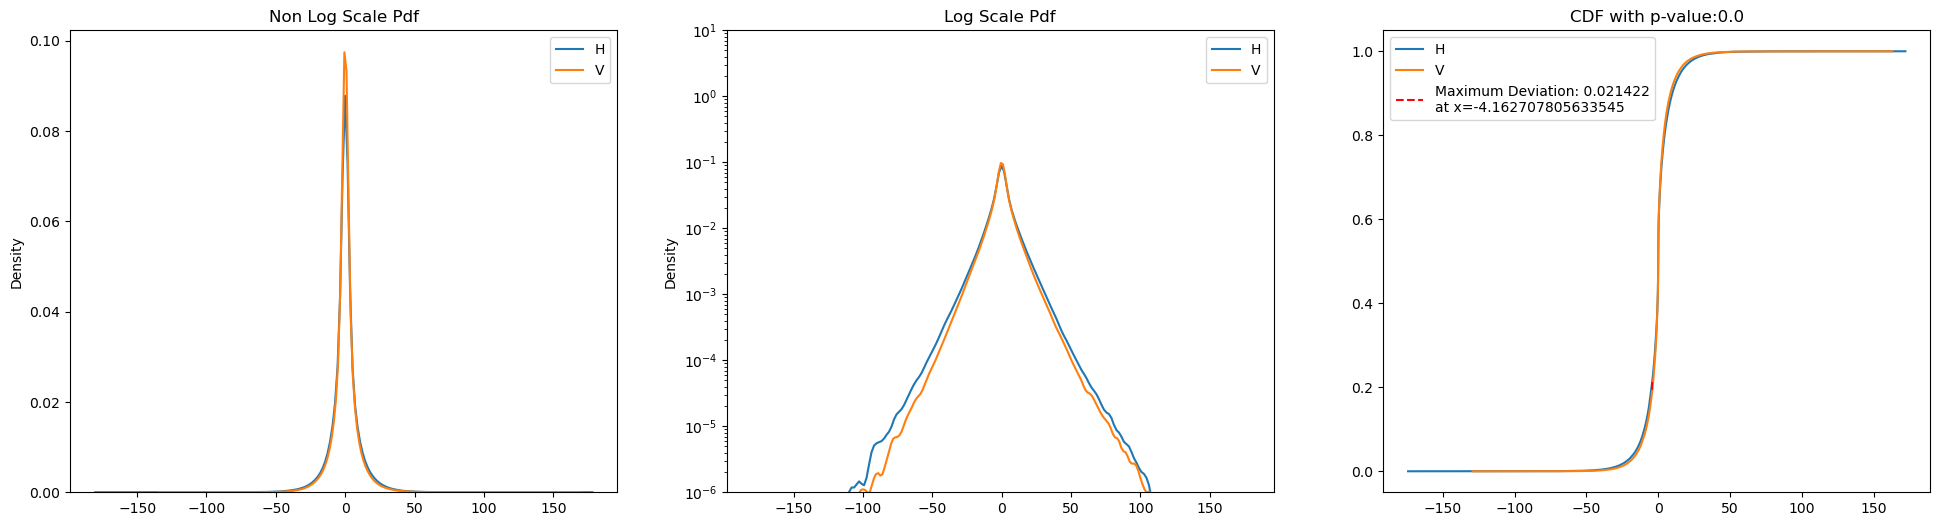

/opt/anaconda3/envs/hbmv/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


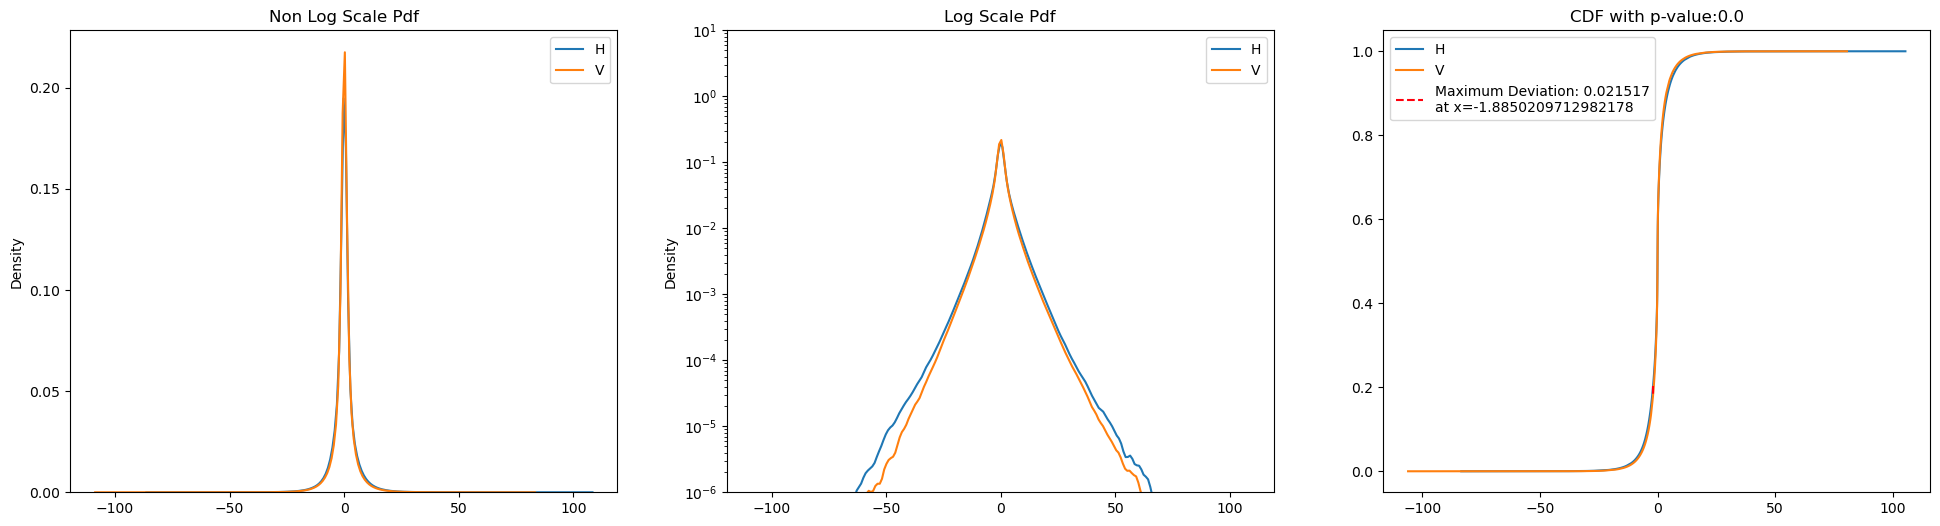

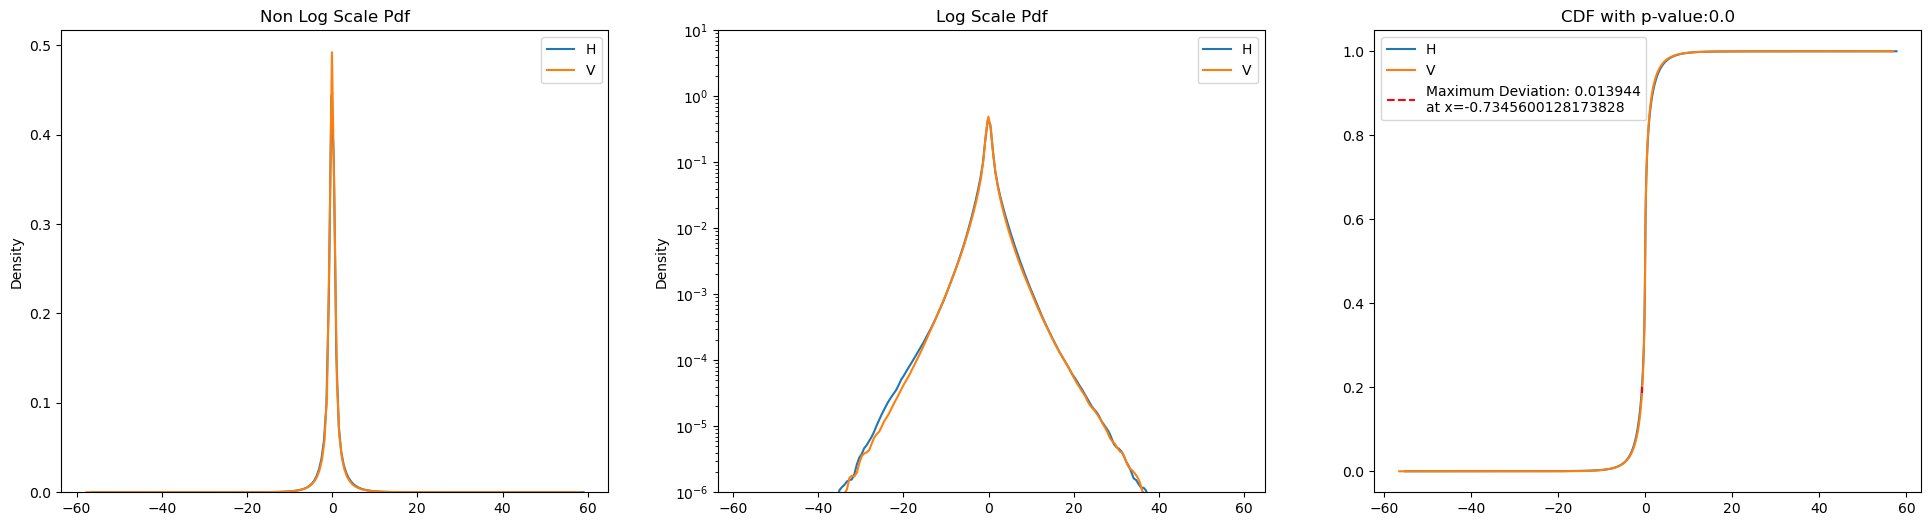

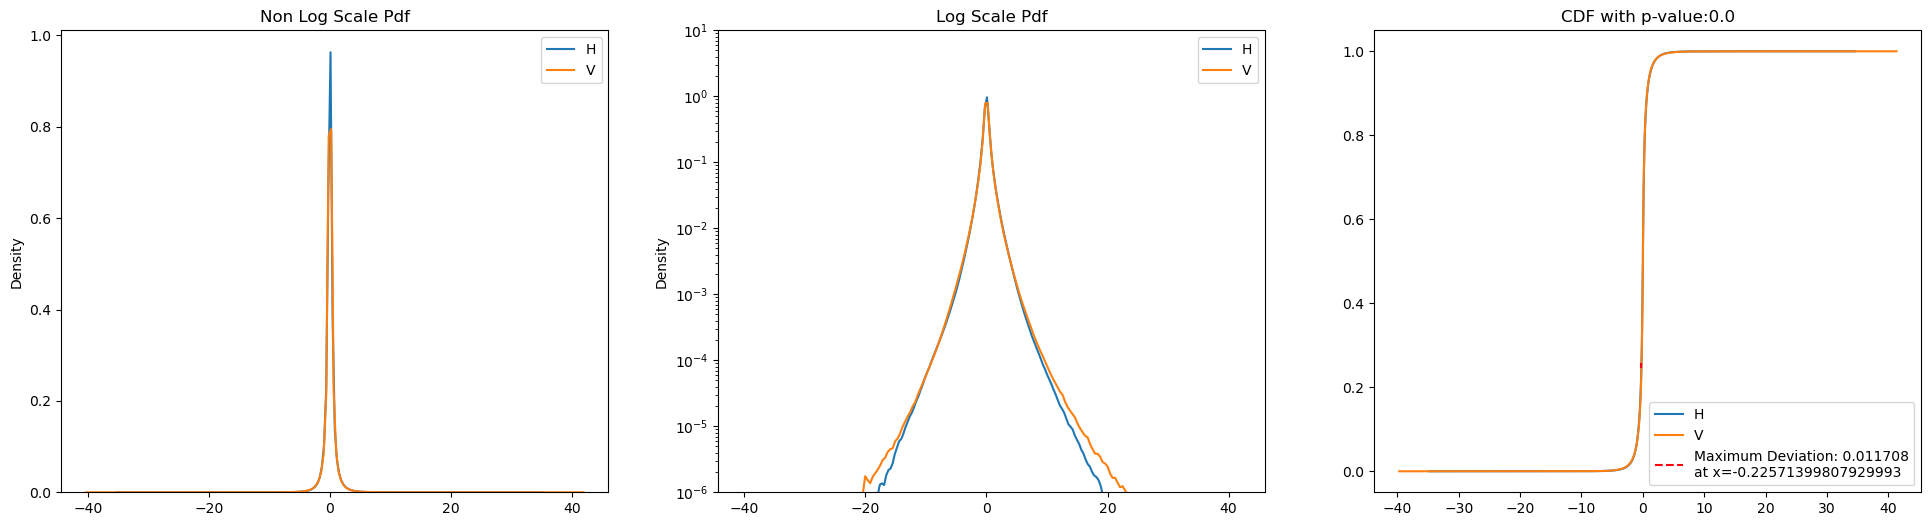

In [10]:
for i in range(2, 10):
    layer_df = red_wv[red_wv["layer"] == i]
    data = layer_df["data"].to_list()
    first_samp = layer_df[layer_df["orientation"] == "H"]["data"].iloc[0]
    second_samp = layer_df[layer_df["orientation"] == "V"]["data"].iloc[0]
    twoSampleComparisonPlots(first_samp, second_samp, samp1name="H", samp2name= "V")

# Green

In [ ]:
green_wv = convert_to_wavelet_basis(data_dir, "green", debug=True, image_opener = batch_image_opener)
green_wv.head()

9 layers being used


100%|██████████| 3401/3401 [00:12<00:00, 268.79it/s]


channel  layer orientation  \
0   green      1          L1   
1   green      2           D   
2   green      2           H   
3   green      2           V   
4   green      3           D   

                                                data  
0  [-385.907, -469.30624, -156.88853, -187.33362,...  
1  [-12.025628, -5.4726024, 25.631044, 3.545285, ...  
2  [-15.197036, -14.697876, 92.549385, -66.882195...  
3  [-8.2038, -2.4739206, -158.98033, 8.666337, -3...  
4  [2.228407, 0.92201763, -10.243609, -4.8147854e...

In [8]:
green_df = pd.DataFrame(columns = ["Layer", "First", "Second", "KS_Stat", "Pvalue"])
for i in range(2, 11):
    layer_df = green_wv[green_wv["layer"] == i]
    data = layer_df["data"].to_list()
    names = layer_df["orientation"].to_list()
    ks_df = ksCombinations(data, layer_df["orientation"].to_list(), i).sort_values(["Layer", "KS_Stat"])
    green_df = pd.concat([green_df, ks_df], axis = 0)
green_df

/var/folders/cg/nwm9l18x22zc8_fj15gvgg2h0000gp/T/ipykernel_75210/1157885314.py:7: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  green_df = pd.concat([green_df, ks_df], axis = 0)
/var/folders/cg/nwm9l18x22zc8_fj15gvgg2h0000gp/T/ipykernel_75210/1157885314.py:7: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  green_df = pd.concat([green_df, ks_df], axis = 0)


Layer First Second   KS_Stat         Pvalue
2     2     H      V  0.038151   4.879652e-09
1     2     D      V  0.064760   3.032049e-25
0     2     D      H  0.076742   2.748404e-35
2     3     H      V  0.012809   2.630065e-04
0     3     D      H  0.105024  9.129911e-262
1     3     D      V  0.110317  7.670107e-289
2     4     H      V  0.020696   1.958416e-31
1     4     D      V  0.076166   0.000000e+00
0     4     D      H  0.084483   0.000000e+00
2     5     H      V  0.021828  2.236868e-119
1     5     D      V  0.062526   0.000000e+00
0     5     D      H  0.081918   0.000000e+00
2     6     H      V  0.025783   0.000000e+00
1     6     D      V  0.059375   0.000000e+00
0     6     D      H  0.085058   0.000000e+00
2     7     H      V  0.024903   0.000000e+00
1     7     D      V  0.053970   0.000000e+00
0     7     D      H  0.078635   0.000000e+00
2     8     H      V  0.015552   0.000000e+00
1     8     D      V  0.045958   0.000000e+00
0     8     D      H  0.061455   0.000000e+00
2     9     H      V  0.011623   0.000000e+00
1     9     D      V  0.043035   0.000000e+00
0     9     D      H  0.051687   0.000000e+00

/opt/anaconda3/envs/hbmv/lib/python3.11/site-packages/IPython/core/events.py:82: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)


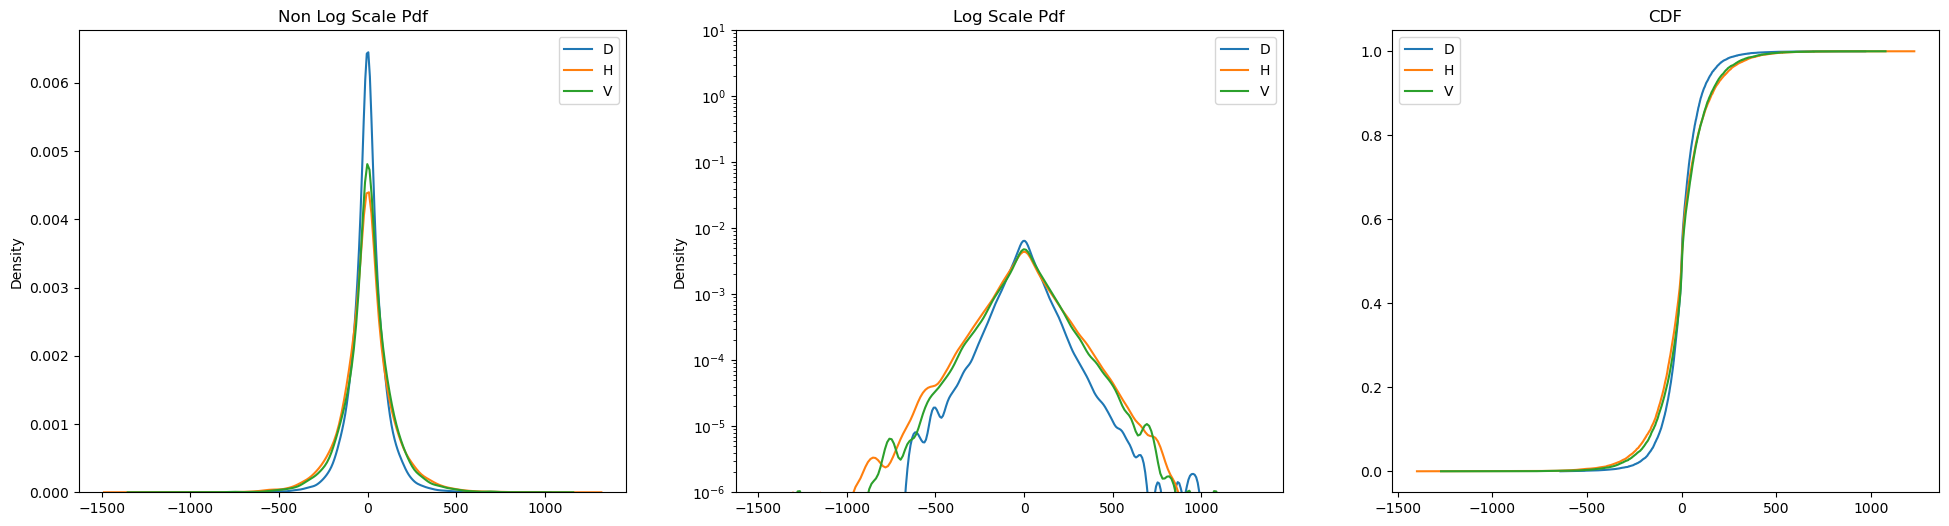

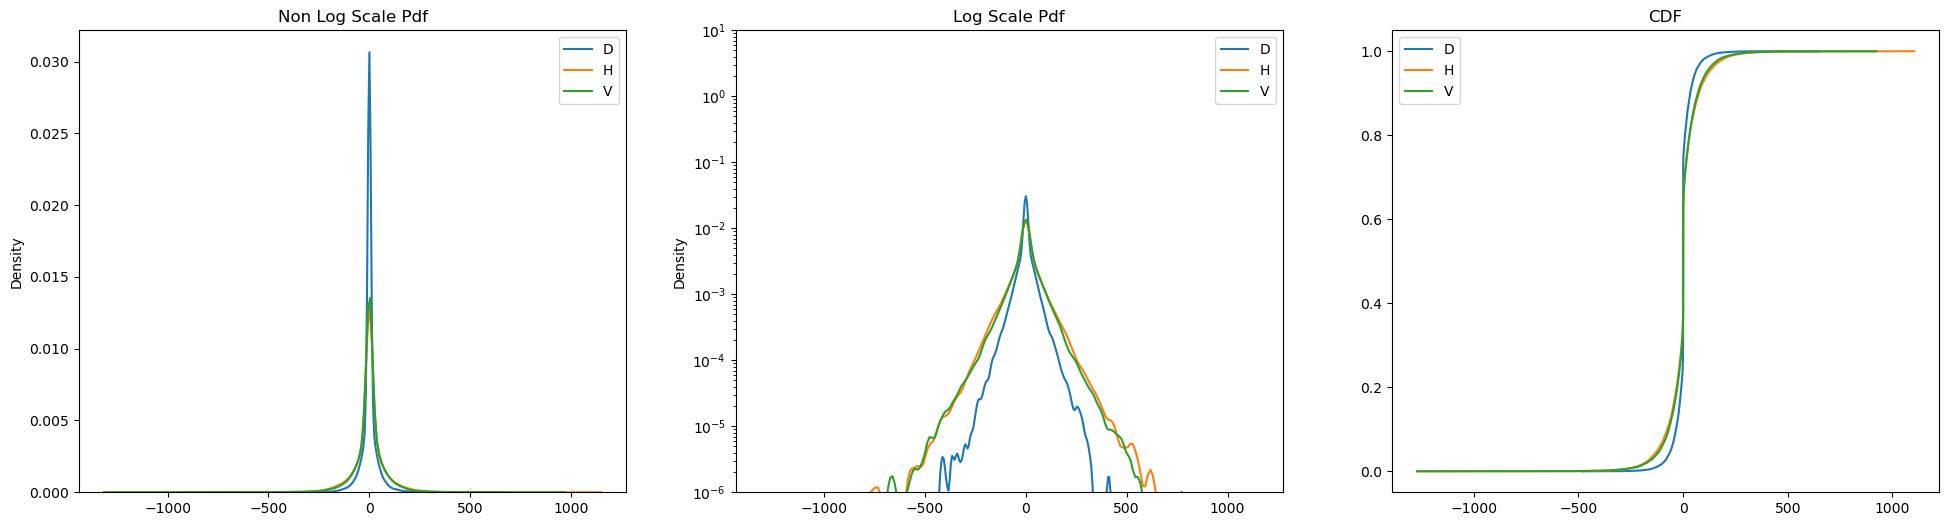

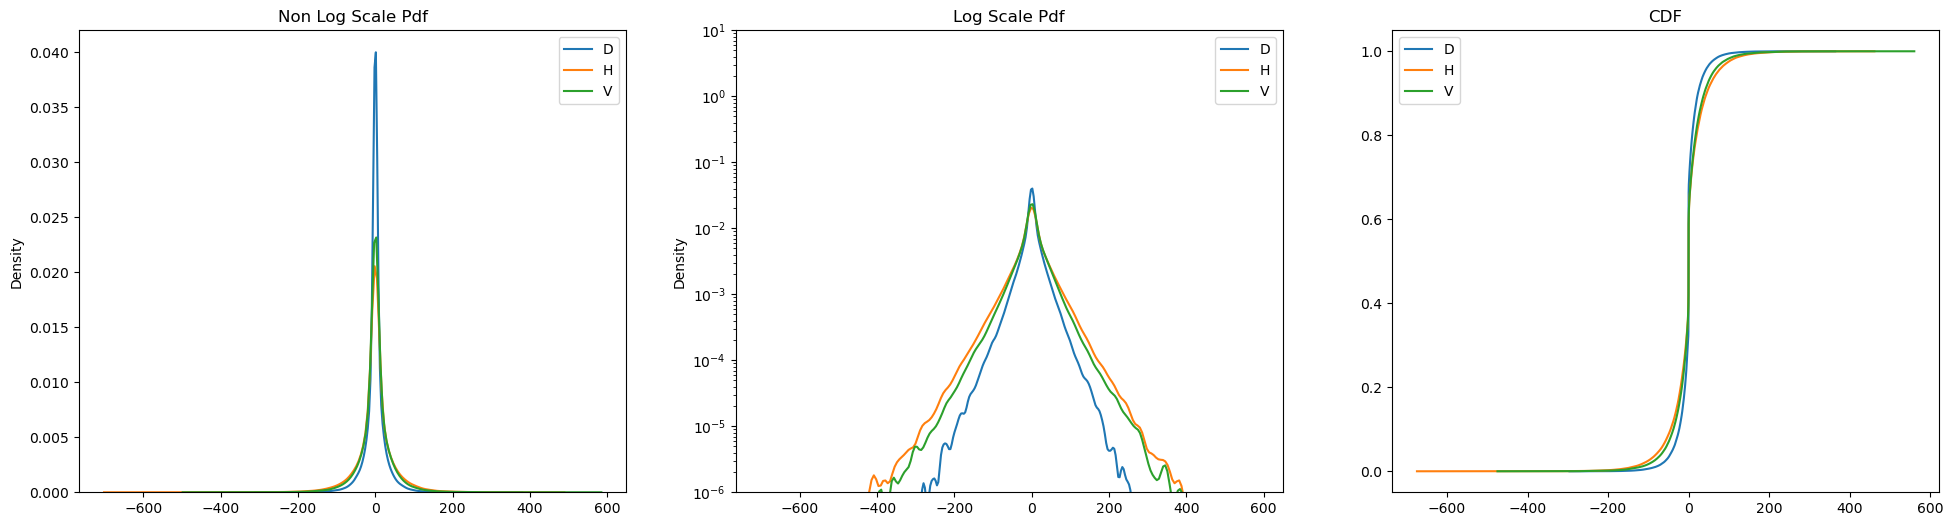

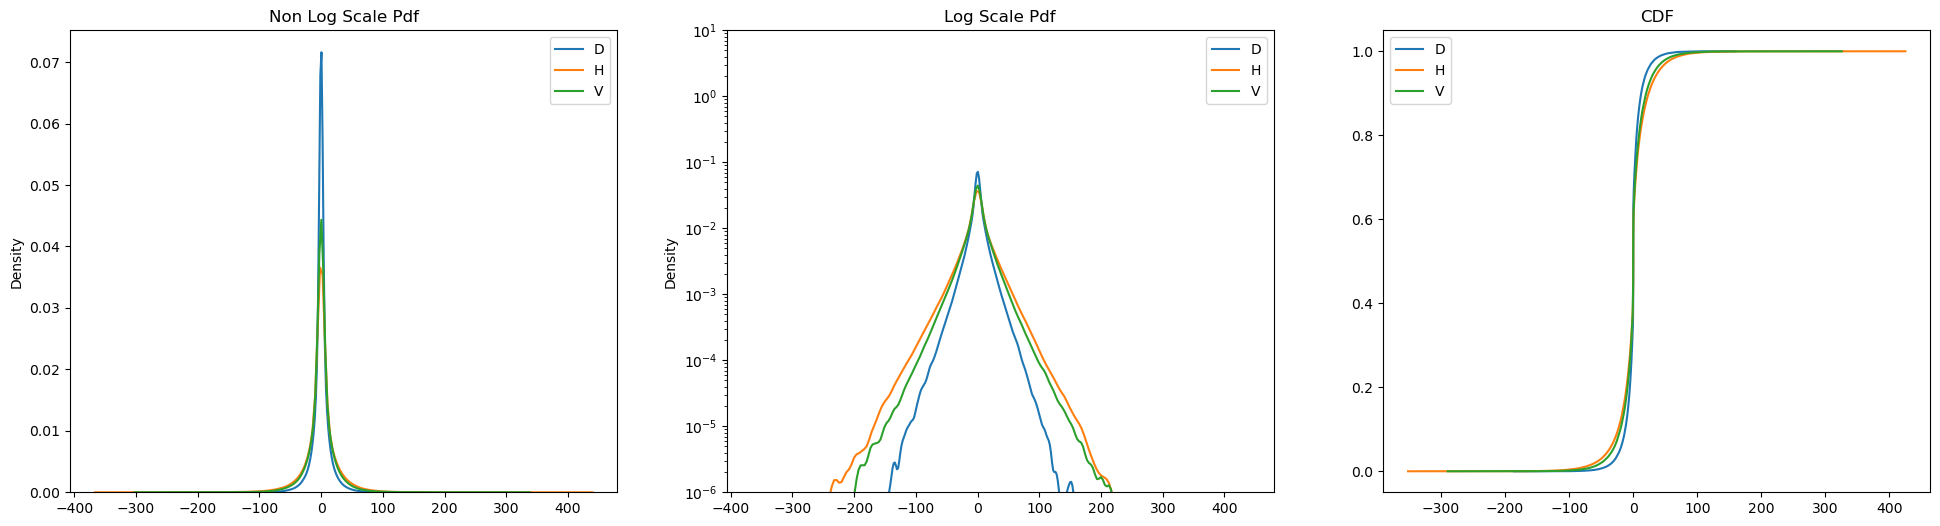

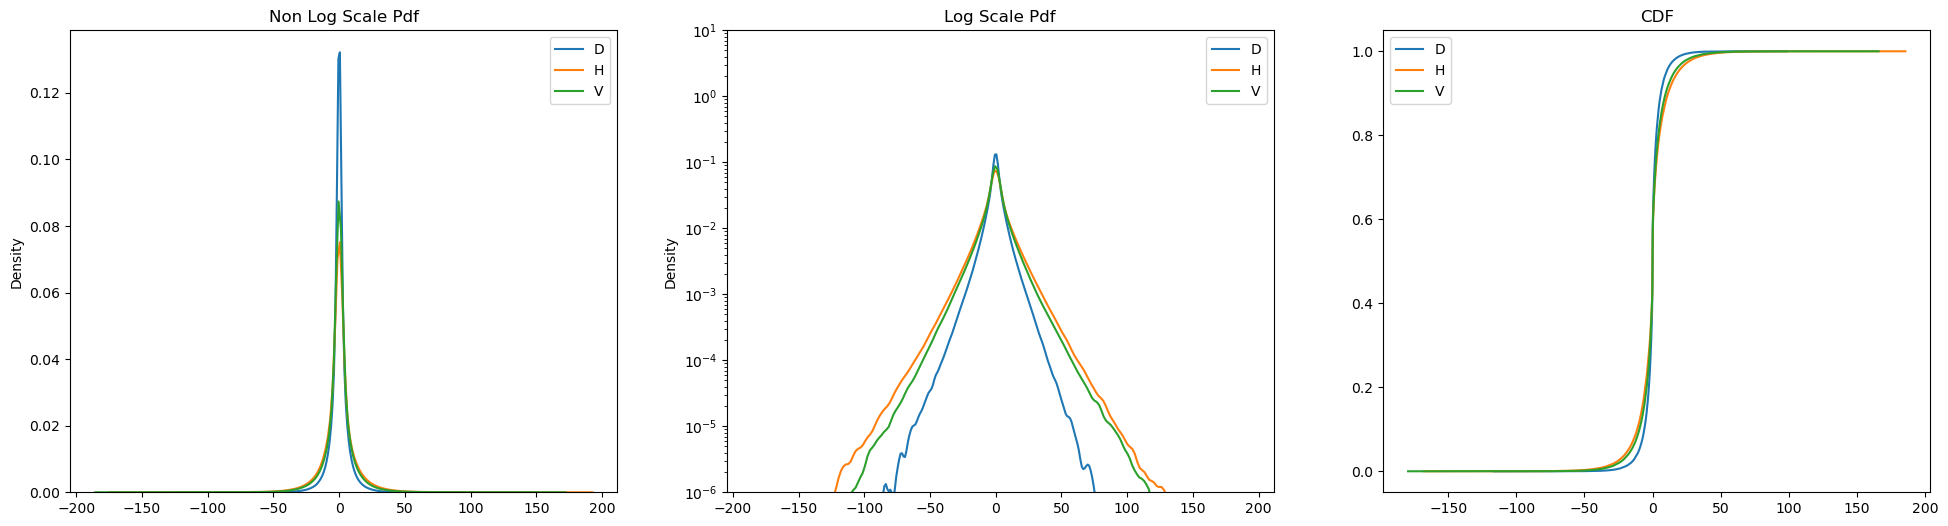

/opt/anaconda3/envs/hbmv/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


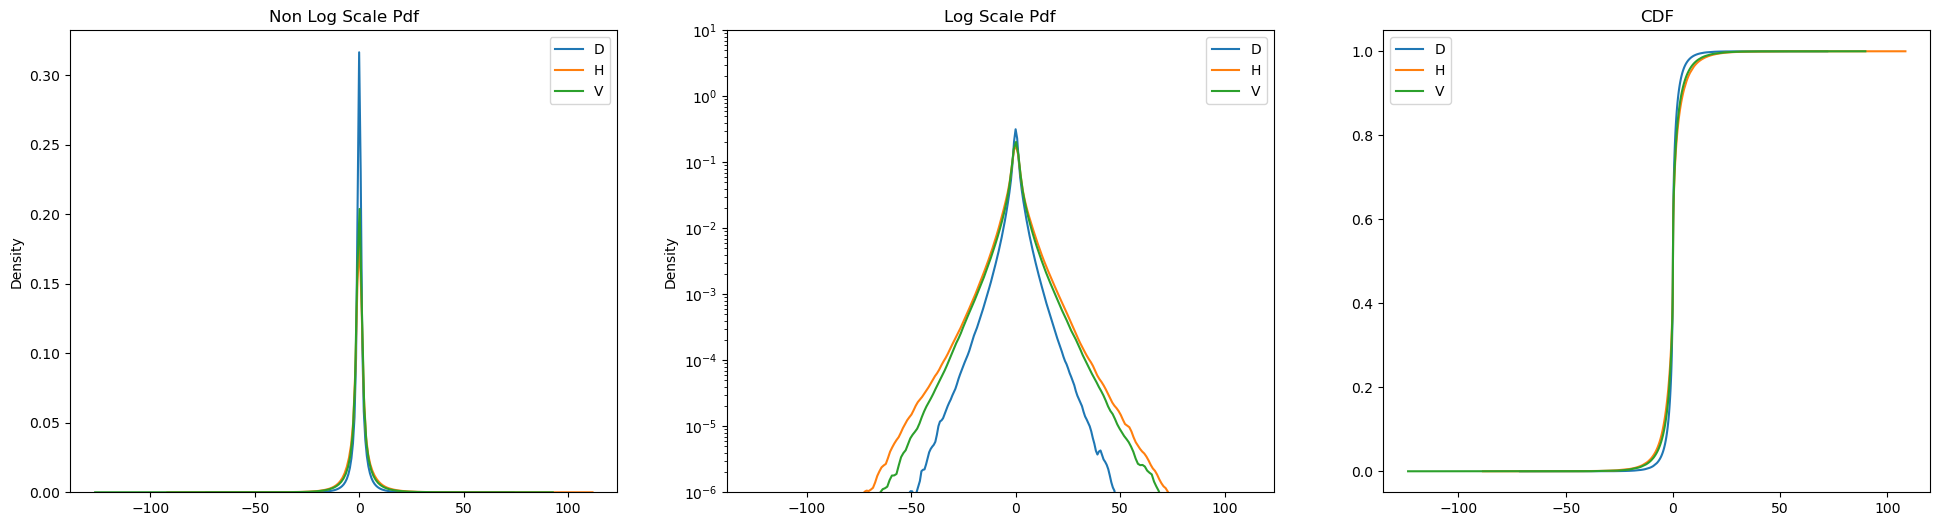

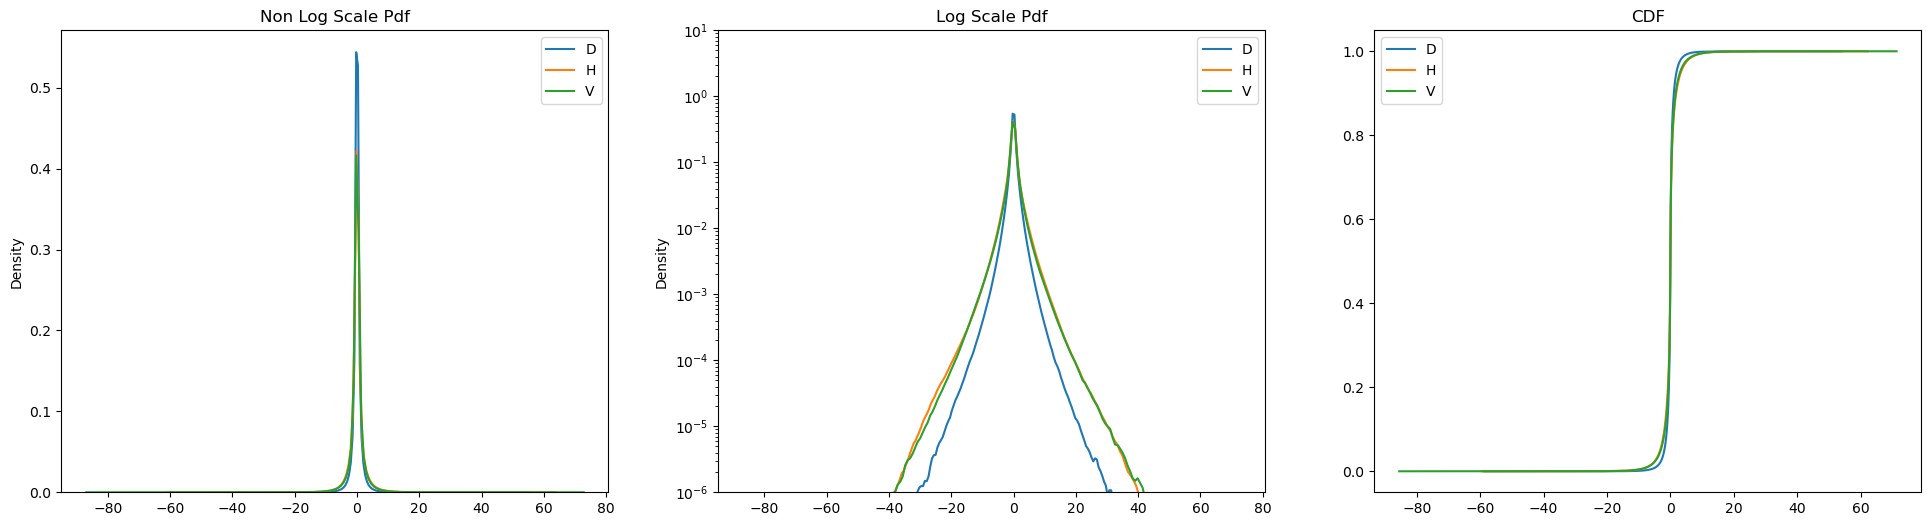

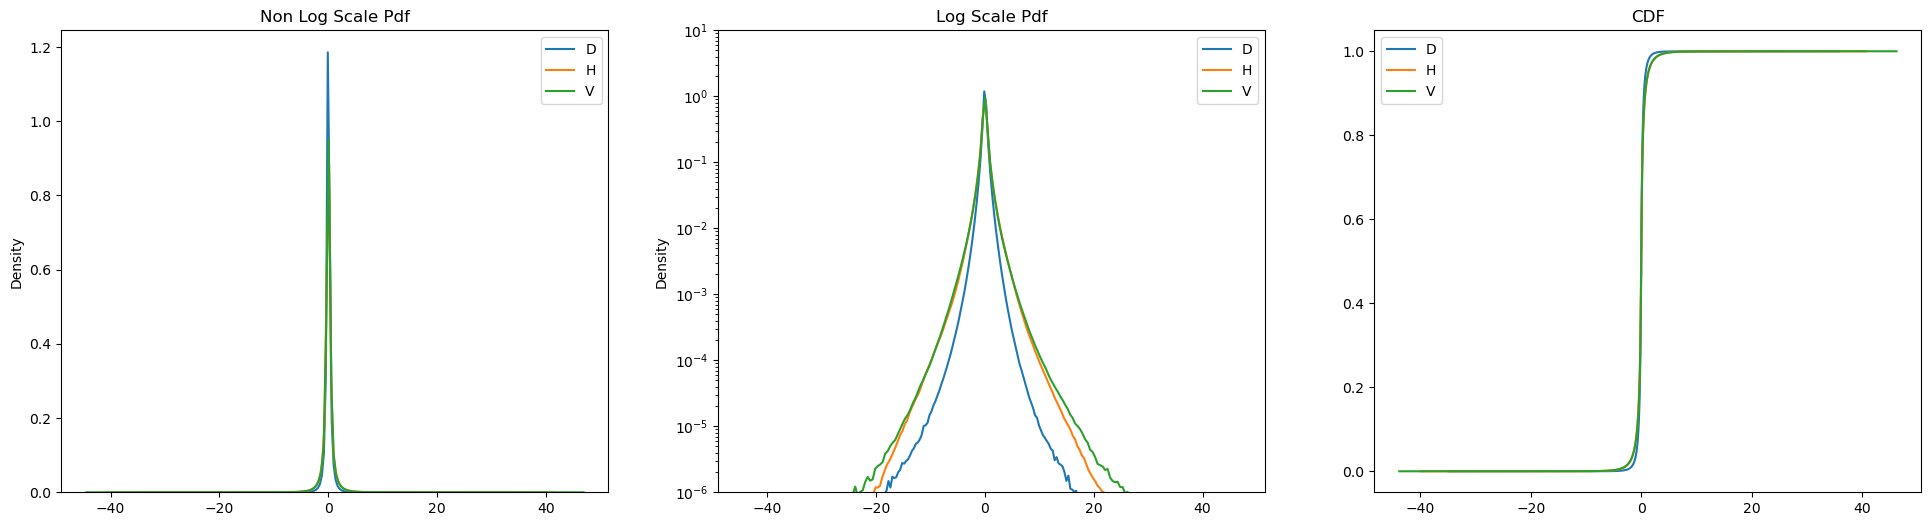

In [9]:
for i in range(2, 10):
    layer_df = green_wv[green_wv["layer"] == i]
    data = layer_df["data"].to_list()
    multiSampleComparisonPlots(data,  layer_df["orientation"].to_list(), bw =0.2)


/opt/anaconda3/envs/hbmv/lib/python3.11/site-packages/IPython/core/events.py:82: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)


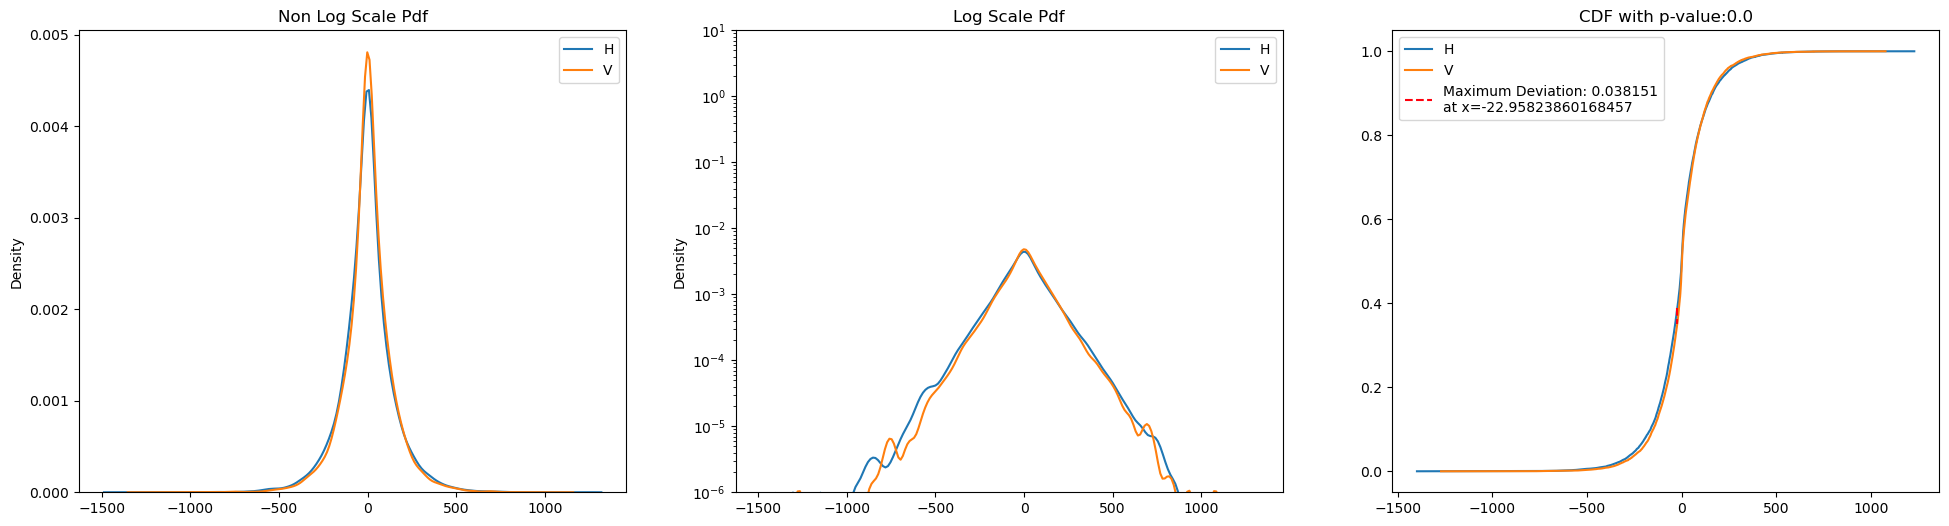

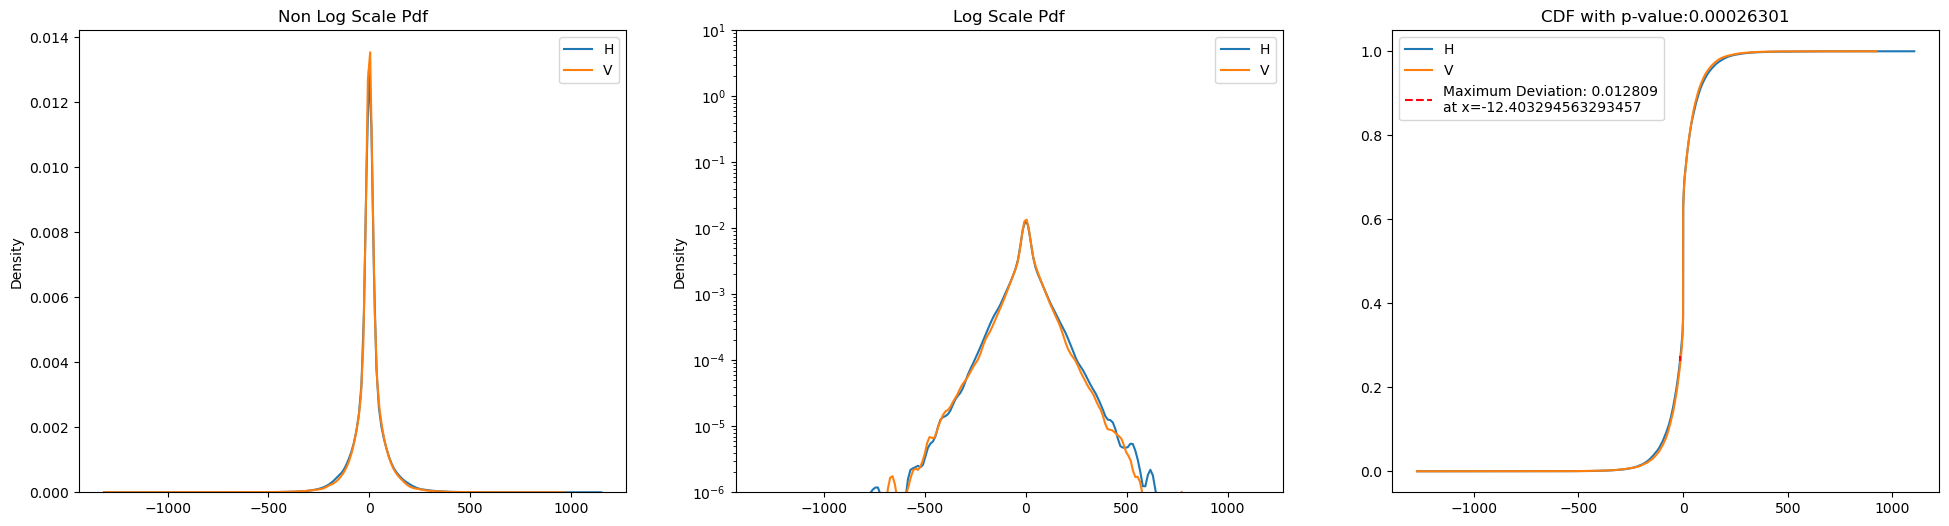

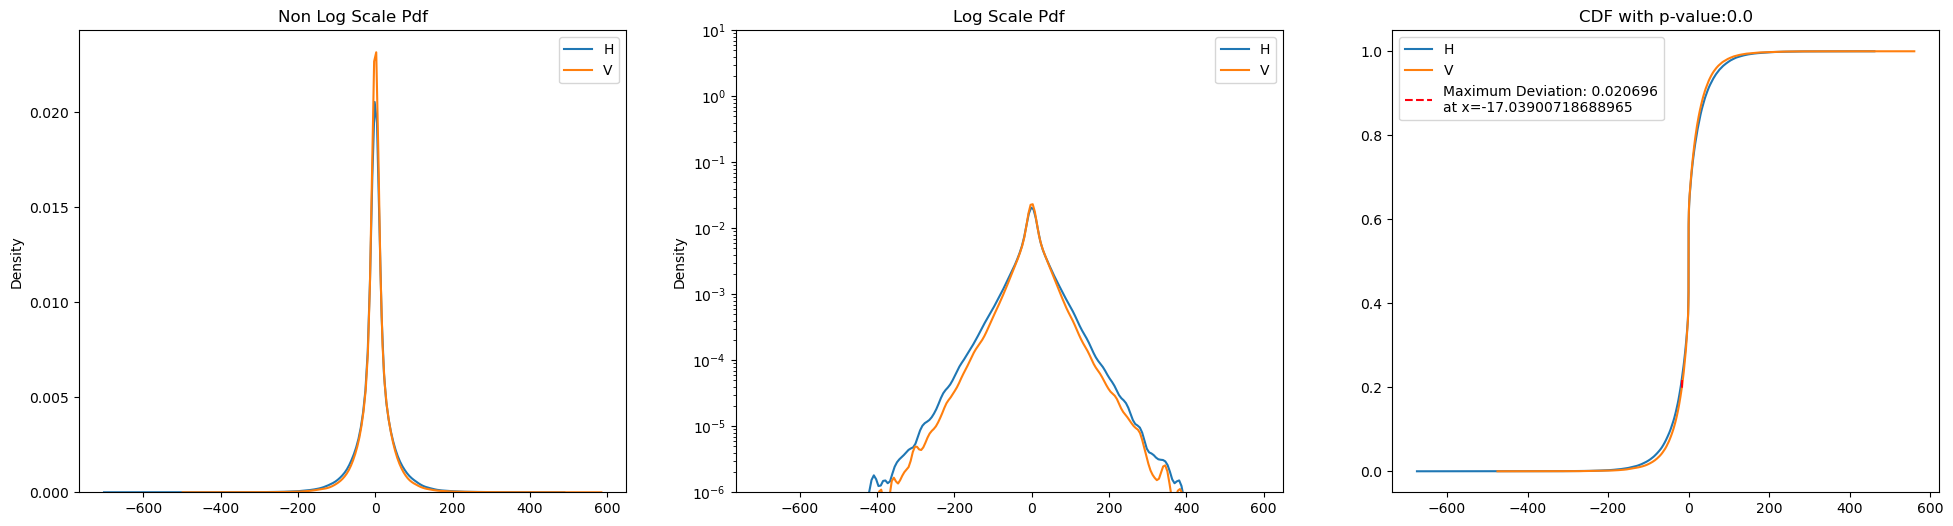

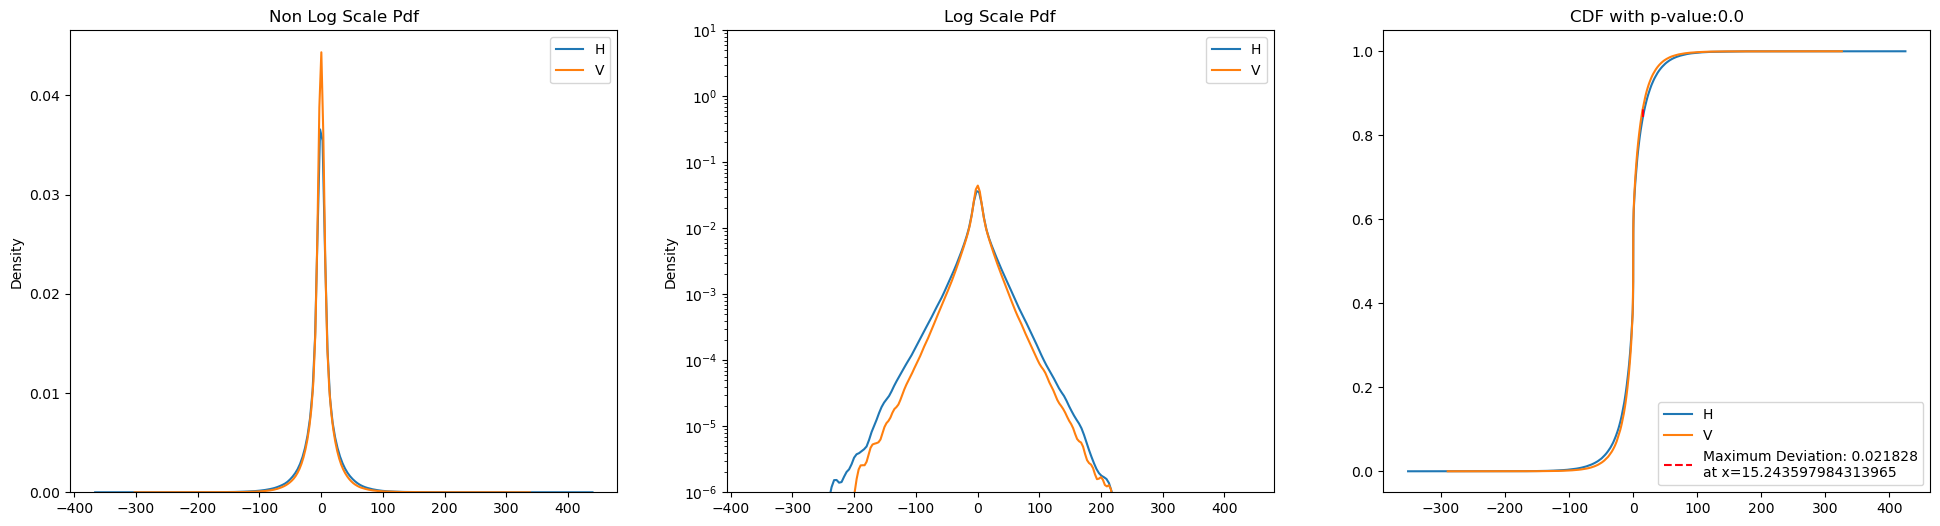

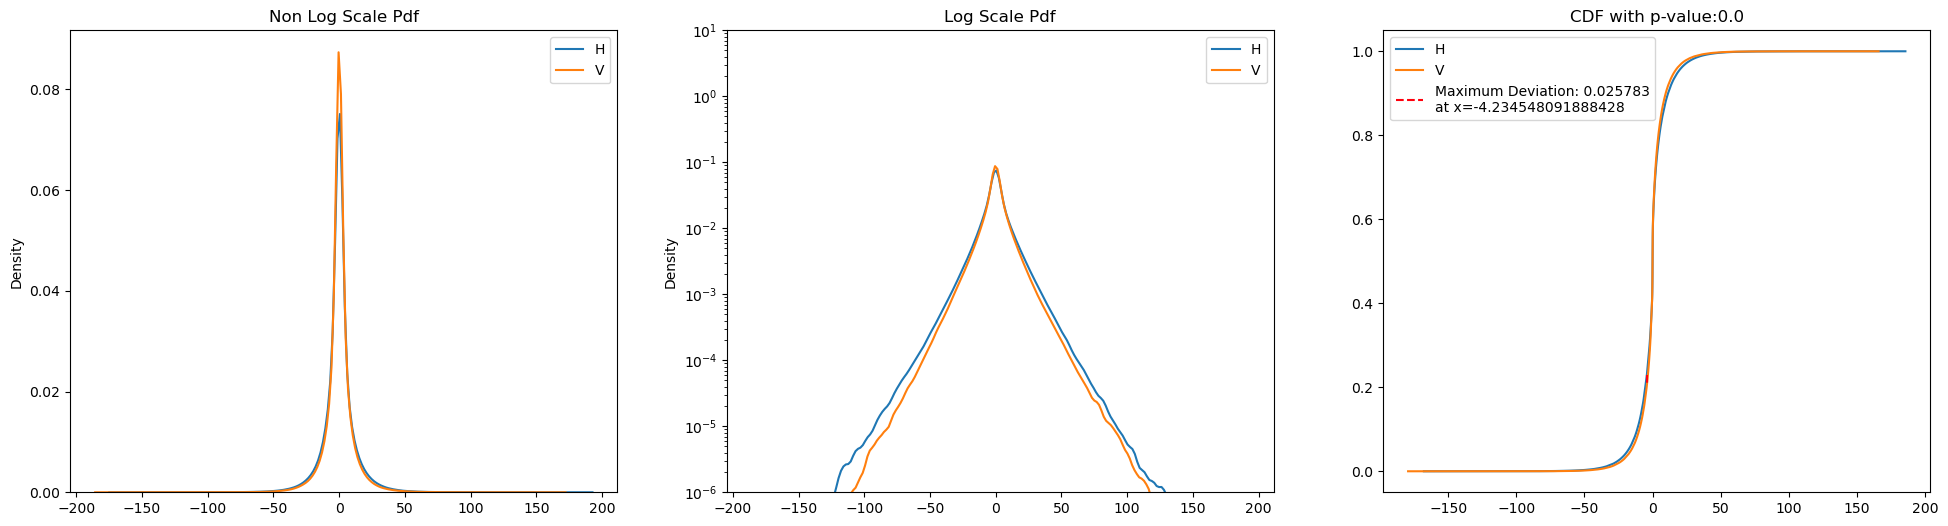

/opt/anaconda3/envs/hbmv/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


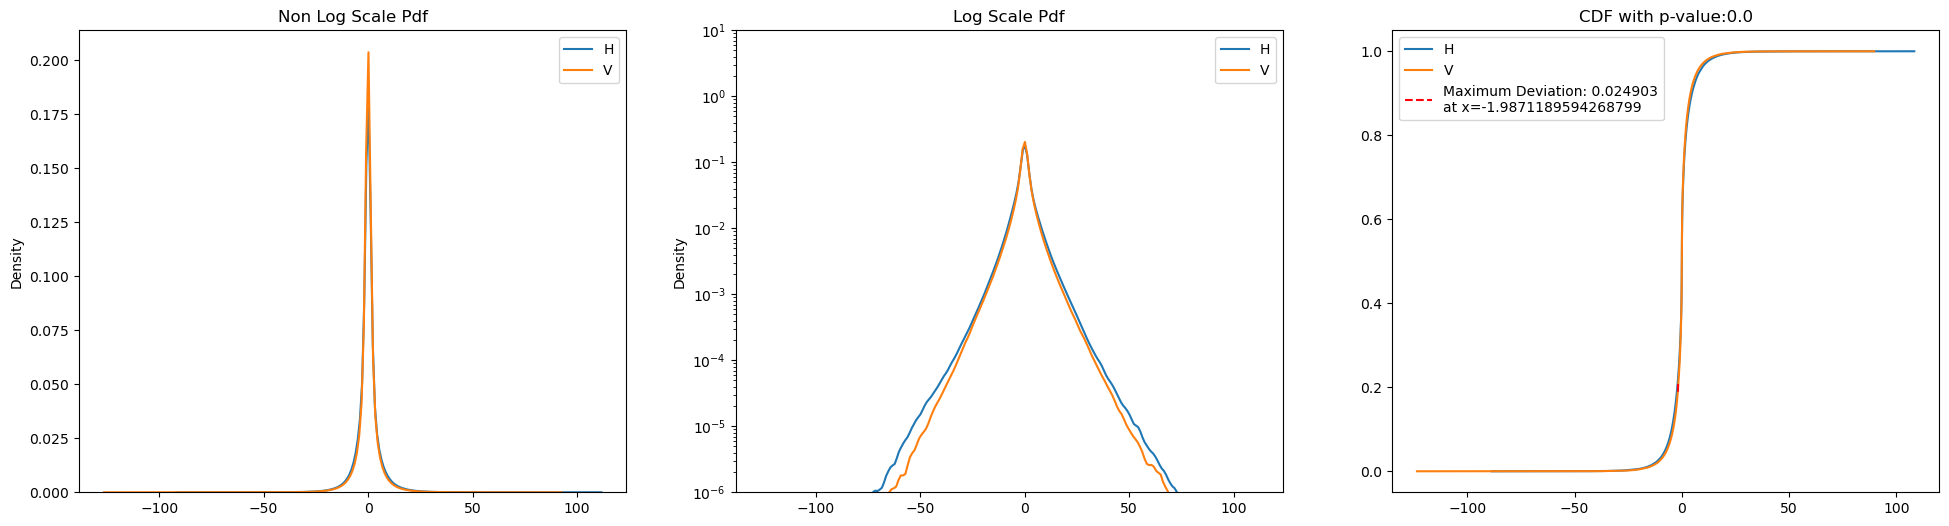

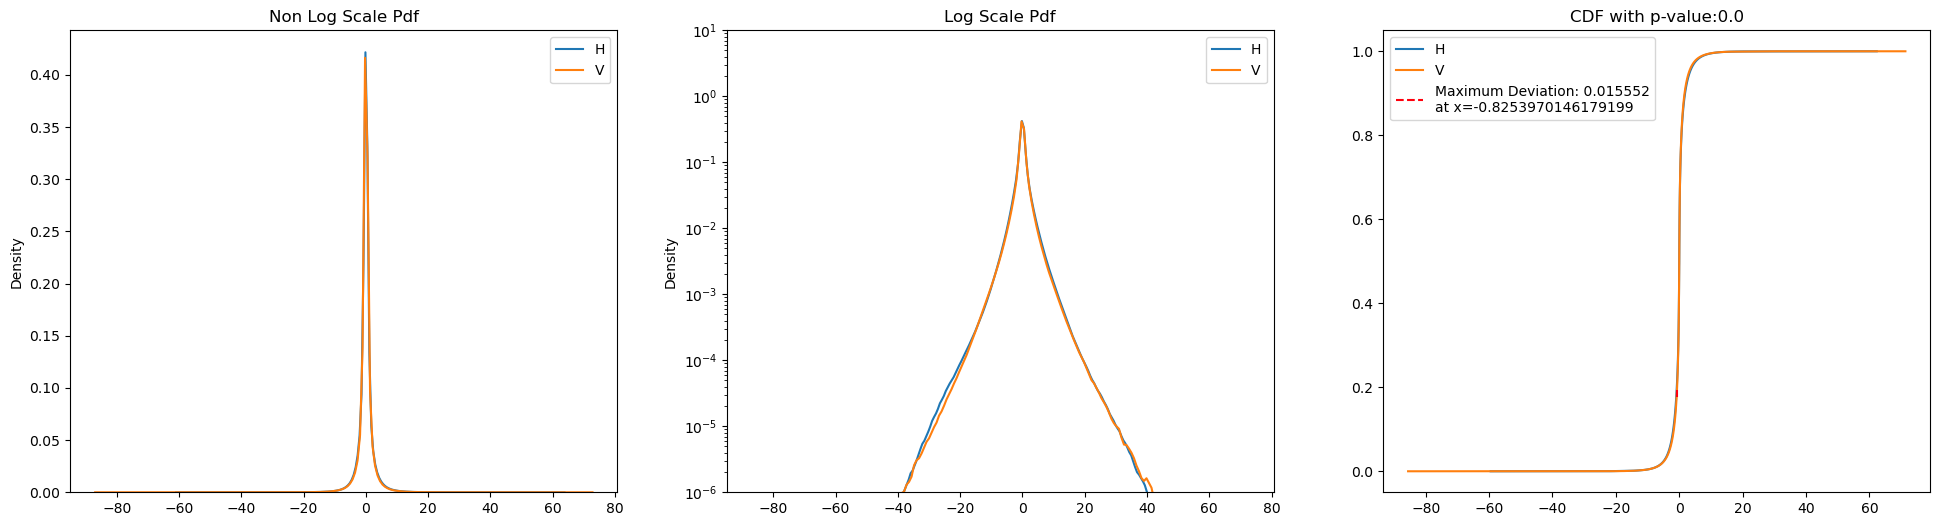

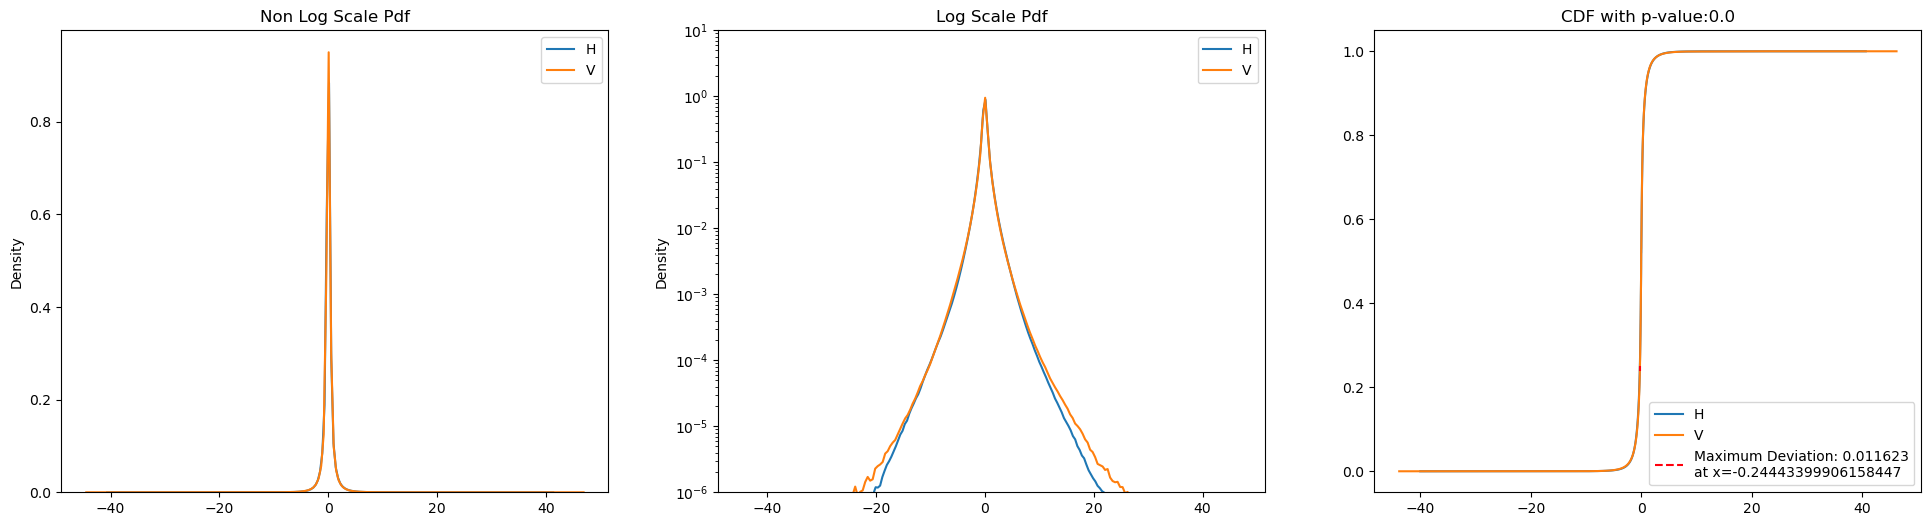

In [10]:
for i in range(2, 10):
    layer_df = green_wv[green_wv["layer"] == i]
    data = layer_df["data"].to_list()
    first_samp = layer_df[layer_df["orientation"] == "H"]["data"].iloc[0]
    second_samp = layer_df[layer_df["orientation"] == "V"]["data"].iloc[0]
    twoSampleComparisonPlots(first_samp, second_samp, samp1name="H", samp2name= "V")

# Blue

In [ ]:
blue_wv = convert_to_wavelet_basis(data_dir, "blue", debug=True, image_opener = batch_image_opener)
blue_wv.head()

9 layers being used


100%|██████████| 3401/3401 [00:13<00:00, 260.19it/s]


channel  layer orientation  \
0    blue      1          L1   
1    blue      2           D   
2    blue      2           H   
3    blue      2           V   
4    blue      3           D   

                                                data  
0  [-361.13245, -419.4332, -173.27464, -189.19713...  
1  [-11.974771, -2.9182355, 18.865269, 9.20256, -...  
2  [-5.2574353, -8.668823, 30.574924, -33.569103,...  
3  [-6.9582634, 1.7784992, -74.50588, -2.6109326,...  
4  [4.9853, 1.2361732, -4.236011, -2.7484634e-07,...

In [12]:
blue_df = pd.DataFrame(columns = ["Layer", "First", "Second", "KS_Stat", "Pvalue"])
for i in range(2, 11):
    layer_df = blue_wv[blue_wv["layer"] == i]
    data = layer_df["data"].to_list()
    names = layer_df["orientation"].to_list()
    ks_df = ksCombinations(data, layer_df["orientation"].to_list(), i).sort_values(["Layer", "KS_Stat"])
    blue_df = pd.concat([blue_df, ks_df], axis = 0)
blue_df

/var/folders/cg/nwm9l18x22zc8_fj15gvgg2h0000gp/T/ipykernel_75210/2515409215.py:7: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  blue_df = pd.concat([blue_df, ks_df], axis = 0)
/var/folders/cg/nwm9l18x22zc8_fj15gvgg2h0000gp/T/ipykernel_75210/2515409215.py:7: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  blue_df = pd.concat([blue_df, ks_df], axis = 0)


Layer First Second   KS_Stat         Pvalue
2     2     H      V  0.037268   1.207617e-08
1     2     D      V  0.067921   9.959752e-28
0     2     D      H  0.073802   1.152617e-32
2     3     H      V  0.014996   9.599849e-06
0     3     D      H  0.101000  4.464419e-242
1     3     D      V  0.111566  1.975261e-295
2     4     H      V  0.017588   8.066747e-23
1     4     D      V  0.074864   0.000000e+00
0     4     D      H  0.085161   0.000000e+00
2     5     H      V  0.018005   2.313392e-81
1     5     D      V  0.066479   0.000000e+00
0     5     D      H  0.082703   0.000000e+00
2     6     H      V  0.022736   0.000000e+00
1     6     D      V  0.062217   0.000000e+00
0     6     D      H  0.084768   0.000000e+00
2     7     H      V  0.023378   0.000000e+00
1     7     D      V  0.055803   0.000000e+00
0     7     D      H  0.078916   0.000000e+00
2     8     H      V  0.015263   0.000000e+00
1     8     D      V  0.047404   0.000000e+00
0     8     D      H  0.062567   0.000000e+00
2     9     H      V  0.012190   0.000000e+00
1     9     D      V  0.043605   0.000000e+00
0     9     D      H  0.052111   0.000000e+00

/opt/anaconda3/envs/hbmv/lib/python3.11/site-packages/IPython/core/events.py:82: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)


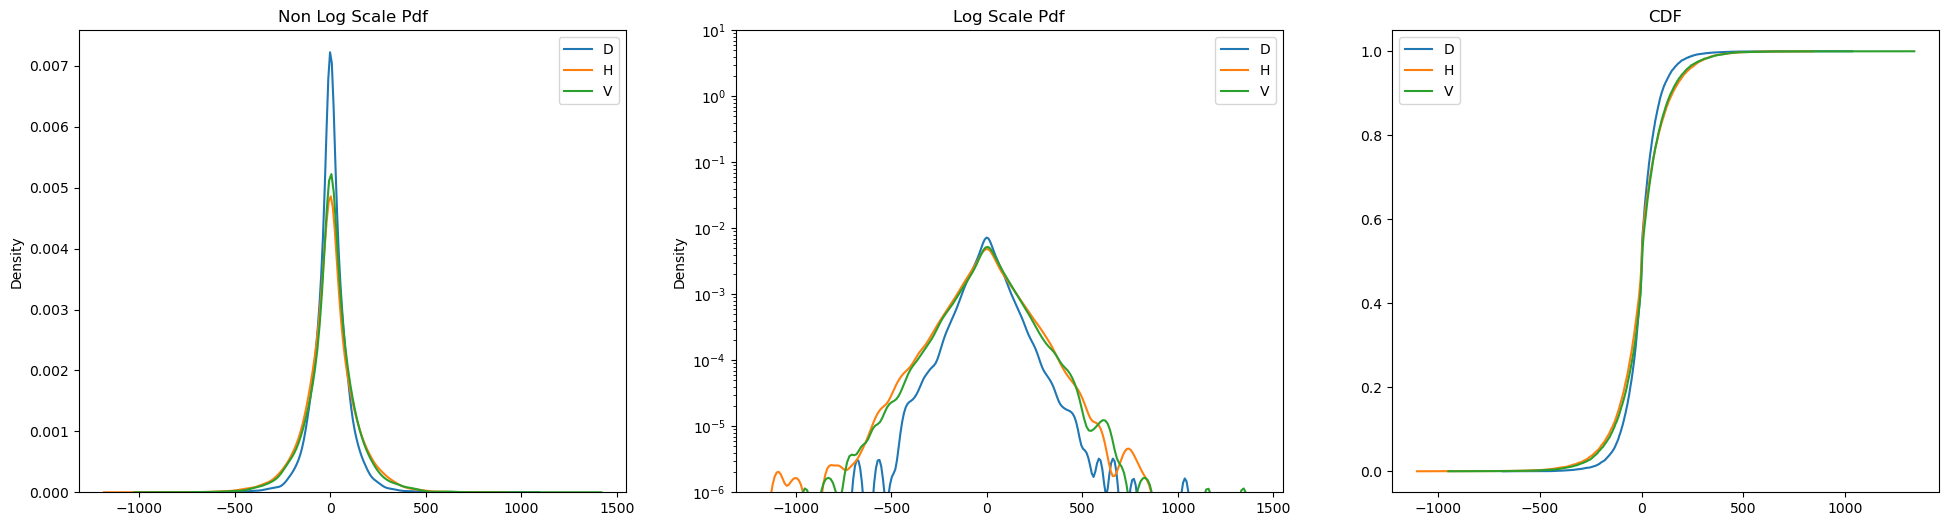

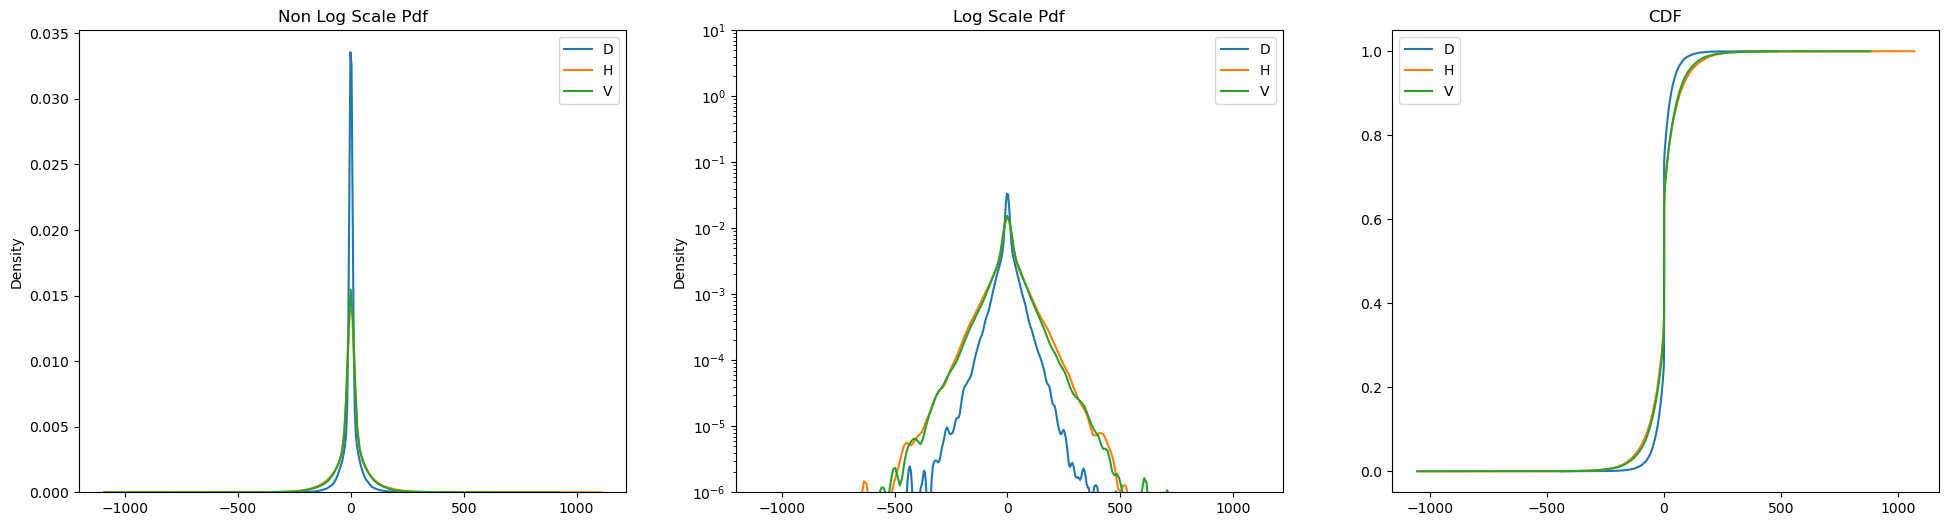

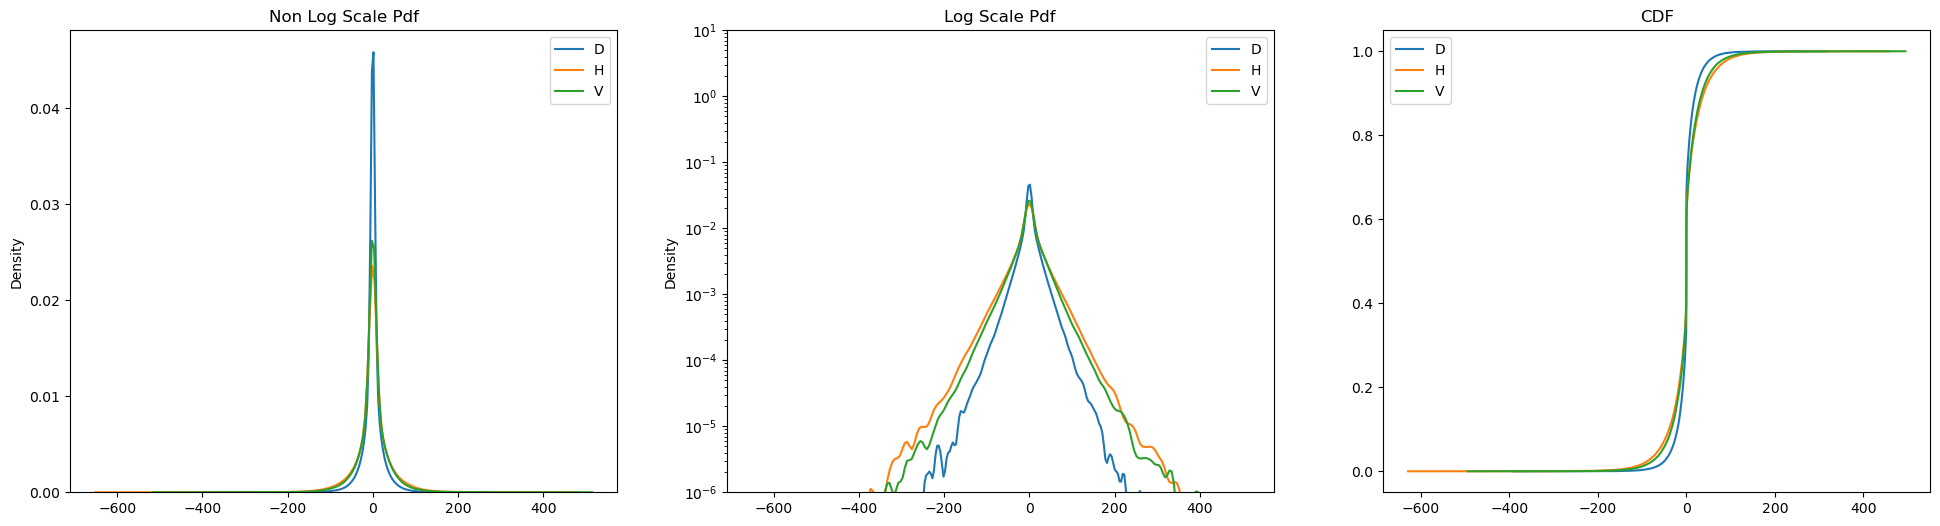

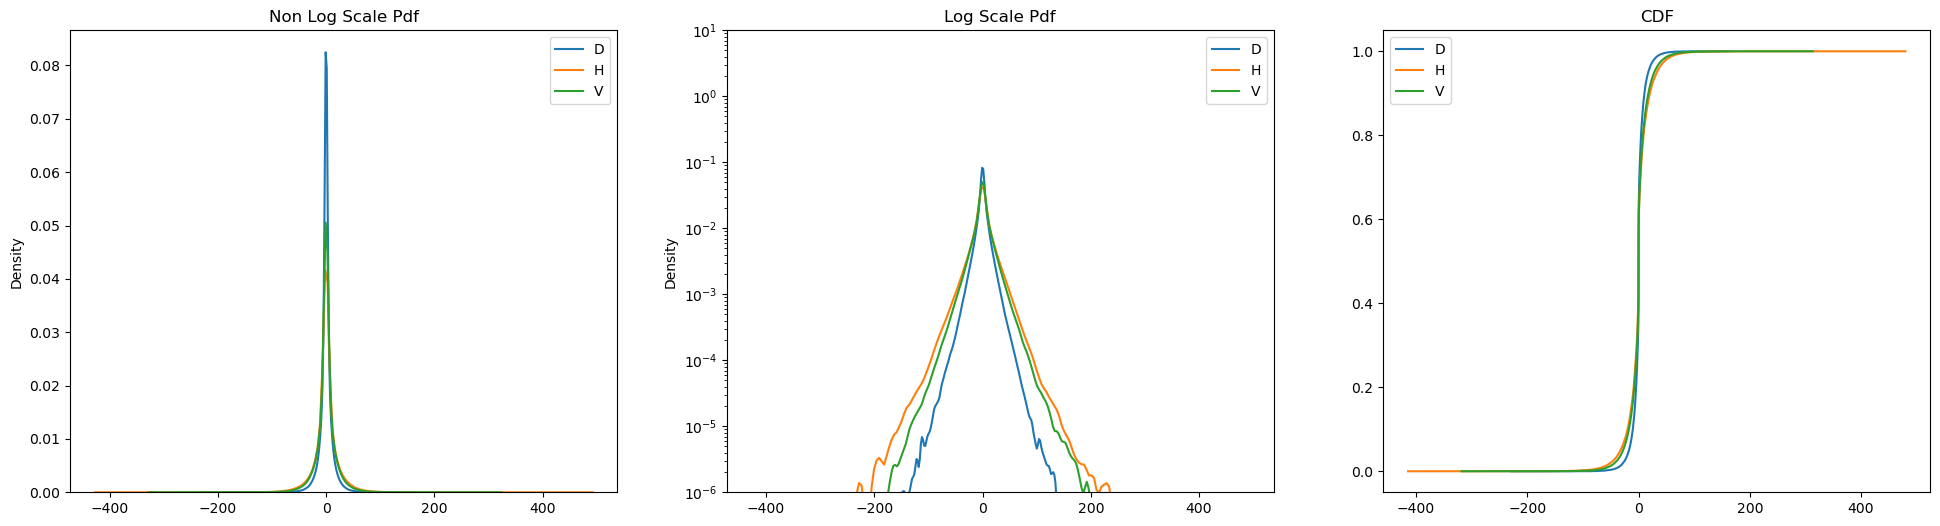

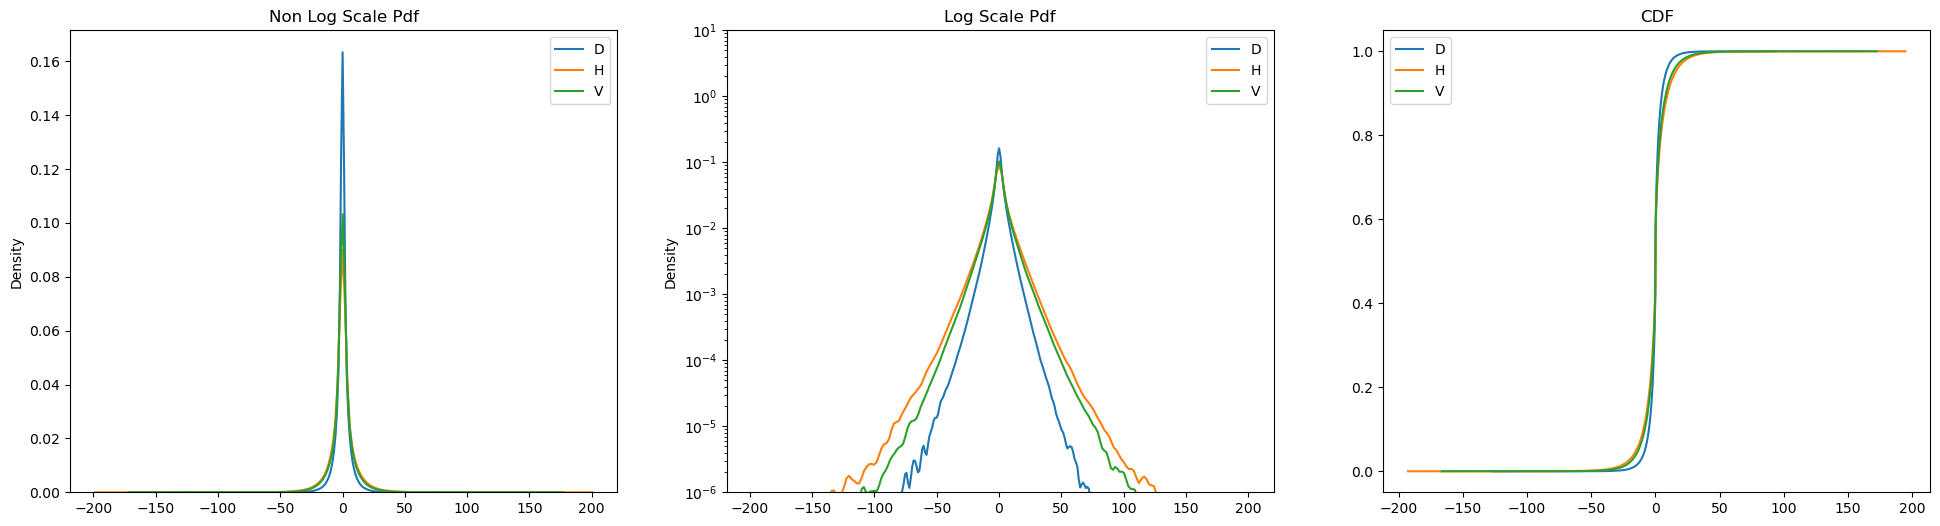

/opt/anaconda3/envs/hbmv/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


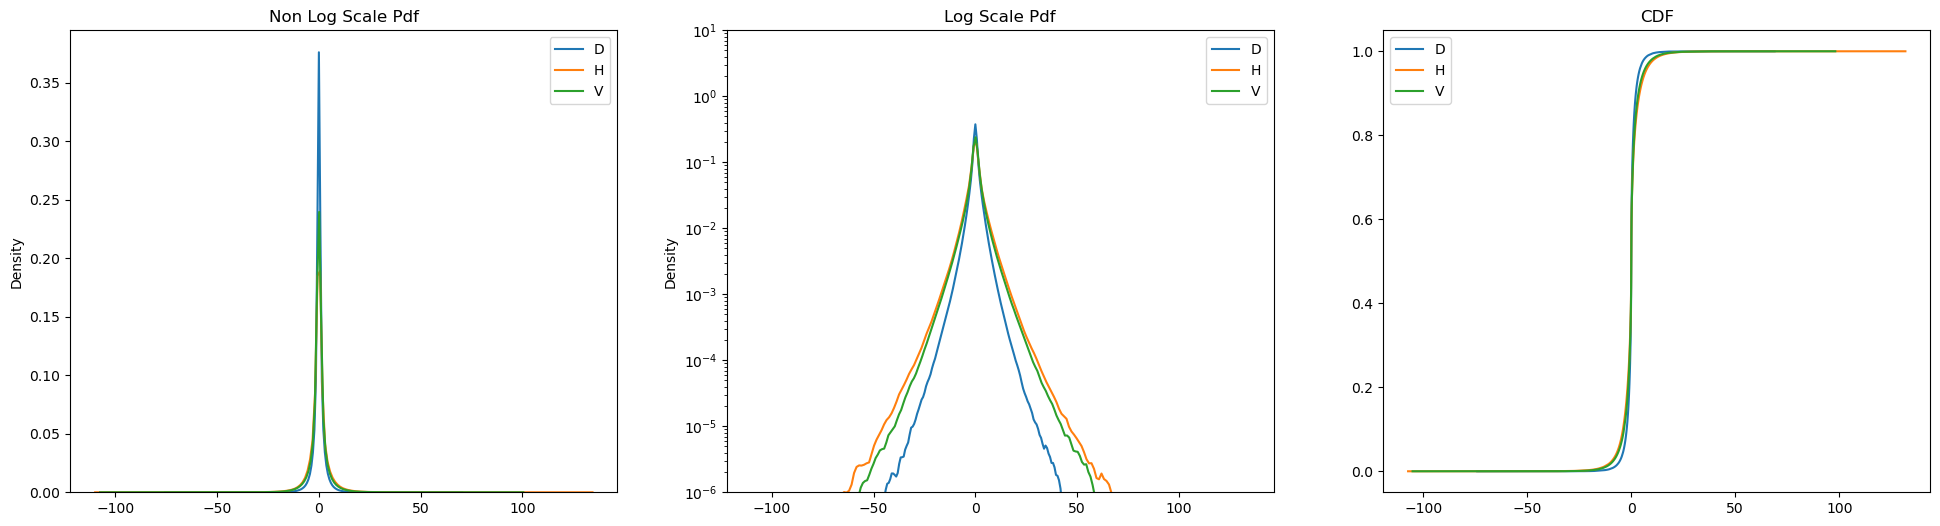

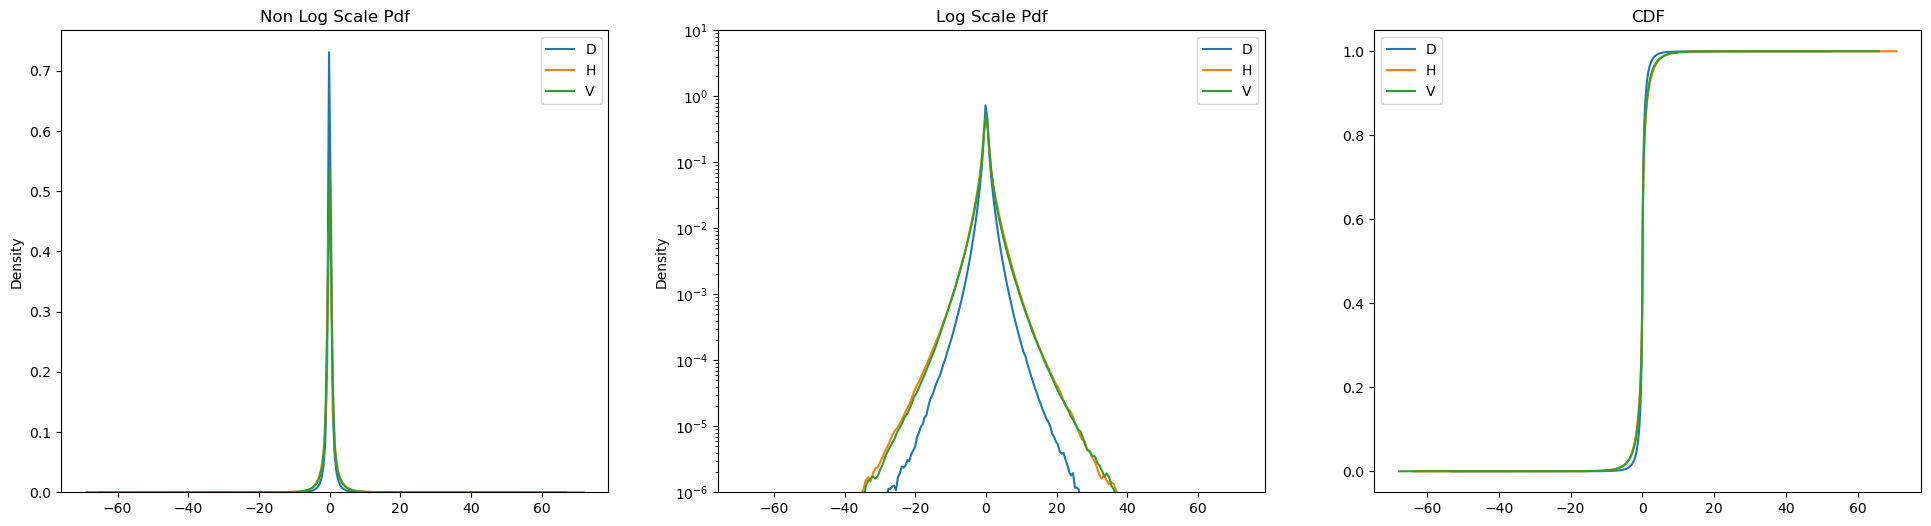

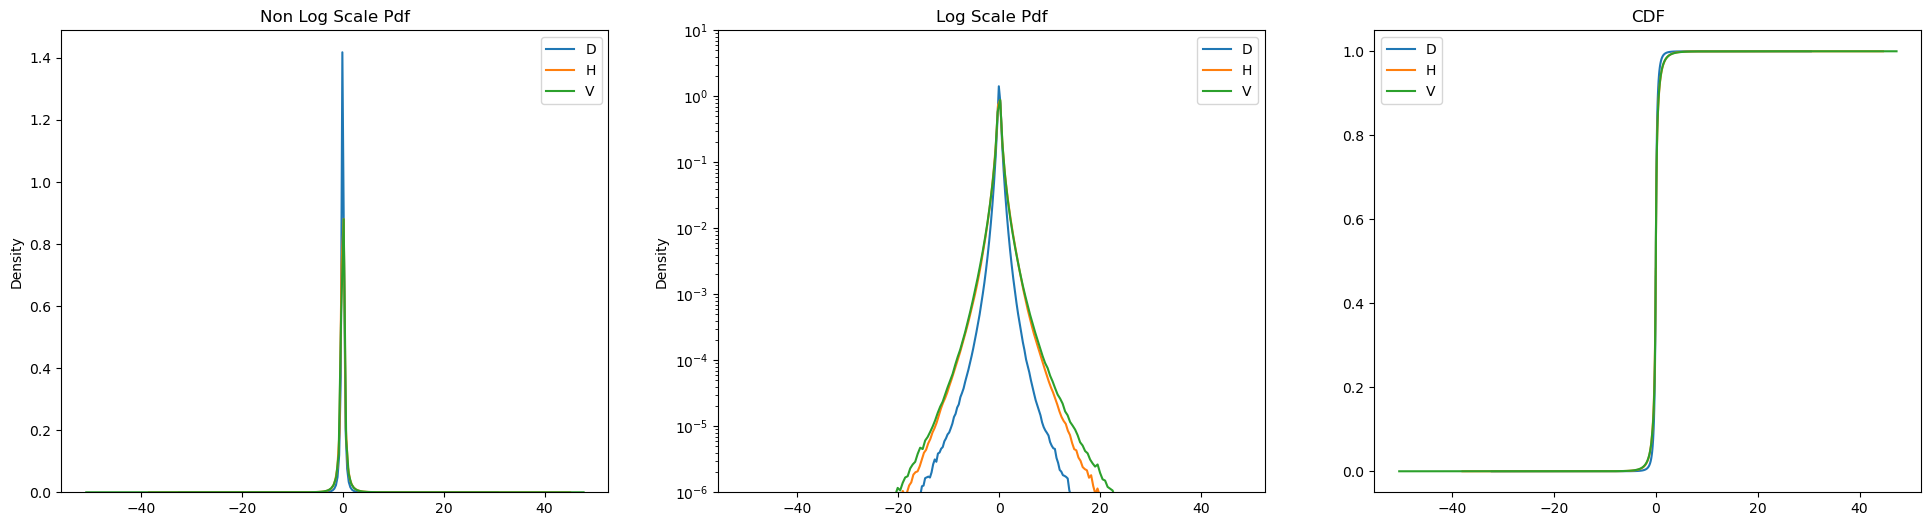

In [13]:
for i in range(2, 10):
    layer_df = blue_wv[blue_wv["layer"] == i]
    data = layer_df["data"].to_list()
    multiSampleComparisonPlots(data,  layer_df["orientation"].to_list(), bw =0.2)


/opt/anaconda3/envs/hbmv/lib/python3.11/site-packages/IPython/core/events.py:82: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)


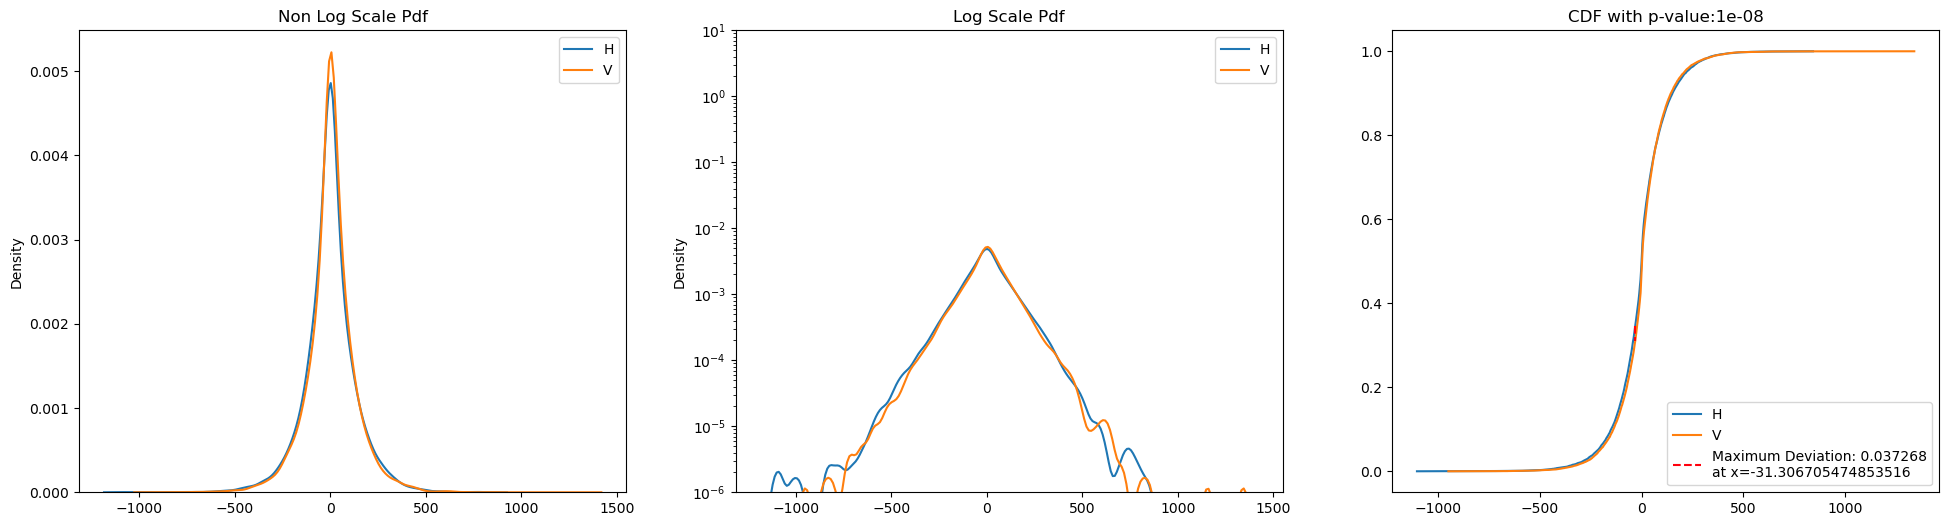

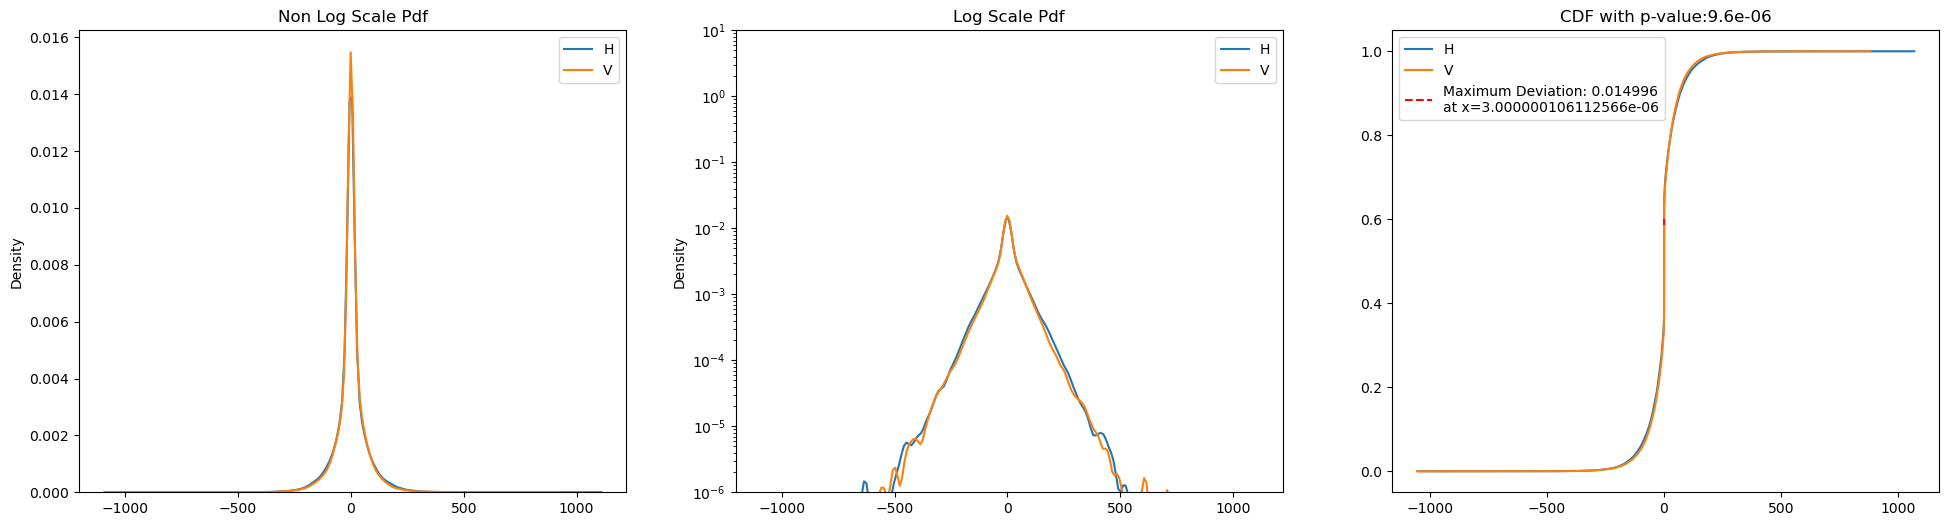

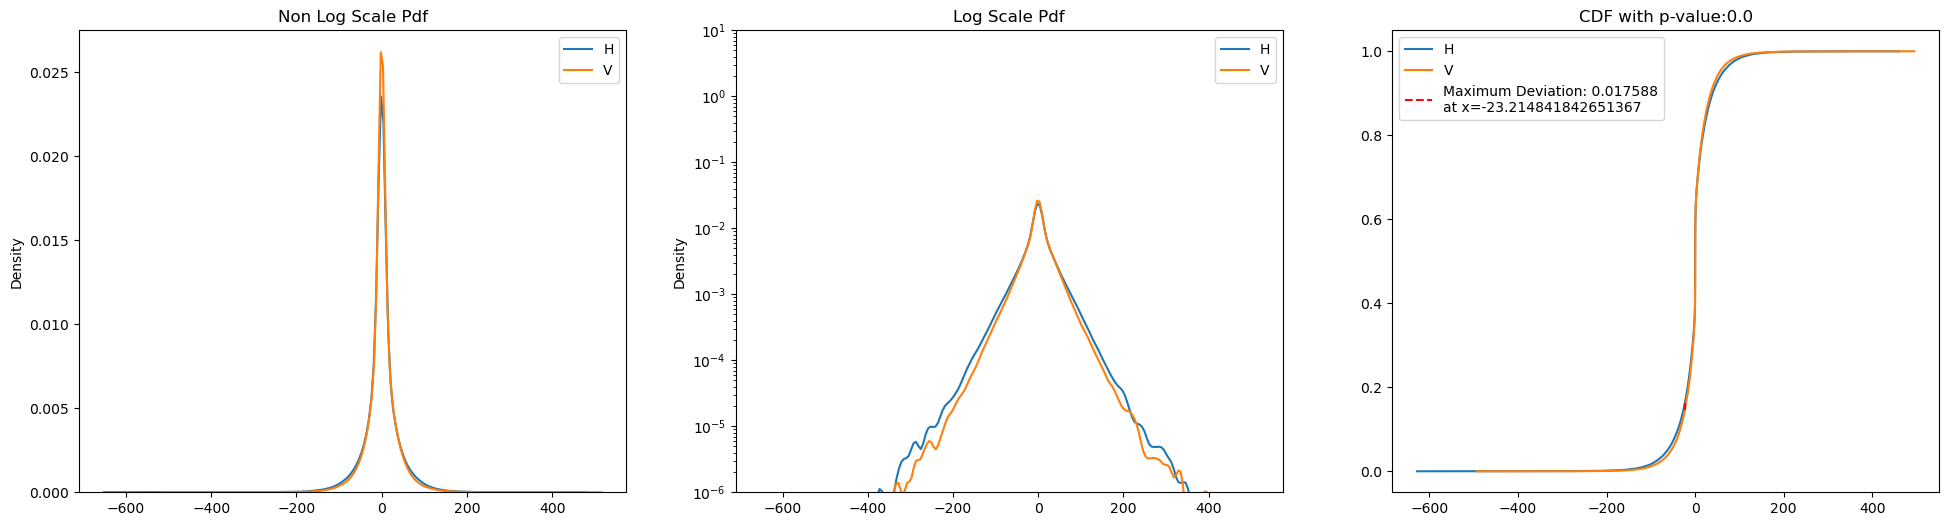

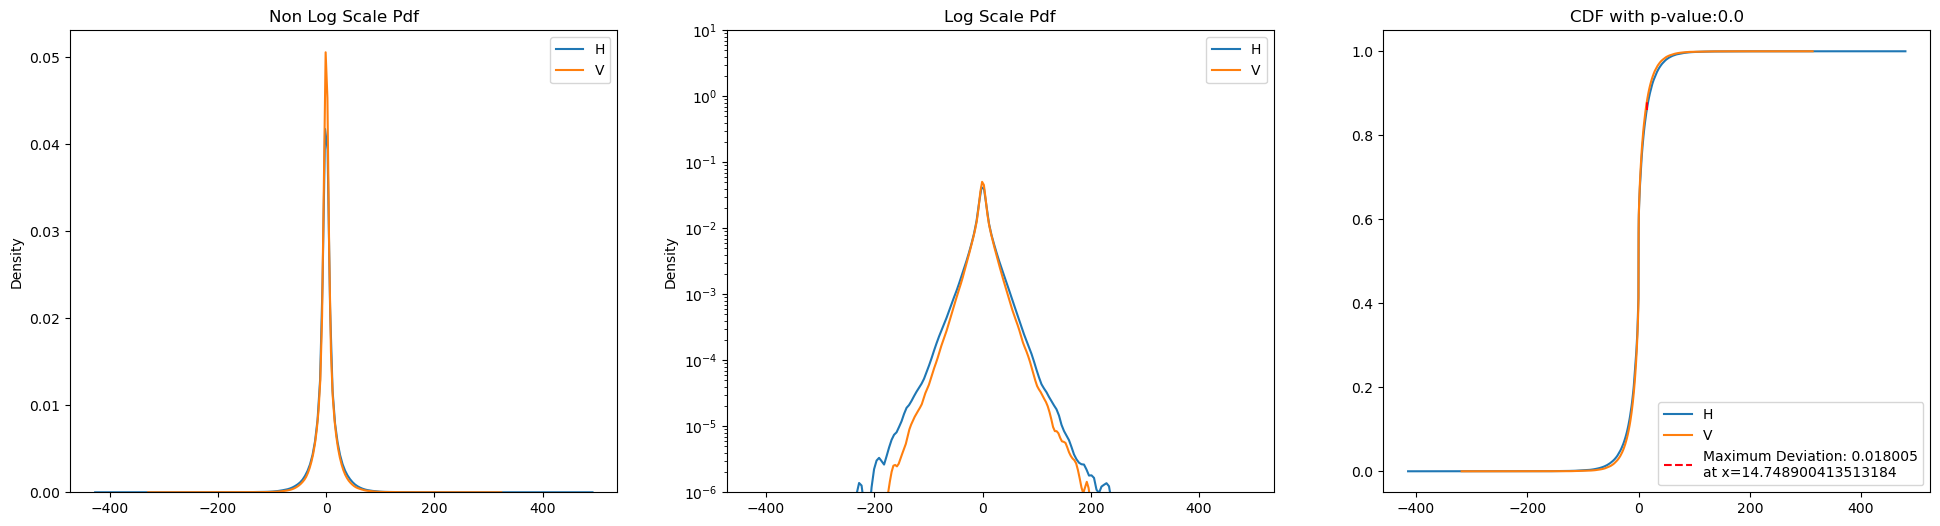

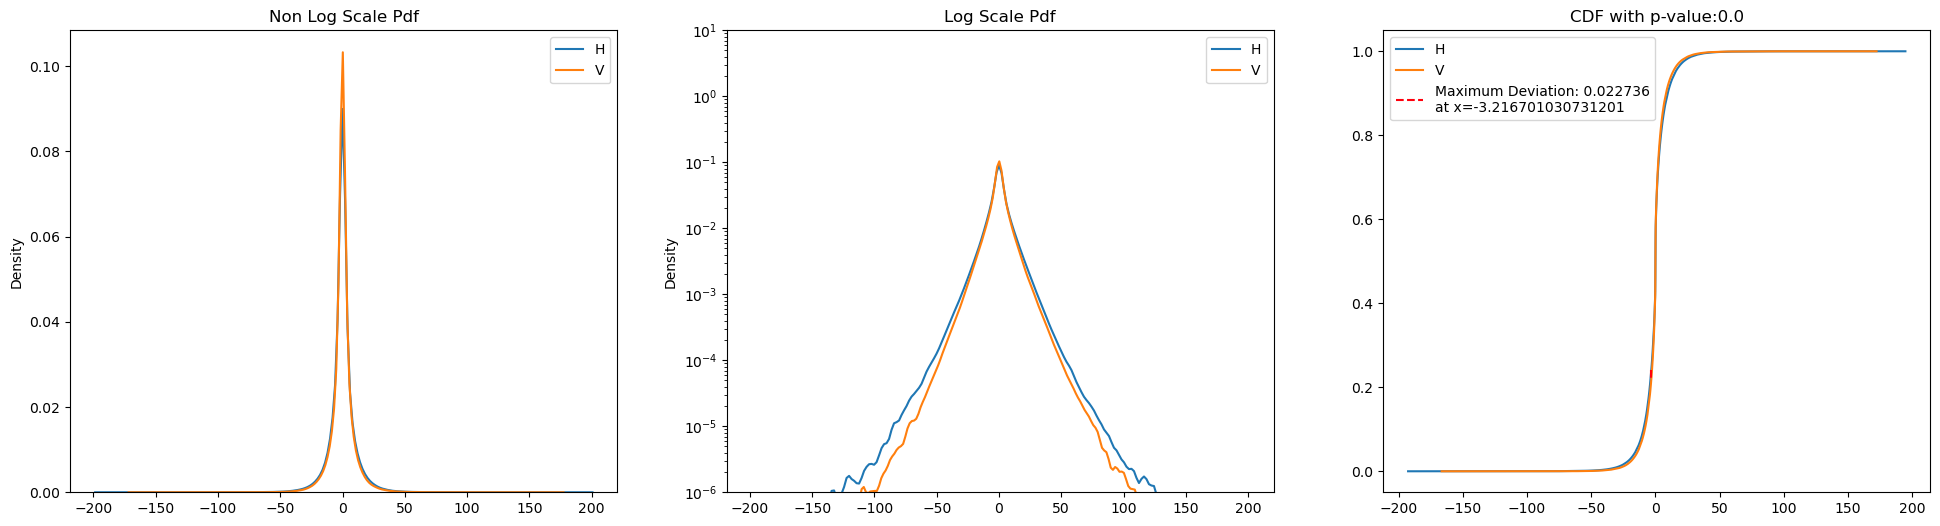

/opt/anaconda3/envs/hbmv/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


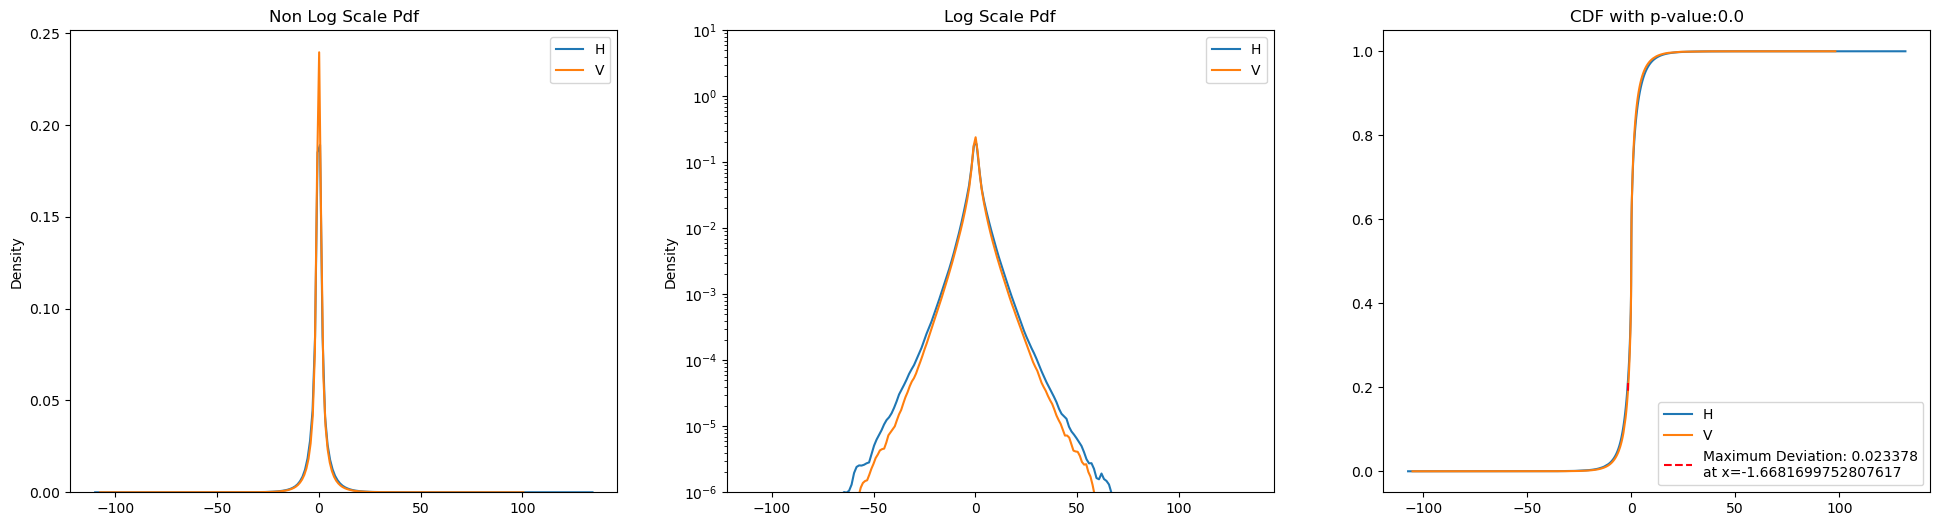

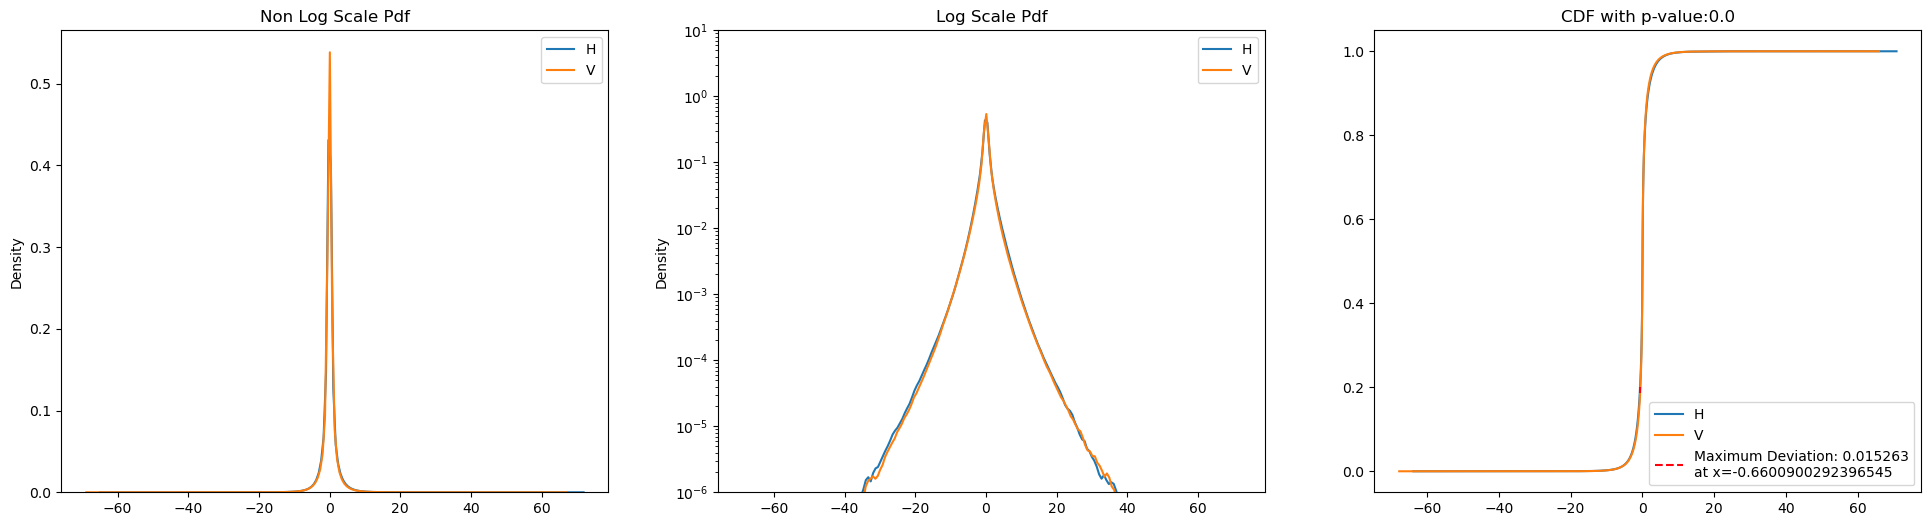

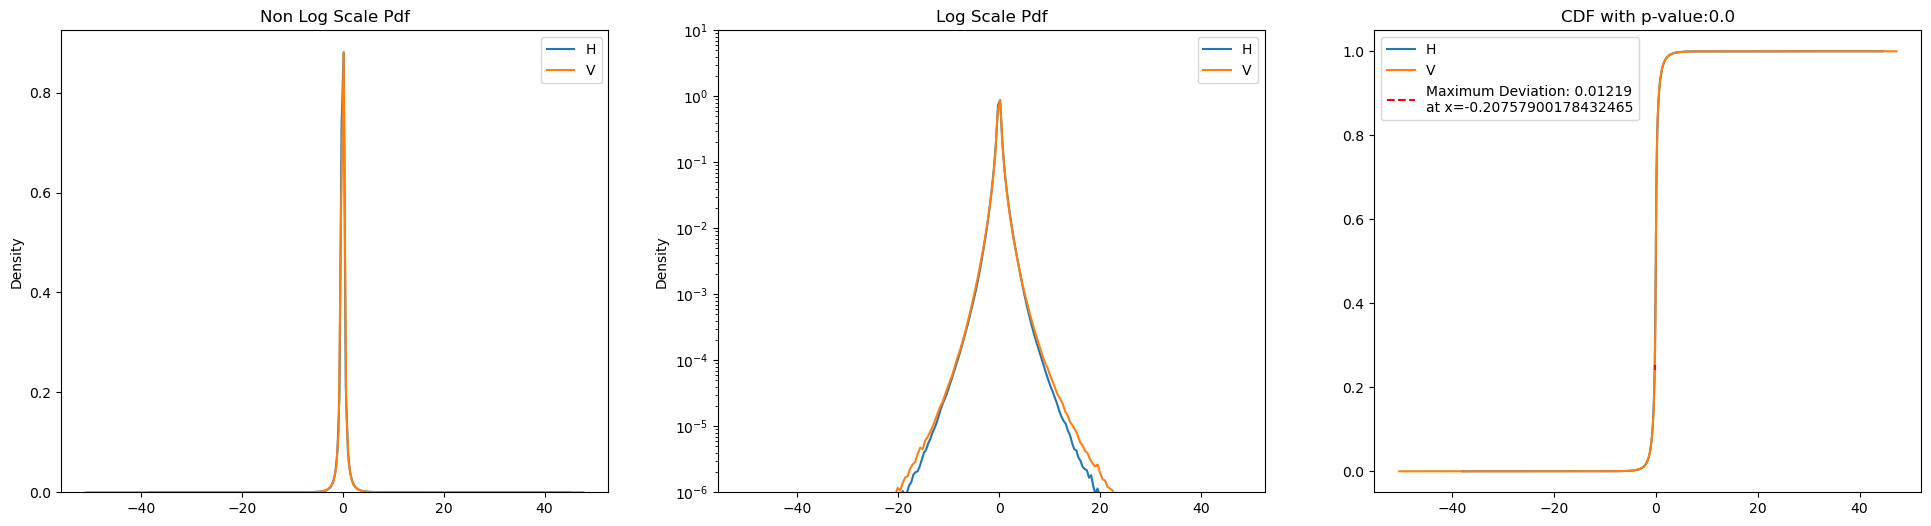

In [14]:
for i in range(2, 10):
    layer_df = blue_wv[blue_wv["layer"] == i]
    data = layer_df["data"].to_list()
    first_samp = layer_df[layer_df["orientation"] == "H"]["data"].iloc[0]
    second_samp = layer_df[layer_df["orientation"] == "V"]["data"].iloc[0]
    twoSampleComparisonPlots(first_samp, second_samp, samp1name="H", samp2name= "V")

# Gray

In [ ]:
gray_wv = convert_to_wavelet_basis(data_dir, "gray", debug=True, image_opener = batch_image_opener)
gray_wv.head()

9 layers being used


100%|██████████| 3401/3401 [00:21<00:00, 159.62it/s]


channel  layer orientation  \
0    gray      1          L1   
1    gray      2           D   
2    gray      2           H   
3    gray      2           V   
4    gray      3           D   

                                                data  
0  [-372.15462396419593, -446.48967403603024, -15...  
1  [-11.216330078354712, -4.197303143703072, 21.7...  
2  [-11.355308667362408, -11.797163014680162, 69....  
3  [-4.655338206871508, 0.7961775032794544, -124....  
4  [3.4507869283298023, 1.4053817386343572, -7.82...

In [16]:
gray_df = pd.DataFrame(columns = ["Layer", "First", "Second", "KS_Stat", "Pvalue"])
for i in range(2, 11):
    layer_df = gray_wv[gray_wv["layer"] == i]
    data = layer_df["data"].to_list()
    names = layer_df["orientation"].to_list()
    ks_df = ksCombinations(data, layer_df["orientation"].to_list(), i).sort_values(["Layer", "KS_Stat"])
    gray_df = pd.concat([gray_df, ks_df], axis = 0)
gray_df

/var/folders/cg/nwm9l18x22zc8_fj15gvgg2h0000gp/T/ipykernel_75210/3441235349.py:7: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  gray_df = pd.concat([gray_df, ks_df], axis = 0)
/var/folders/cg/nwm9l18x22zc8_fj15gvgg2h0000gp/T/ipykernel_75210/3441235349.py:7: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  gray_df = pd.concat([gray_df, ks_df], axis = 0)


Layer First Second   KS_Stat         Pvalue
2     2     H      V  0.038886   2.256327e-09
1     2     D      V  0.066672   9.869293e-27
0     2     D      H  0.075272   5.797613e-34
2     3     H      V  0.012441   4.359180e-04
0     3     D      H  0.105006  1.127554e-261
1     3     D      V  0.113864  9.713069e-308
2     4     H      V  0.019832   6.716937e-29
1     4     D      V  0.076052   0.000000e+00
0     4     D      H  0.084015   0.000000e+00
2     5     H      V  0.020814  1.408132e-108
1     5     D      V  0.063107   0.000000e+00
0     5     D      H  0.081250   0.000000e+00
2     6     H      V  0.024545   0.000000e+00
1     6     D      V  0.058743   0.000000e+00
0     6     D      H  0.083197   0.000000e+00
2     7     H      V  0.023853   0.000000e+00
1     7     D      V  0.053489   0.000000e+00
0     7     D      H  0.077177   0.000000e+00
2     8     H      V  0.015074   0.000000e+00
1     8     D      V  0.046014   0.000000e+00
0     8     D      H  0.061003   0.000000e+00
2     9     H      V  0.011684   0.000000e+00
1     9     D      V  0.043160   0.000000e+00
0     9     D      H  0.051585   0.000000e+00

/opt/anaconda3/envs/hbmv/lib/python3.11/site-packages/IPython/core/events.py:82: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)


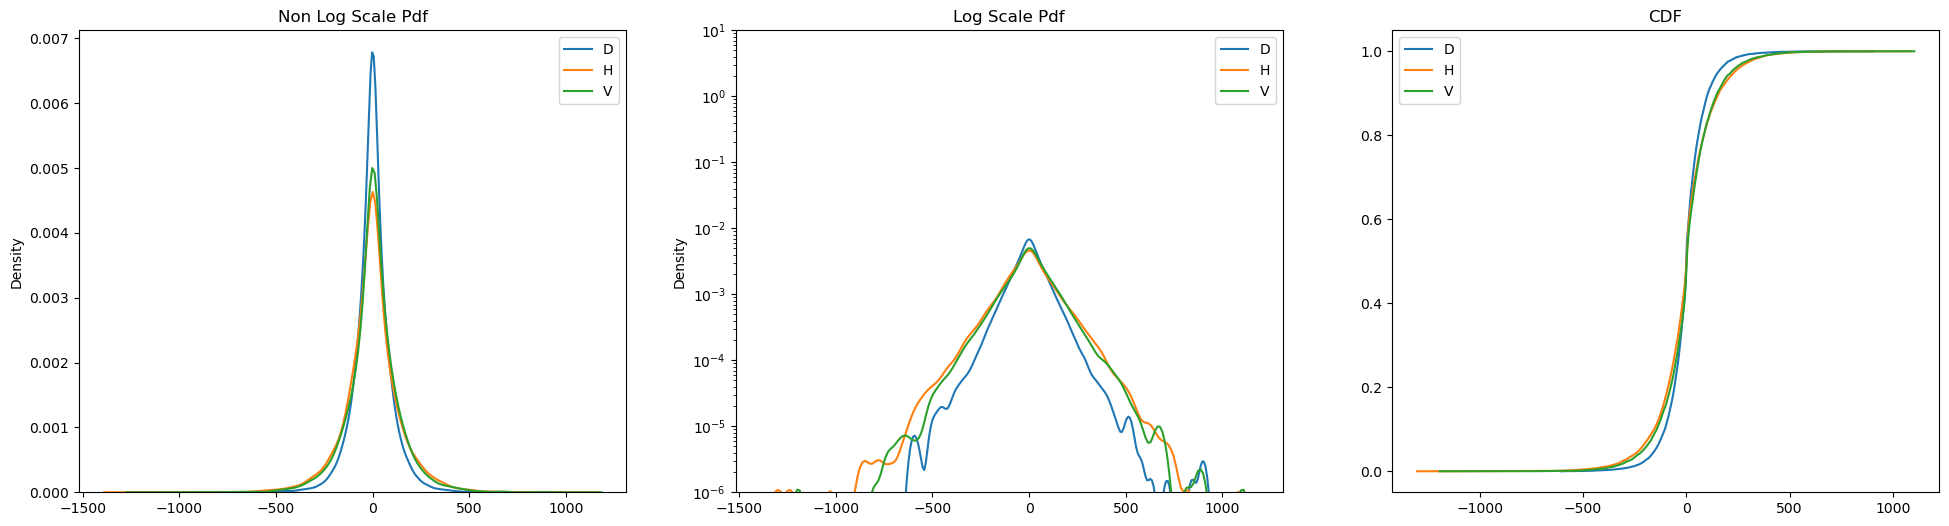

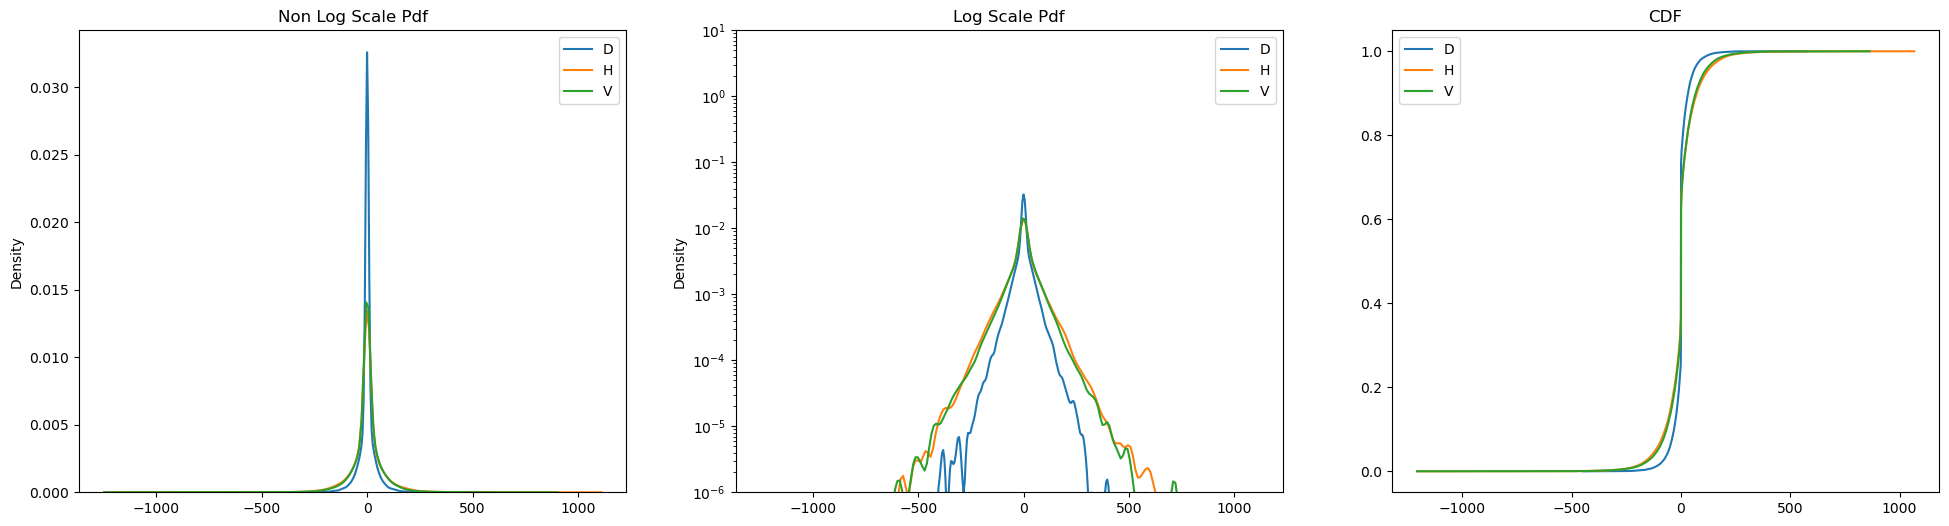

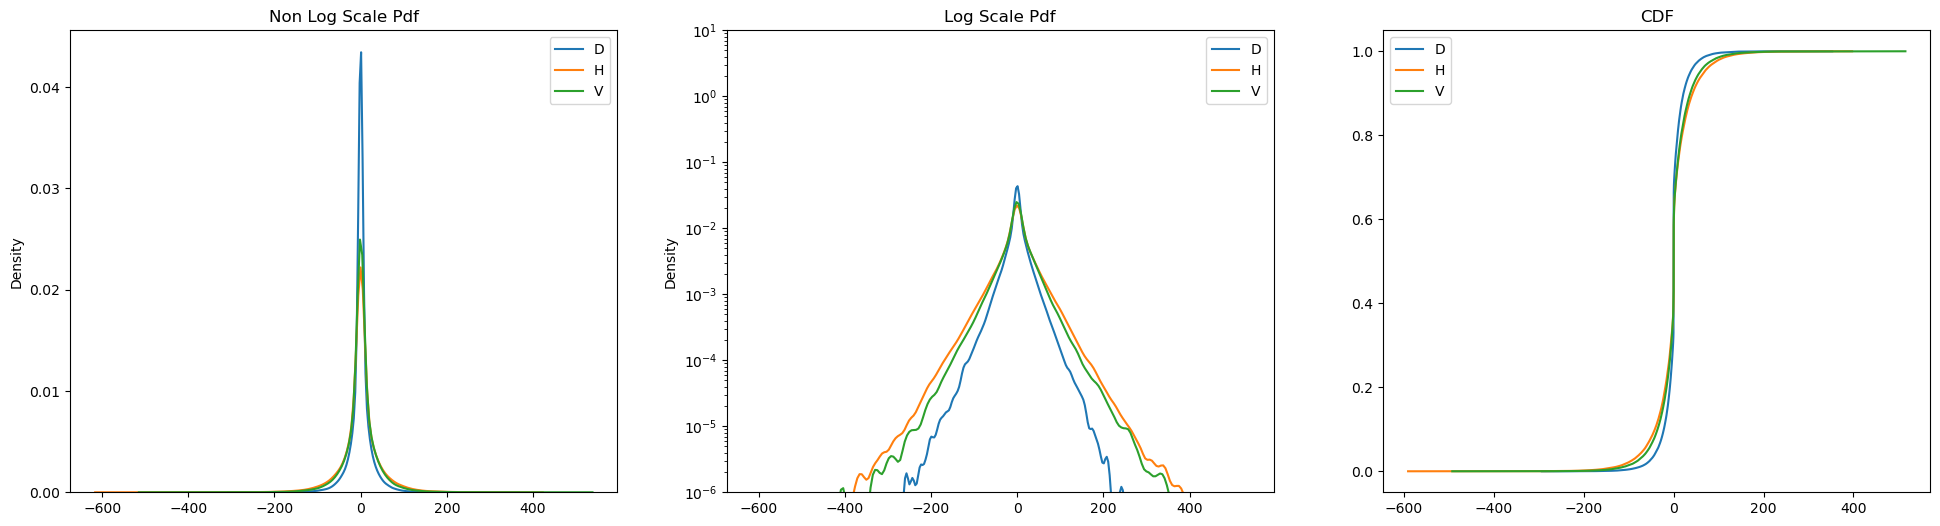

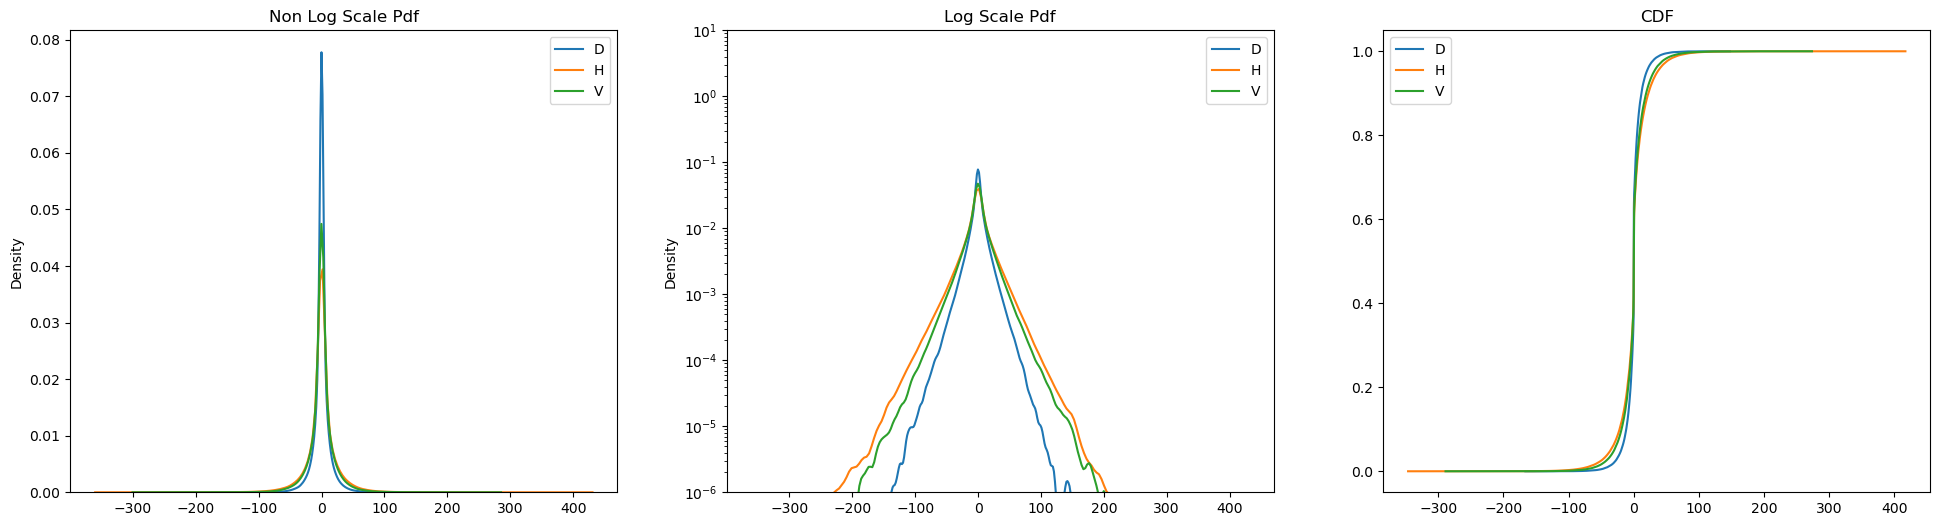

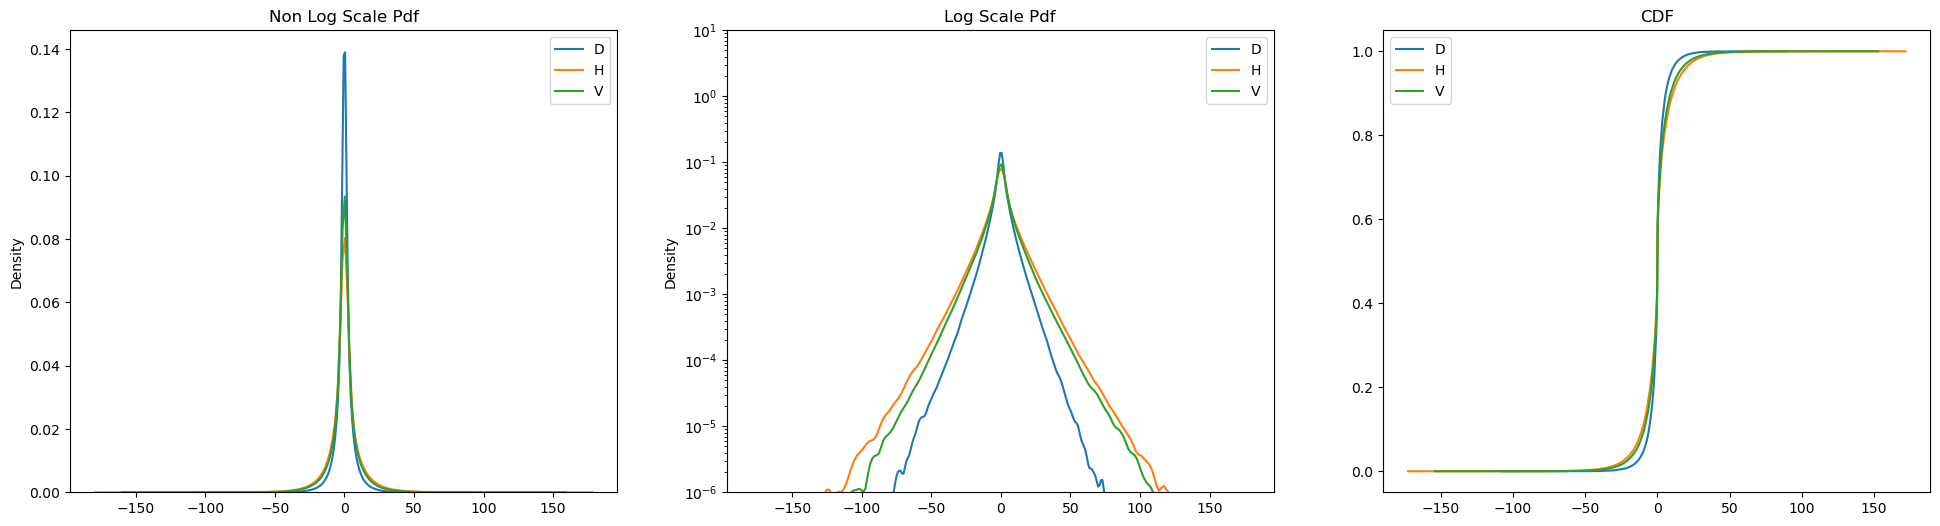

/opt/anaconda3/envs/hbmv/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


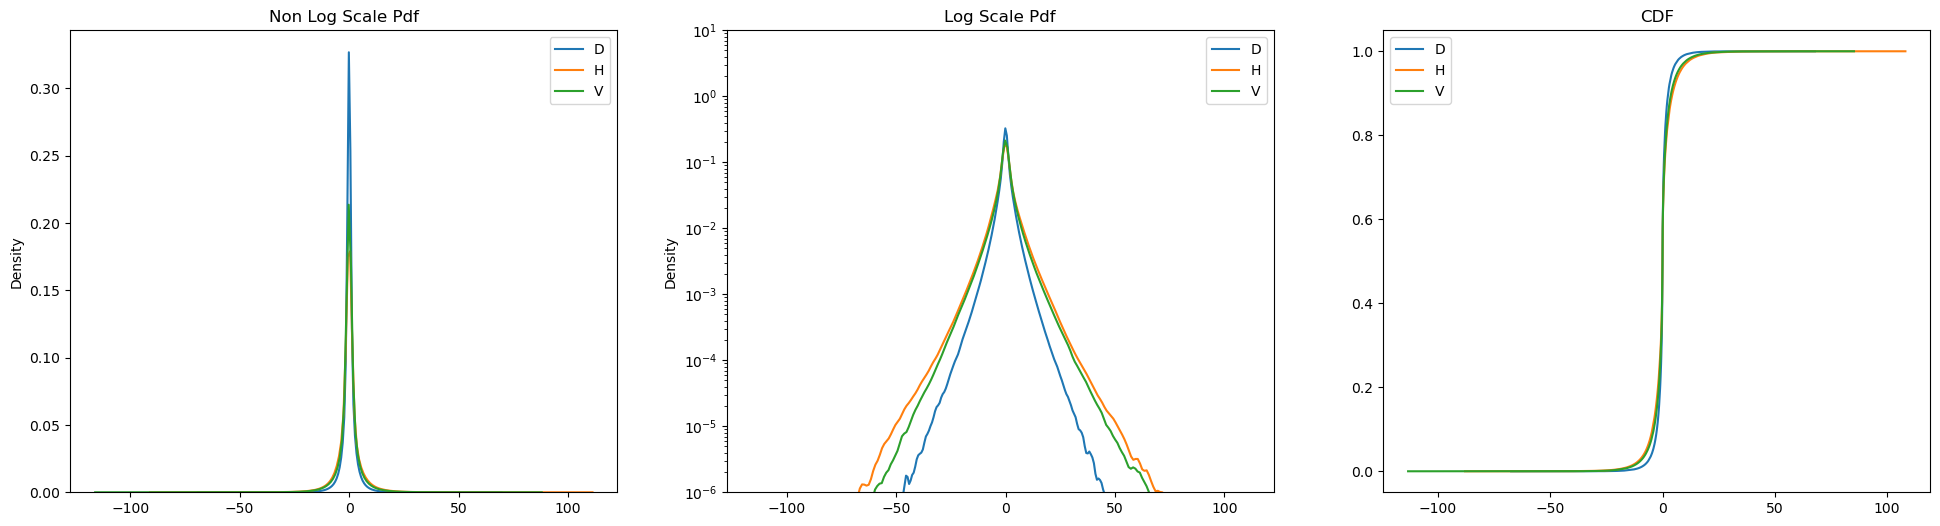

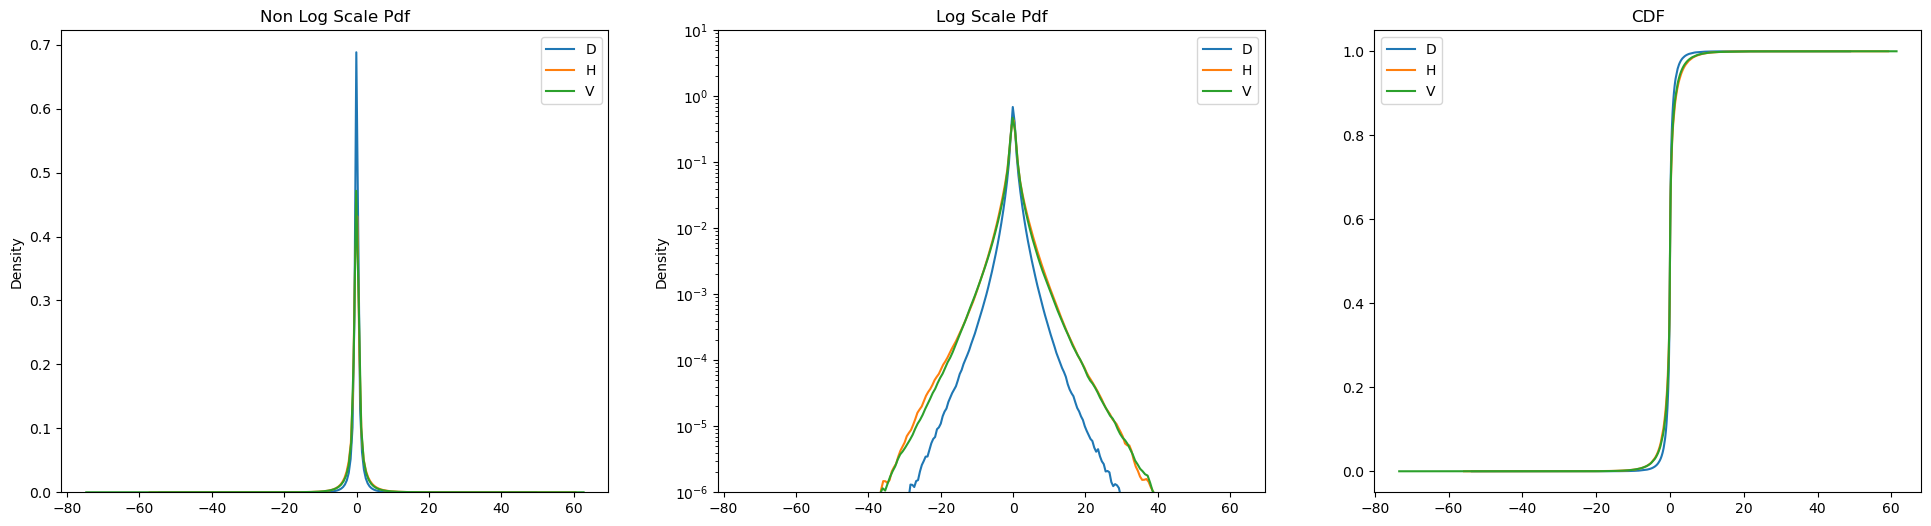

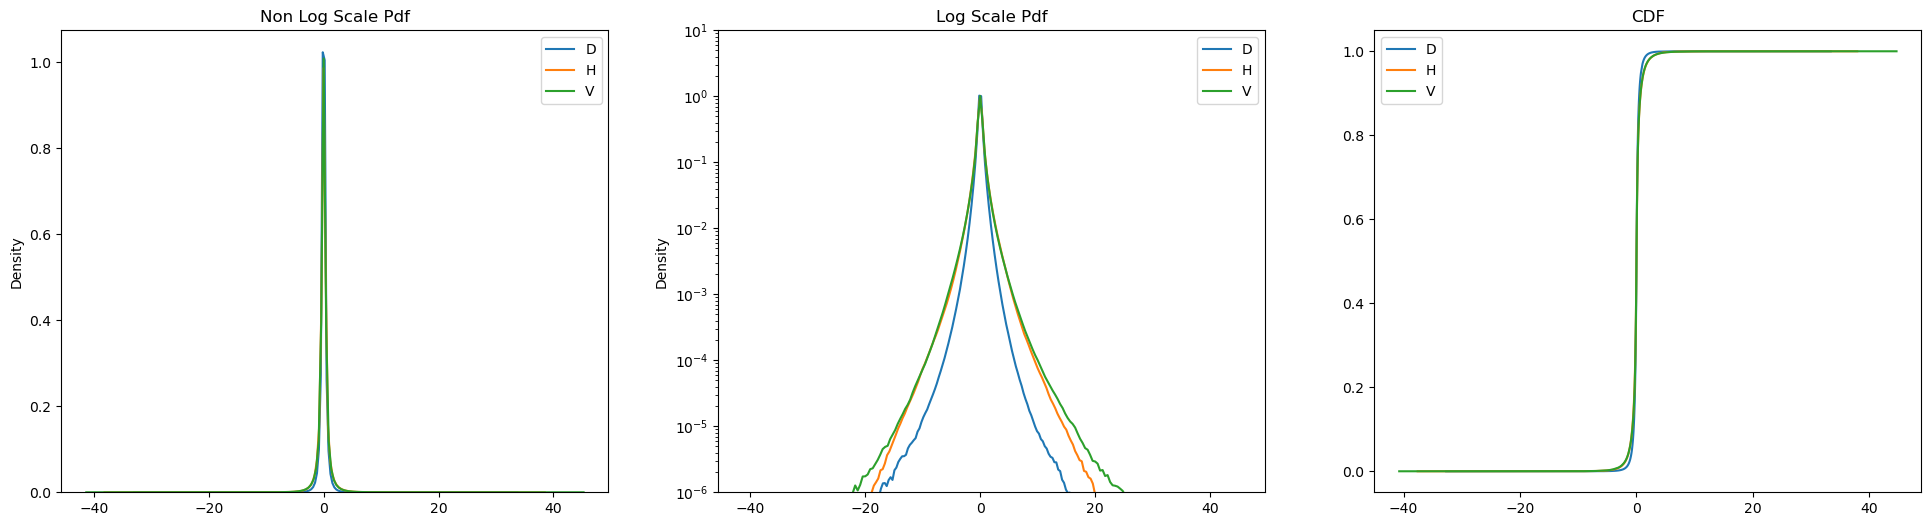

In [17]:
for i in range(2, 10):
    layer_df = gray_wv[gray_wv["layer"] == i]
    data = layer_df["data"].to_list()
    multiSampleComparisonPlots(data,  layer_df["orientation"].to_list(), bw =0.2)

/opt/anaconda3/envs/hbmv/lib/python3.11/site-packages/IPython/core/events.py:82: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)


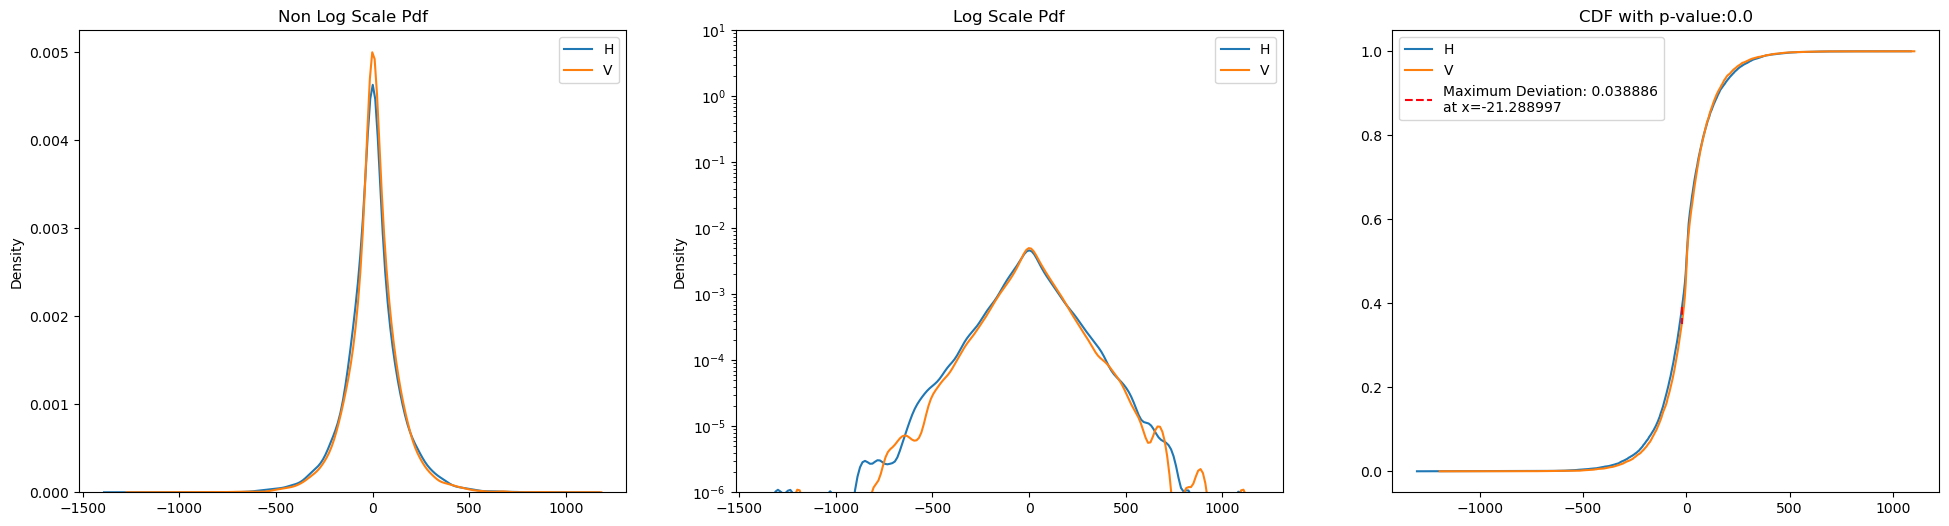

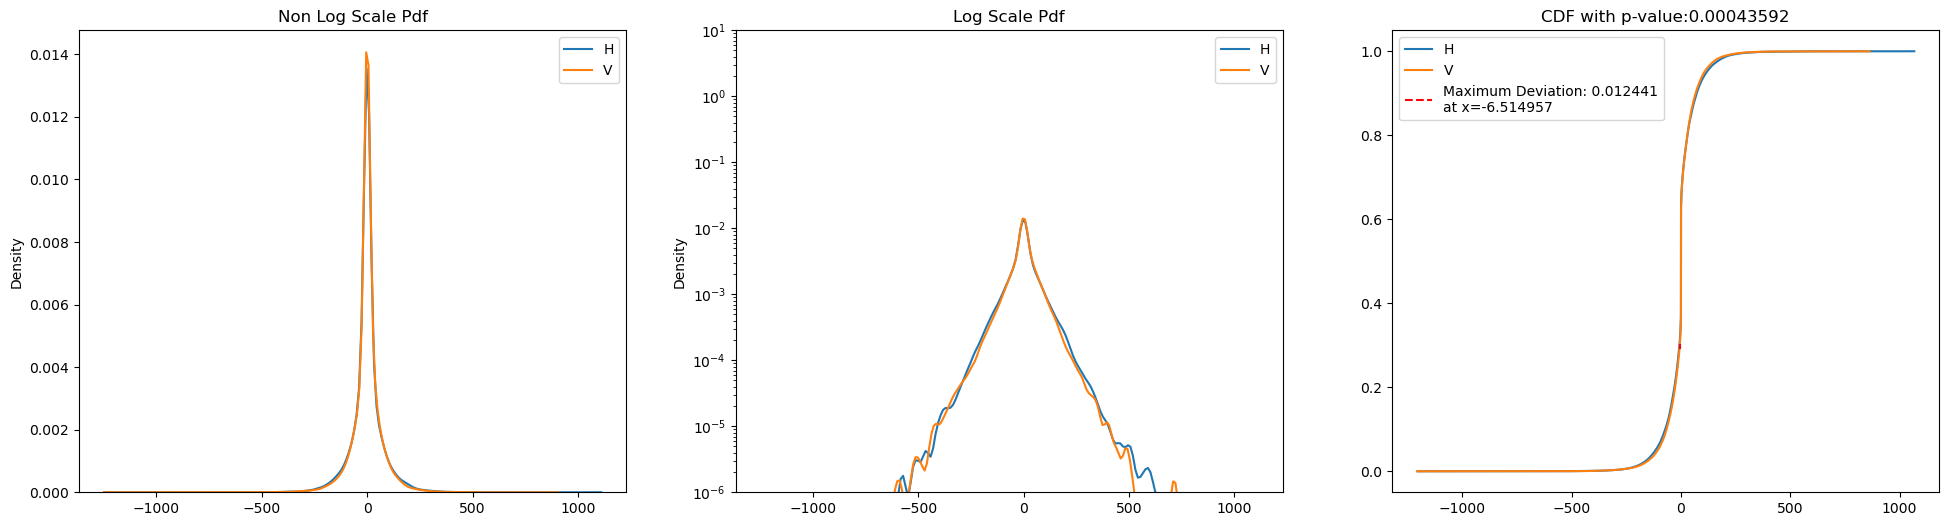

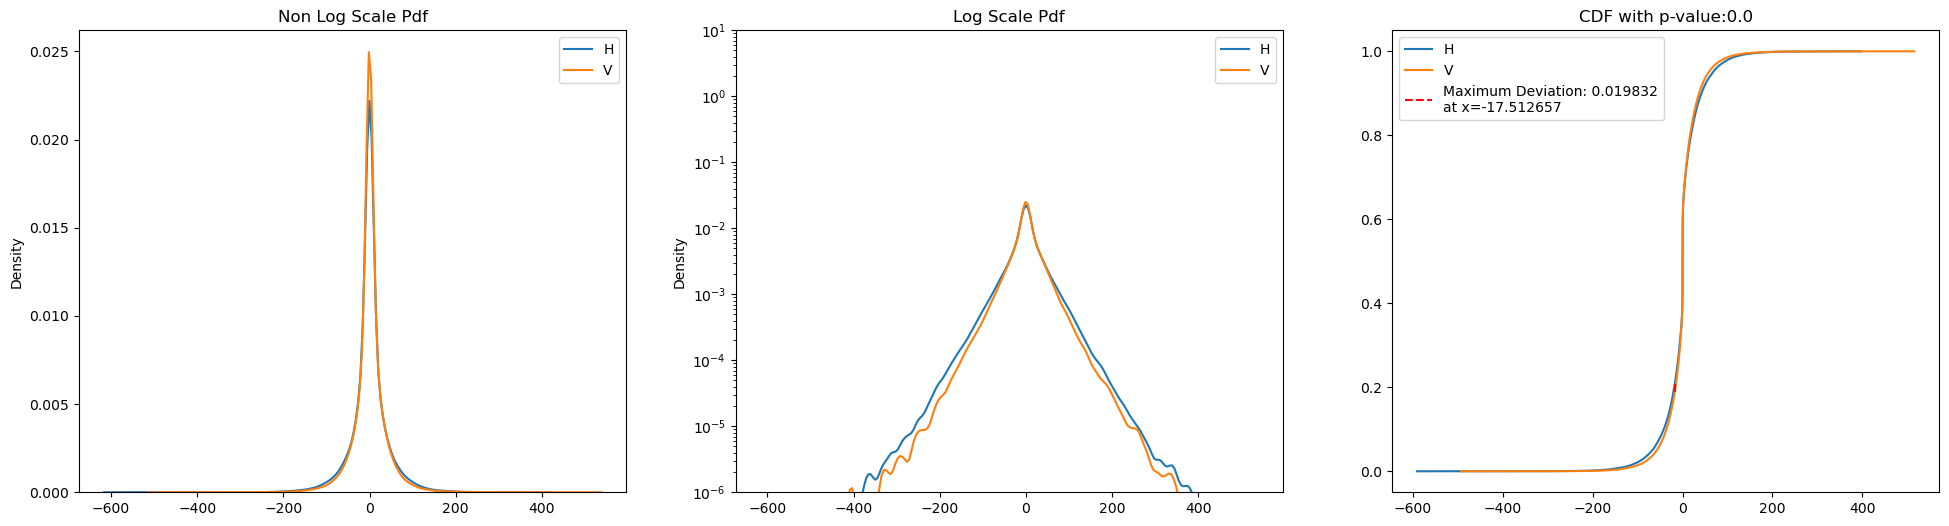

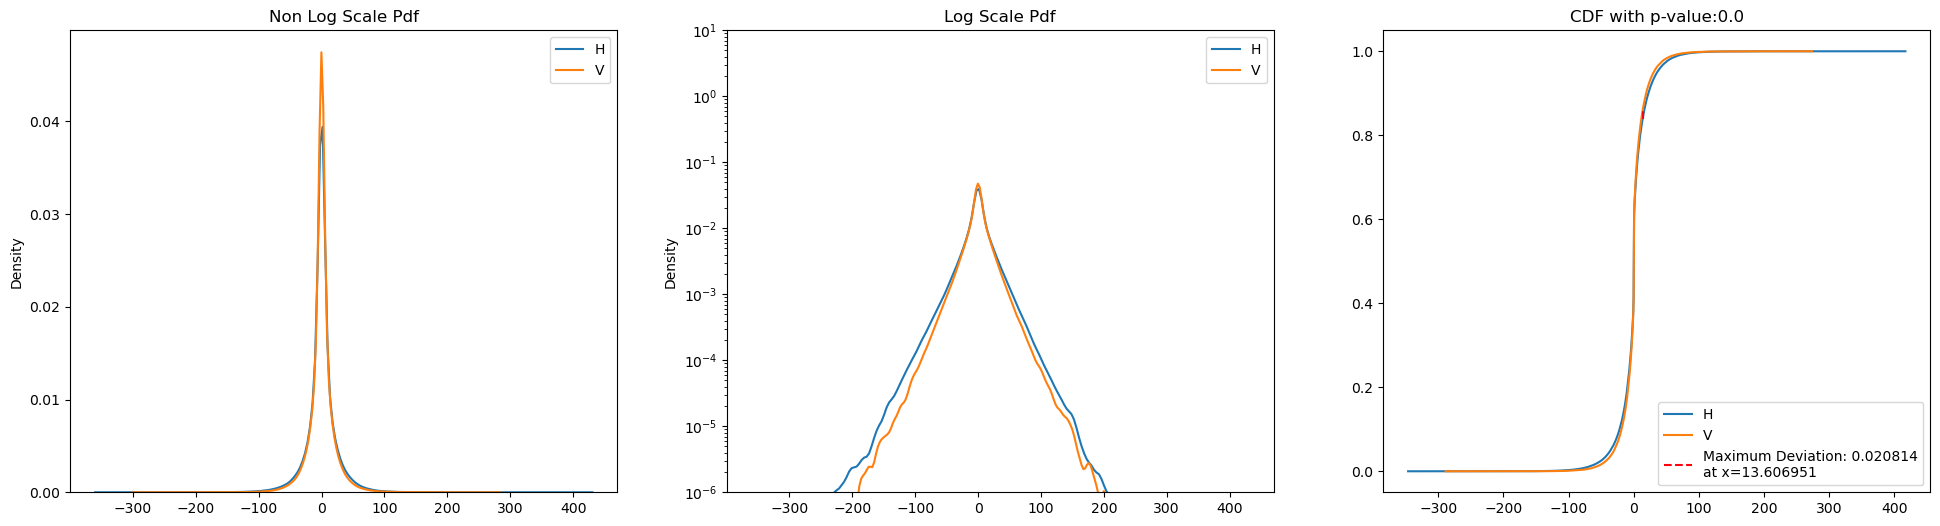

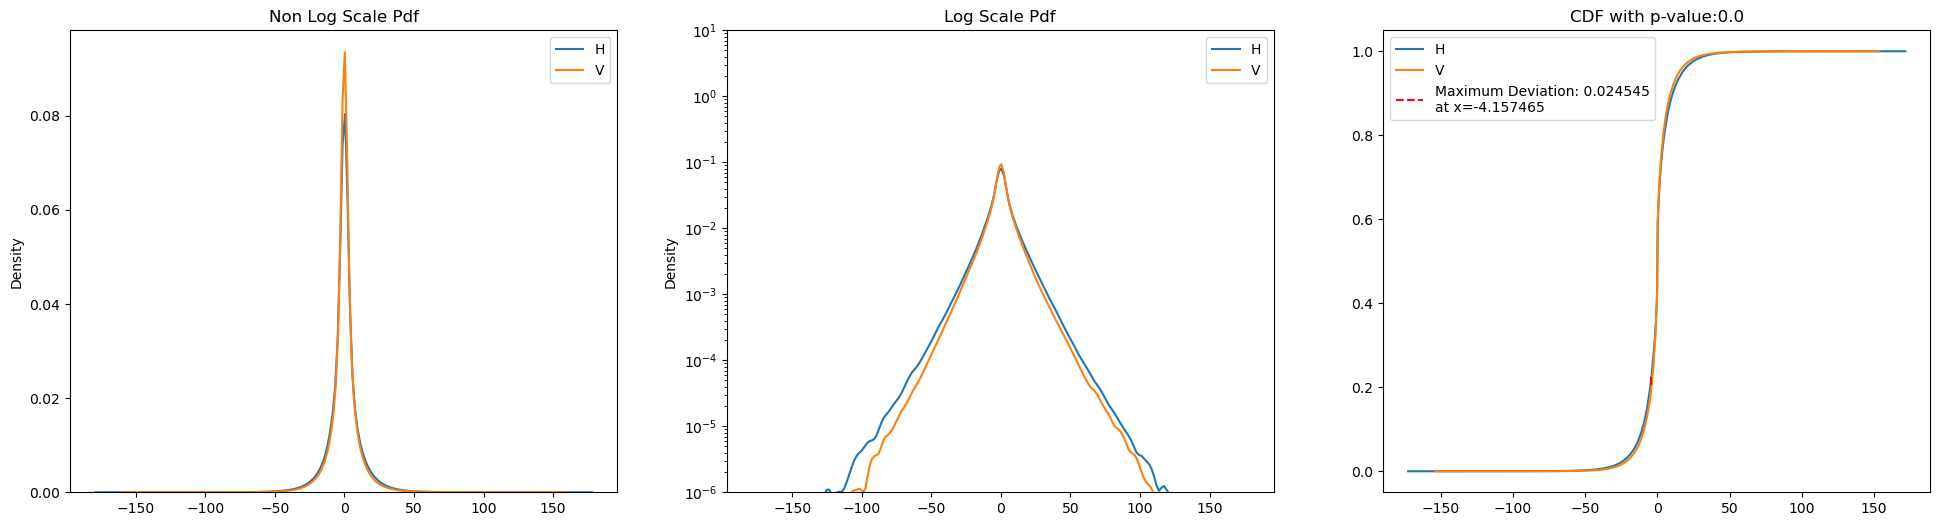

/opt/anaconda3/envs/hbmv/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


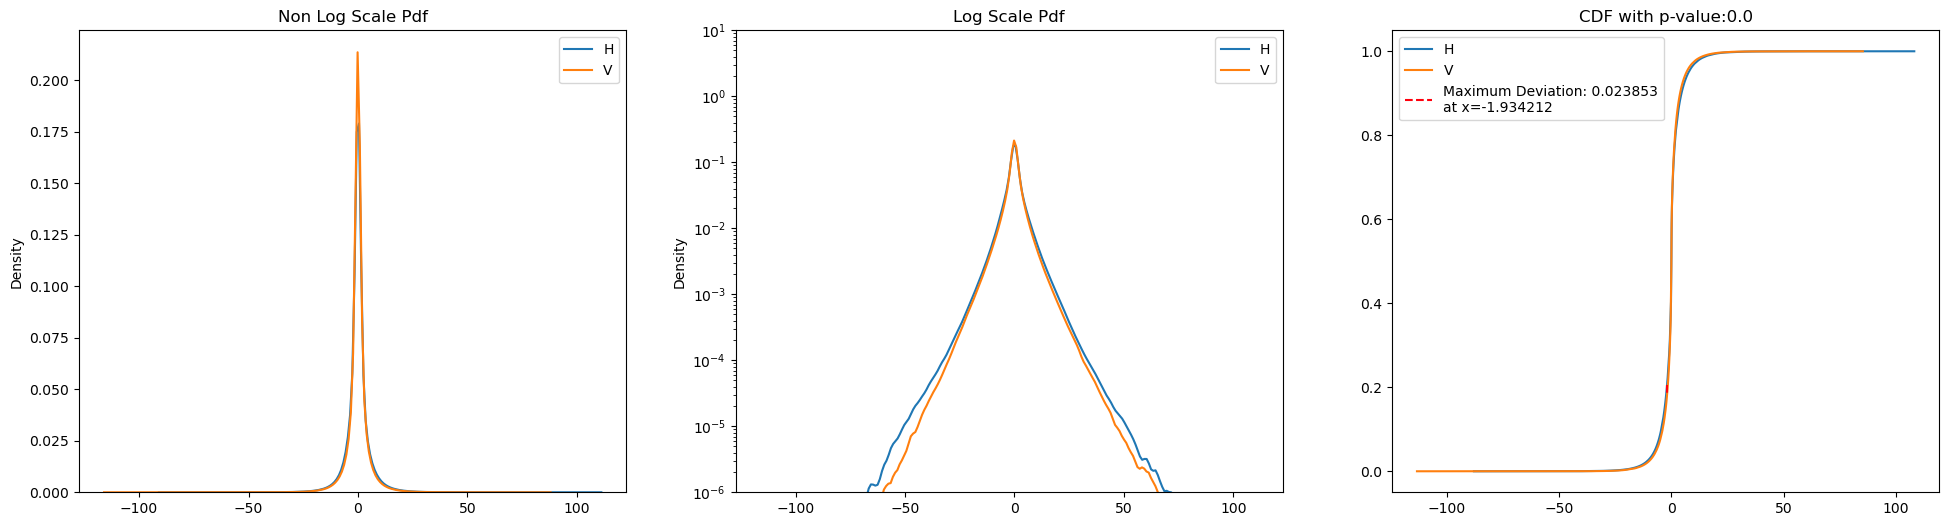

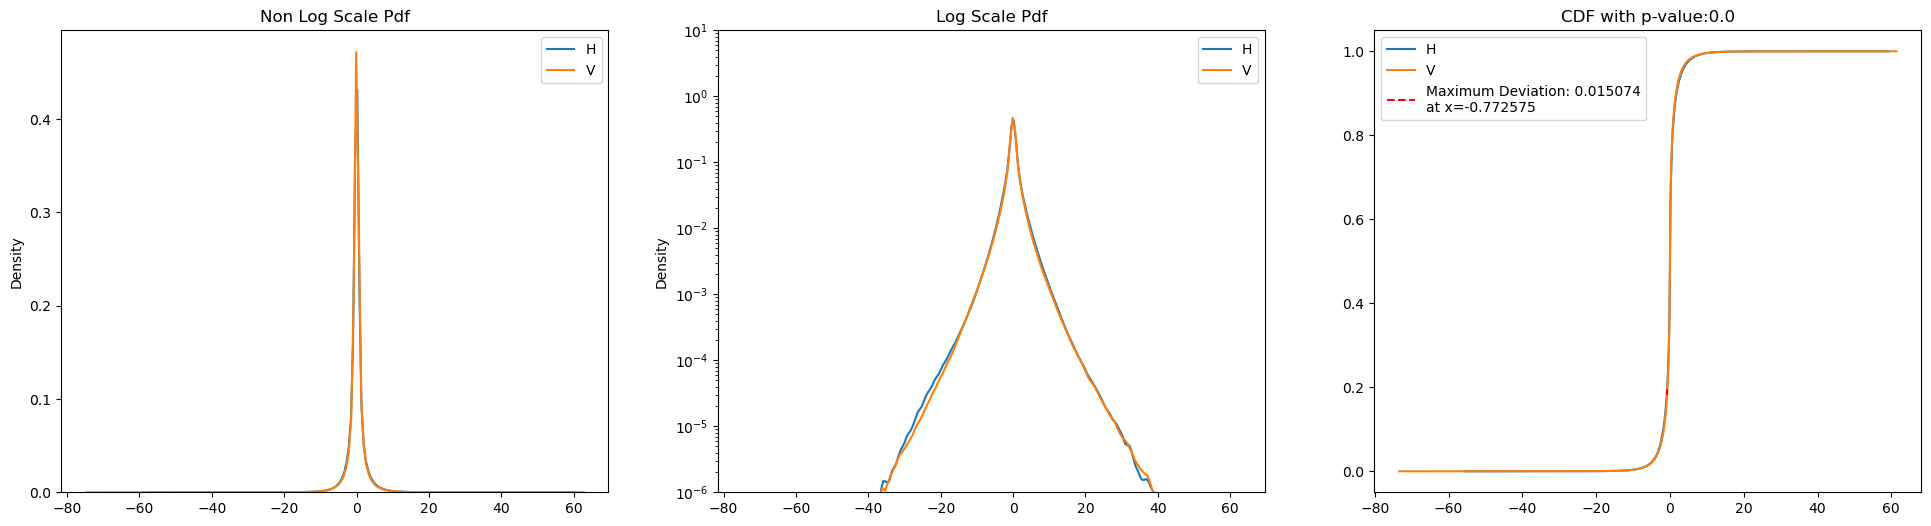

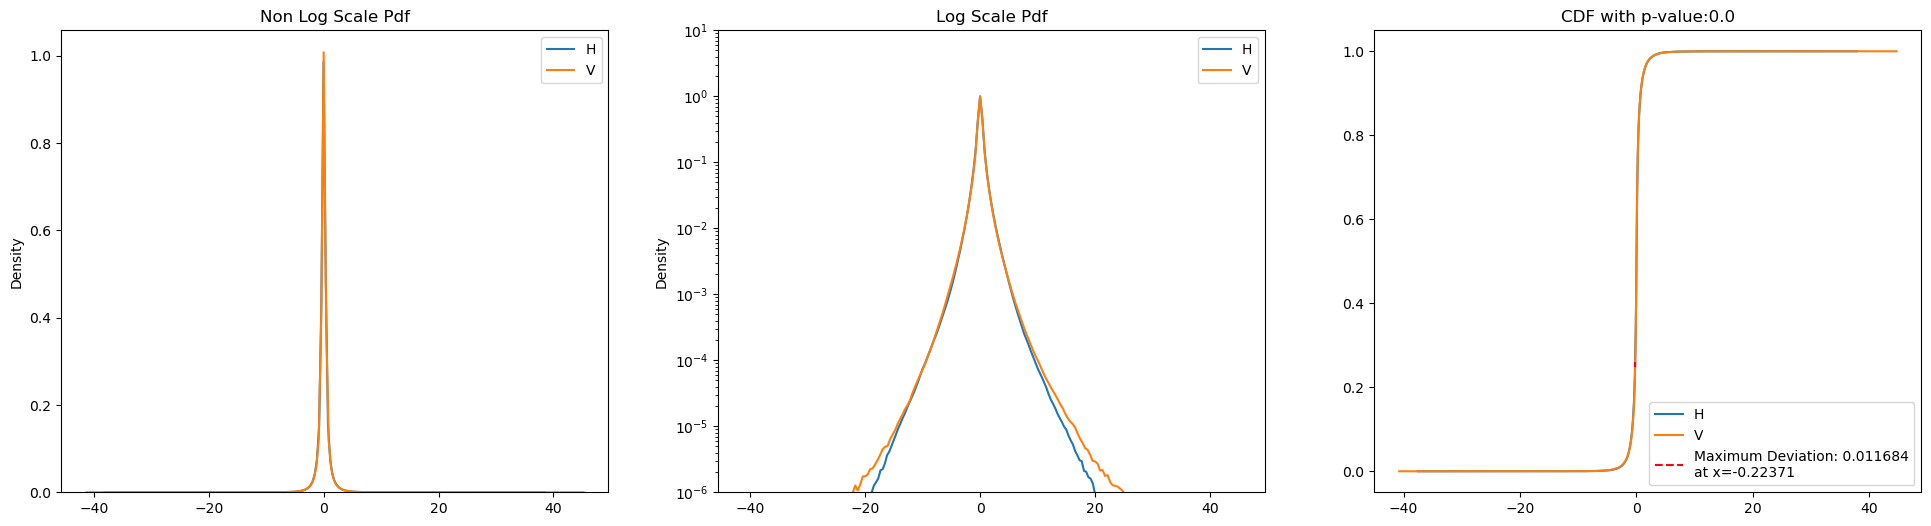

In [18]:
for i in range(2, 10):
    layer_df = gray_wv[gray_wv["layer"] == i]
    data = layer_df["data"].to_list()
    first_samp = layer_df[layer_df["orientation"] == "H"]["data"].iloc[0]
    second_samp = layer_df[layer_df["orientation"] == "V"]["data"].iloc[0]
    twoSampleComparisonPlots(first_samp, second_samp, samp1name="H", samp2name= "V")